In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from ResNet50 layers ...")
resnet50features = base_model.predict(X)

Extracting features from ResNet50 layers ...


In [8]:
print(resnet50features)

[[  0.00000000e+00   7.66116977e-02   1.96704543e+00 ...,   3.67457536e-03
    1.46600173e-03   1.74568444e-01]
 [  3.66235641e-03   8.19563568e-02   2.37002110e+00 ...,   1.07600456e-02
    0.00000000e+00   4.02208231e-02]
 [  3.82751832e-03   3.30251716e-02   2.09084988e+00 ...,   0.00000000e+00
    0.00000000e+00   2.31269941e-01]
 ..., 
 [  3.28066796e-01   1.19625159e-01   1.69672859e+00 ...,   9.49196797e-03
    3.17816325e-02   5.34403741e-01]
 [  5.42335249e-02   8.49562231e-03   1.12515652e+00 ...,   2.60611057e-01
    1.40642142e-03   1.65580250e-02]
 [  4.80559692e-02   2.04865649e-01   1.62438655e+00 ...,   0.00000000e+00
    0.00000000e+00   9.21922743e-01]]


In [9]:
resnet50features.shape

(10136, 2048)

In [10]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=resnet50features.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 20)                40980     
Total params: 40,980
Trainable params: 40,980
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-resnet50-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [14]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    resnet50features_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    resnet50features_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(resnet50features_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(resnet50features_train, Y_train, validation_data=(resnet50features_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(resnet50features_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0684
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 1s - loss: 1.1425 - acc: 0.6704 - val_loss: 0.7679 - val_acc: 0.7832
Epoch 2/100
9112/9112 [==============================] - 0s - loss: 0.6365 - acc: 0.8014 - val_loss: 0.6157 - val_acc: 0.8213
Epoch 3/100
9112/9112 [==============================] - 0s - loss: 0.5393 - acc: 0.8336 - val_loss: 0.5870 - val_acc: 0.8115
Epoch 4/100
9112/9112 [==============================] - 0s - loss: 0.4702 - acc: 0.8578 - val_loss: 0.5442 - val_acc: 0.8447
Epoch 5/100
9112/9112 [==============================] - 0s - loss: 0.4339 - acc: 0.8682 - val_loss: 0.5254 - val_acc: 0.8457
Epoch 6/100
9112/9112 [==============================] - 0s - loss: 0.3976 - acc: 0.8760 - val_loss: 0.5270 - val_acc: 0.8486
Epoch 7/100
9112/9112 [==============================] - 0s - loss: 0.3724 - acc: 0.8884 - val_loss: 0.5031 - val_acc: 0

9112/9112 [==============================] - 0s - loss: 0.0752 - acc: 0.9822 - val_loss: 0.4914 - val_acc: 0.8857
Epoch 65/100
9112/9112 [==============================] - 0s - loss: 0.0761 - acc: 0.9804 - val_loss: 0.4857 - val_acc: 0.8955
Epoch 66/100
9112/9112 [==============================] - 0s - loss: 0.0745 - acc: 0.9805 - val_loss: 0.4693 - val_acc: 0.9023
Epoch 67/100
9112/9112 [==============================] - 0s - loss: 0.0717 - acc: 0.9822 - val_loss: 0.4849 - val_acc: 0.8965
Epoch 68/100
9112/9112 [==============================] - 0s - loss: 0.0721 - acc: 0.9818 - val_loss: 0.4703 - val_acc: 0.8984
Epoch 69/100
9112/9112 [==============================] - 0s - loss: 0.0695 - acc: 0.9831 - val_loss: 0.4670 - val_acc: 0.9033
Epoch 70/100
9112/9112 [==============================] - 0s - loss: 0.0685 - acc: 0.9841 - val_loss: 0.4844 - val_acc: 0.9023
Epoch 71/100
9112/9112 [==============================] - 0s - loss: 0.0673 - acc: 0.9838 - val_loss: 0.4831 - val_acc: 0.89

9112/9112 [==============================] - 94s - loss: 0.0303 - acc: 0.9964 - val_loss: 0.5522 - val_acc: 0.8975
Epoch 28/100
9112/9112 [==============================] - 94s - loss: 0.0228 - acc: 0.9976 - val_loss: 0.4941 - val_acc: 0.9023
Epoch 29/100
9112/9112 [==============================] - 94s - loss: 0.0241 - acc: 0.9973 - val_loss: 0.4877 - val_acc: 0.9043
Epoch 30/100
9112/9112 [==============================] - 95s - loss: 0.0188 - acc: 0.9984 - val_loss: 0.4796 - val_acc: 0.9053
Epoch 31/100
9112/9112 [==============================] - 95s - loss: 0.0198 - acc: 0.9981 - val_loss: 0.4811 - val_acc: 0.9062
Epoch 32/100
9112/9112 [==============================] - 94s - loss: 0.0179 - acc: 0.9978 - val_loss: 0.4775 - val_acc: 0.9062
Epoch 33/100
9112/9112 [==============================] - 94s - loss: 0.0116 - acc: 0.9989 - val_loss: 0.4776 - val_acc: 0.9043
Epoch 34/100
9112/9112 [==============================] - 94s - loss: 0.0188 - acc: 0.9988 - val_loss: 0.4781 - val_a

9112/9112 [==============================] - 94s - loss: 0.0077 - acc: 0.9993 - val_loss: 0.5043 - val_acc: 0.9102
Epoch 92/100
9112/9112 [==============================] - 94s - loss: 0.0124 - acc: 0.9992 - val_loss: 0.5047 - val_acc: 0.9111
Epoch 93/100
9112/9112 [==============================] - 94s - loss: 0.0070 - acc: 0.9995 - val_loss: 0.5047 - val_acc: 0.9092
Epoch 94/100
9112/9112 [==============================] - 94s - loss: 0.0049 - acc: 0.9995 - val_loss: 0.5034 - val_acc: 0.9092
Epoch 95/100
9112/9112 [==============================] - 94s - loss: 0.0044 - acc: 0.9996 - val_loss: 0.5130 - val_acc: 0.9102
Epoch 96/100
9112/9112 [==============================] - 94s - loss: 0.0059 - acc: 0.9995 - val_loss: 0.5145 - val_acc: 0.9092
Epoch 97/100
9112/9112 [==============================] - 94s - loss: 0.0043 - acc: 0.9996 - val_loss: 0.5128 - val_acc: 0.9092
Epoch 98/100
9112/9112 [==============================] - 94s - loss: 0.0046 - acc: 0.9992 - val_loss: 0.5044 - val_a

9114/9114 [==============================] - 0s - loss: 0.0846 - acc: 0.9775 - val_loss: 0.4008 - val_acc: 0.8973
Epoch 55/100
9114/9114 [==============================] - 0s - loss: 0.0849 - acc: 0.9792 - val_loss: 0.4244 - val_acc: 0.8924
Epoch 56/100
9114/9114 [==============================] - 0s - loss: 0.0821 - acc: 0.9807 - val_loss: 0.4271 - val_acc: 0.8865
Epoch 57/100
9114/9114 [==============================] - 0s - loss: 0.0796 - acc: 0.9813 - val_loss: 0.4378 - val_acc: 0.8894
Epoch 58/100
9114/9114 [==============================] - 0s - loss: 0.0785 - acc: 0.9812 - val_loss: 0.4220 - val_acc: 0.8953
Epoch 59/100
9114/9114 [==============================] - 0s - loss: 0.0805 - acc: 0.9799 - val_loss: 0.4399 - val_acc: 0.8836
Epoch 60/100
9114/9114 [==============================] - 0s - loss: 0.0804 - acc: 0.9777 - val_loss: 0.4225 - val_acc: 0.8953
Epoch 61/100
9114/9114 [==============================] - 0s - loss: 0.0753 - acc: 0.9824 - val_loss: 0.4277 - val_acc: 0.89

9114/9114 [==============================] - 94s - loss: 0.0837 - acc: 0.9926 - val_loss: 0.6439 - val_acc: 0.8875
Epoch 18/100
9114/9114 [==============================] - 94s - loss: 0.0747 - acc: 0.9924 - val_loss: 0.5197 - val_acc: 0.8992
Epoch 19/100
9114/9114 [==============================] - 94s - loss: 0.0641 - acc: 0.9933 - val_loss: 0.7388 - val_acc: 0.8845
Epoch 20/100
9114/9114 [==============================] - 95s - loss: 0.0553 - acc: 0.9946 - val_loss: 0.7621 - val_acc: 0.8836
Epoch 21/100
9114/9114 [==============================] - 94s - loss: 0.0528 - acc: 0.9935 - val_loss: 0.7013 - val_acc: 0.8894
Epoch 22/100
9114/9114 [==============================] - 94s - loss: 0.0606 - acc: 0.9920 - val_loss: 0.8535 - val_acc: 0.8699
Epoch 23/100
9114/9114 [==============================] - 95s - loss: 0.0529 - acc: 0.9941 - val_loss: 0.6527 - val_acc: 0.8855
Epoch 24/100
9114/9114 [==============================] - 94s - loss: 0.0381 - acc: 0.9954 - val_loss: 0.5523 - val_a

9114/9114 [==============================] - 92s - loss: 0.0117 - acc: 0.9987 - val_loss: 0.7019 - val_acc: 0.8933
Epoch 82/100
9114/9114 [==============================] - 93s - loss: 0.0080 - acc: 0.9993 - val_loss: 0.6406 - val_acc: 0.8963
Epoch 83/100
9114/9114 [==============================] - 92s - loss: 0.0105 - acc: 0.9990 - val_loss: 0.6166 - val_acc: 0.8982
Epoch 84/100
9114/9114 [==============================] - 93s - loss: 0.0091 - acc: 0.9992 - val_loss: 0.5955 - val_acc: 0.9031
Epoch 85/100
9114/9114 [==============================] - 92s - loss: 0.0089 - acc: 0.9993 - val_loss: 0.5999 - val_acc: 0.9022
Epoch 86/100
9114/9114 [==============================] - 93s - loss: 0.0102 - acc: 0.9992 - val_loss: 0.5861 - val_acc: 0.9012
Epoch 87/100
9114/9114 [==============================] - 92s - loss: 0.0099 - acc: 0.9990 - val_loss: 0.6094 - val_acc: 0.9031
Epoch 88/100
9114/9114 [==============================] - 92s - loss: 0.0074 - acc: 0.9993 - val_loss: 0.6270 - val_a

9116/9116 [==============================] - 0s - loss: 0.1065 - acc: 0.9721 - val_loss: 0.4284 - val_acc: 0.8696
Epoch 45/100
9116/9116 [==============================] - 0s - loss: 0.1038 - acc: 0.9717 - val_loss: 0.4313 - val_acc: 0.8716
Epoch 46/100
9116/9116 [==============================] - 0s - loss: 0.1048 - acc: 0.9725 - val_loss: 0.4151 - val_acc: 0.8843
Epoch 47/100
9116/9116 [==============================] - 0s - loss: 0.1003 - acc: 0.9750 - val_loss: 0.4174 - val_acc: 0.8833
Epoch 48/100
9116/9116 [==============================] - 0s - loss: 0.0946 - acc: 0.9773 - val_loss: 0.4188 - val_acc: 0.8824
Epoch 49/100
9116/9116 [==============================] - 0s - loss: 0.0930 - acc: 0.9774 - val_loss: 0.4115 - val_acc: 0.8912
Epoch 50/100
9116/9116 [==============================] - 0s - loss: 0.0970 - acc: 0.9759 - val_loss: 0.4229 - val_acc: 0.8863
Epoch 51/100
9116/9116 [==============================] - 0s - loss: 0.0913 - acc: 0.9773 - val_loss: 0.4238 - val_acc: 0.88

9116/9116 [==============================] - 92s - loss: 0.2839 - acc: 0.9501 - val_loss: 0.7276 - val_acc: 0.8706
Epoch 8/100
9116/9116 [==============================] - 92s - loss: 0.2177 - acc: 0.9653 - val_loss: 0.6035 - val_acc: 0.8755
Epoch 9/100
9116/9116 [==============================] - 92s - loss: 0.2084 - acc: 0.9667 - val_loss: 0.5727 - val_acc: 0.8873
Epoch 10/100
9116/9116 [==============================] - 92s - loss: 0.1911 - acc: 0.9730 - val_loss: 0.7087 - val_acc: 0.8706
Epoch 11/100
9116/9116 [==============================] - 92s - loss: 0.1298 - acc: 0.9789 - val_loss: 0.6002 - val_acc: 0.8892
Epoch 12/100
9116/9116 [==============================] - 92s - loss: 0.1202 - acc: 0.9832 - val_loss: 0.5285 - val_acc: 0.8941
Epoch 13/100
9116/9116 [==============================] - 103s - loss: 0.1016 - acc: 0.9877 - val_loss: 0.5344 - val_acc: 0.8971
Epoch 14/100
9116/9116 [==============================] - 105s - loss: 0.0808 - acc: 0.9897 - val_loss: 0.5163 - val_a

9116/9116 [==============================] - 144s - loss: 0.0077 - acc: 0.9990 - val_loss: 0.5368 - val_acc: 0.9137
Epoch 71/100
9116/9116 [==============================] - 145s - loss: 0.0075 - acc: 0.9993 - val_loss: 0.5329 - val_acc: 0.9137
Epoch 72/100
9116/9116 [==============================] - 144s - loss: 0.0076 - acc: 0.9991 - val_loss: 0.5339 - val_acc: 0.9137
Epoch 73/100
9116/9116 [==============================] - 145s - loss: 0.0073 - acc: 0.9993 - val_loss: 0.5300 - val_acc: 0.9147
Epoch 74/100
9116/9116 [==============================] - 144s - loss: 0.0071 - acc: 0.9993 - val_loss: 0.5353 - val_acc: 0.9147
Epoch 75/100
9116/9116 [==============================] - 143s - loss: 0.0073 - acc: 0.9993 - val_loss: 0.5354 - val_acc: 0.9157
Epoch 76/100
9116/9116 [==============================] - 146s - loss: 0.0090 - acc: 0.9988 - val_loss: 0.5389 - val_acc: 0.9137
Epoch 77/100
9116/9116 [==============================] - 144s - loss: 0.0069 - acc: 0.9995 - val_loss: 0.5263

9120/9120 [==============================] - 0s - loss: 0.1382 - acc: 0.9612 - val_loss: 0.5342 - val_acc: 0.8780
Epoch 33/100
9120/9120 [==============================] - 0s - loss: 0.1330 - acc: 0.9605 - val_loss: 0.4958 - val_acc: 0.8750
Epoch 34/100
9120/9120 [==============================] - 0s - loss: 0.1259 - acc: 0.9667 - val_loss: 0.4947 - val_acc: 0.8829
Epoch 35/100
9120/9120 [==============================] - 0s - loss: 0.1250 - acc: 0.9651 - val_loss: 0.4944 - val_acc: 0.8789
Epoch 36/100
9120/9120 [==============================] - 0s - loss: 0.1248 - acc: 0.9656 - val_loss: 0.5205 - val_acc: 0.8780
Epoch 37/100
9120/9120 [==============================] - 0s - loss: 0.1207 - acc: 0.9662 - val_loss: 0.5076 - val_acc: 0.8799
Epoch 38/100
9120/9120 [==============================] - 0s - loss: 0.1169 - acc: 0.9685 - val_loss: 0.4979 - val_acc: 0.8780
Epoch 39/100
9120/9120 [==============================] - 0s - loss: 0.1174 - acc: 0.9670 - val_loss: 0.5133 - val_acc: 0.87

9120/9120 [==============================] - 0s - loss: 0.0465 - acc: 0.9917 - val_loss: 0.6271 - val_acc: 0.8839
Epoch 97/100
9120/9120 [==============================] - 0s - loss: 0.0451 - acc: 0.9914 - val_loss: 0.6504 - val_acc: 0.8799
Epoch 98/100
9120/9120 [==============================] - 0s - loss: 0.0433 - acc: 0.9922 - val_loss: 0.6119 - val_acc: 0.8829
Epoch 99/100
9120/9120 [==============================] - 0s - loss: 0.0446 - acc: 0.9916 - val_loss: 0.6243 - val_acc: 0.8819
Epoch 100/100
9120/9120 [==============================] - 0s - loss: 0.0407 - acc: 0.9944 - val_loss: 0.6376 - val_acc: 0.8799
[3] Pre-trained acurracy (top_model): 0.8799
[3] Fine-tuning the model ...
Train on 9120 samples, validate on 1016 samples
Epoch 1/100
9120/9120 [==============================] - 97s - loss: 2.5483 - acc: 0.5819 - val_loss: 1.9099 - val_acc: 0.5463
Epoch 2/100
9120/9120 [==============================] - 94s - loss: 0.8697 - acc: 0.8012 - val_loss: 0.8728 - val_acc: 0.7825


9120/9120 [==============================] - 105s - loss: 0.0122 - acc: 0.9990 - val_loss: 0.5684 - val_acc: 0.8868
Epoch 60/100
9120/9120 [==============================] - 114s - loss: 0.0074 - acc: 0.9995 - val_loss: 0.5849 - val_acc: 0.8917
Epoch 61/100
9120/9120 [==============================] - 122s - loss: 0.0087 - acc: 0.9991 - val_loss: 0.5821 - val_acc: 0.8907
Epoch 62/100
9120/9120 [==============================] - 102s - loss: 0.0092 - acc: 0.9990 - val_loss: 0.5753 - val_acc: 0.8937
Epoch 63/100
9120/9120 [==============================] - 108s - loss: 0.0088 - acc: 0.9992 - val_loss: 0.5632 - val_acc: 0.8917
Epoch 64/100
9120/9120 [==============================] - 110s - loss: 0.0114 - acc: 0.9982 - val_loss: 0.5422 - val_acc: 0.8976
Epoch 65/100
9120/9120 [==============================] - 109s - loss: 0.0124 - acc: 0.9988 - val_loss: 0.5695 - val_acc: 0.8957
Epoch 66/100
9120/9120 [==============================] - 109s - loss: 0.0088 - acc: 0.9991 - val_loss: 0.5823

9120/9120 [==============================] - 0s - loss: 0.1809 - acc: 0.9484 - val_loss: 0.3687 - val_acc: 0.8986
Epoch 22/100
9120/9120 [==============================] - 0s - loss: 0.1741 - acc: 0.9498 - val_loss: 0.3857 - val_acc: 0.8898
Epoch 23/100
9120/9120 [==============================] - 0s - loss: 0.1730 - acc: 0.9488 - val_loss: 0.3639 - val_acc: 0.8907
Epoch 24/100
9120/9120 [==============================] - 0s - loss: 0.1722 - acc: 0.9471 - val_loss: 0.3888 - val_acc: 0.8957
Epoch 25/100
9120/9120 [==============================] - 0s - loss: 0.1677 - acc: 0.9499 - val_loss: 0.3629 - val_acc: 0.8907
Epoch 26/100
9120/9120 [==============================] - 0s - loss: 0.1593 - acc: 0.9547 - val_loss: 0.3696 - val_acc: 0.8986
Epoch 27/100
9120/9120 [==============================] - 0s - loss: 0.1576 - acc: 0.9529 - val_loss: 0.3712 - val_acc: 0.8927
Epoch 28/100
9120/9120 [==============================] - 0s - loss: 0.1547 - acc: 0.9545 - val_loss: 0.3704 - val_acc: 0.90

9120/9120 [==============================] - 0s - loss: 0.0526 - acc: 0.9909 - val_loss: 0.4055 - val_acc: 0.9006
Epoch 86/100
9120/9120 [==============================] - 0s - loss: 0.0538 - acc: 0.9887 - val_loss: 0.4038 - val_acc: 0.9026
Epoch 87/100
9120/9120 [==============================] - 0s - loss: 0.0507 - acc: 0.9909 - val_loss: 0.4122 - val_acc: 0.9006
Epoch 88/100
9120/9120 [==============================] - 0s - loss: 0.0504 - acc: 0.9901 - val_loss: 0.4127 - val_acc: 0.9016
Epoch 89/100
9120/9120 [==============================] - 0s - loss: 0.0501 - acc: 0.9905 - val_loss: 0.4123 - val_acc: 0.9026
Epoch 90/100
9120/9120 [==============================] - 0s - loss: 0.0505 - acc: 0.9896 - val_loss: 0.4081 - val_acc: 0.9055
Epoch 91/100
9120/9120 [==============================] - 0s - loss: 0.0511 - acc: 0.9894 - val_loss: 0.4267 - val_acc: 0.8986
Epoch 92/100
9120/9120 [==============================] - 0s - loss: 0.0499 - acc: 0.9898 - val_loss: 0.4175 - val_acc: 0.90

9120/9120 [==============================] - 94s - loss: 0.0077 - acc: 0.9991 - val_loss: 0.4842 - val_acc: 0.9134
Epoch 49/100
9120/9120 [==============================] - 91s - loss: 0.0102 - acc: 0.9988 - val_loss: 0.6202 - val_acc: 0.9006
Epoch 50/100
9120/9120 [==============================] - 91s - loss: 0.0083 - acc: 0.9991 - val_loss: 0.6023 - val_acc: 0.9045
Epoch 51/100
9120/9120 [==============================] - 91s - loss: 0.0055 - acc: 0.9992 - val_loss: 0.5842 - val_acc: 0.9035
Epoch 52/100
9120/9120 [==============================] - 93s - loss: 0.0087 - acc: 0.9988 - val_loss: 0.6093 - val_acc: 0.9055
Epoch 53/100
9120/9120 [==============================] - 91s - loss: 0.0082 - acc: 0.9995 - val_loss: 0.5968 - val_acc: 0.9065
Epoch 54/100
9120/9120 [==============================] - 91s - loss: 0.0081 - acc: 0.9988 - val_loss: 0.6137 - val_acc: 0.9094
Epoch 55/100
9120/9120 [==============================] - 91s - loss: 0.0096 - acc: 0.9987 - val_loss: 0.6095 - val_a

9125/9125 [==============================] - 0s - loss: 0.2641 - acc: 0.9192 - val_loss: 0.3787 - val_acc: 0.8853
Epoch 11/100
9125/9125 [==============================] - 0s - loss: 0.2612 - acc: 0.9210 - val_loss: 0.3730 - val_acc: 0.8932
Epoch 12/100
9125/9125 [==============================] - 0s - loss: 0.2407 - acc: 0.9268 - val_loss: 0.3733 - val_acc: 0.8892
Epoch 13/100
9125/9125 [==============================] - 0s - loss: 0.2341 - acc: 0.9293 - val_loss: 0.3827 - val_acc: 0.8803
Epoch 14/100
9125/9125 [==============================] - 0s - loss: 0.2272 - acc: 0.9302 - val_loss: 0.3657 - val_acc: 0.8952
Epoch 15/100
9125/9125 [==============================] - 0s - loss: 0.2172 - acc: 0.9364 - val_loss: 0.3678 - val_acc: 0.8932
Epoch 16/100
9125/9125 [==============================] - 0s - loss: 0.2100 - acc: 0.9379 - val_loss: 0.3711 - val_acc: 0.8853
Epoch 17/100
9125/9125 [==============================] - 0s - loss: 0.2063 - acc: 0.9395 - val_loss: 0.3543 - val_acc: 0.89

9125/9125 [==============================] - 0s - loss: 0.0601 - acc: 0.9876 - val_loss: 0.4160 - val_acc: 0.9050
Epoch 75/100
9125/9125 [==============================] - 0s - loss: 0.0636 - acc: 0.9851 - val_loss: 0.4050 - val_acc: 0.9001
Epoch 76/100
9125/9125 [==============================] - 0s - loss: 0.0605 - acc: 0.9864 - val_loss: 0.4269 - val_acc: 0.9031
Epoch 77/100
9125/9125 [==============================] - 0s - loss: 0.0592 - acc: 0.9866 - val_loss: 0.4179 - val_acc: 0.9060
Epoch 78/100
9125/9125 [==============================] - 0s - loss: 0.0588 - acc: 0.9877 - val_loss: 0.4282 - val_acc: 0.9041
Epoch 79/100
9125/9125 [==============================] - 0s - loss: 0.0574 - acc: 0.9881 - val_loss: 0.4191 - val_acc: 0.9070
Epoch 80/100
9125/9125 [==============================] - 0s - loss: 0.0620 - acc: 0.9854 - val_loss: 0.4567 - val_acc: 0.8991
Epoch 81/100
9125/9125 [==============================] - 0s - loss: 0.0551 - acc: 0.9890 - val_loss: 0.4397 - val_acc: 0.90

9125/9125 [==============================] - 91s - loss: 0.0146 - acc: 0.9987 - val_loss: 0.4298 - val_acc: 0.9021
Epoch 38/100
9125/9125 [==============================] - 91s - loss: 0.0153 - acc: 0.9978 - val_loss: 0.5224 - val_acc: 0.9050
Epoch 39/100
9125/9125 [==============================] - 91s - loss: 0.0129 - acc: 0.9987 - val_loss: 0.5530 - val_acc: 0.9011
Epoch 40/100
9125/9125 [==============================] - 91s - loss: 0.0240 - acc: 0.9976 - val_loss: 0.5689 - val_acc: 0.9031
Epoch 41/100
9125/9125 [==============================] - 91s - loss: 0.0116 - acc: 0.9985 - val_loss: 0.5812 - val_acc: 0.9041
Epoch 42/100
9125/9125 [==============================] - 91s - loss: 0.0170 - acc: 0.9984 - val_loss: 0.4431 - val_acc: 0.9090
Epoch 43/100
9125/9125 [==============================] - 92s - loss: 0.0114 - acc: 0.9989 - val_loss: 0.4444 - val_acc: 0.9100
Epoch 44/100
9125/9125 [==============================] - 91s - loss: 0.0125 - acc: 0.9986 - val_loss: 0.4317 - val_a

[6] Pre-training the top model ...
[6] Initial acurracy (top_model): 0.0674
Train on 9127 samples, validate on 1009 samples
Epoch 1/100
9127/9127 [==============================] - 0s - loss: 0.9213 - acc: 0.7338 - val_loss: 0.5566 - val_acc: 0.8127
Epoch 2/100
9127/9127 [==============================] - 0s - loss: 0.5073 - acc: 0.8418 - val_loss: 0.4922 - val_acc: 0.8375
Epoch 3/100
9127/9127 [==============================] - 0s - loss: 0.4282 - acc: 0.8679 - val_loss: 0.4413 - val_acc: 0.8612
Epoch 4/100
9127/9127 [==============================] - 0s - loss: 0.3820 - acc: 0.8830 - val_loss: 0.4320 - val_acc: 0.8573
Epoch 5/100
9127/9127 [==============================] - 0s - loss: 0.3469 - acc: 0.8914 - val_loss: 0.4914 - val_acc: 0.8216
Epoch 6/100
9127/9127 [==============================] - 0s - loss: 0.3309 - acc: 0.8962 - val_loss: 0.4078 - val_acc: 0.8821
Epoch 7/100
9127/9127 [==============================] - 0s - loss: 0.3022 - acc: 0.9045 - val_loss: 0.3962 - val_acc: 0

9127/9127 [==============================] - 0s - loss: 0.0750 - acc: 0.9836 - val_loss: 0.3722 - val_acc: 0.9039
Epoch 65/100
9127/9127 [==============================] - 0s - loss: 0.0713 - acc: 0.9826 - val_loss: 0.4287 - val_acc: 0.8712
Epoch 66/100
9127/9127 [==============================] - 0s - loss: 0.0731 - acc: 0.9819 - val_loss: 0.3664 - val_acc: 0.9039
Epoch 67/100
9127/9127 [==============================] - 0s - loss: 0.0693 - acc: 0.9838 - val_loss: 0.3796 - val_acc: 0.9009
Epoch 68/100
9127/9127 [==============================] - 0s - loss: 0.0693 - acc: 0.9824 - val_loss: 0.3777 - val_acc: 0.9019
Epoch 69/100
9127/9127 [==============================] - 0s - loss: 0.0682 - acc: 0.9840 - val_loss: 0.3733 - val_acc: 0.9029
Epoch 70/100
9127/9127 [==============================] - 0s - loss: 0.0648 - acc: 0.9844 - val_loss: 0.3851 - val_acc: 0.8920
Epoch 71/100
9127/9127 [==============================] - 0s - loss: 0.0634 - acc: 0.9861 - val_loss: 0.3828 - val_acc: 0.89

9127/9127 [==============================] - 91s - loss: 0.0187 - acc: 0.9982 - val_loss: 0.5706 - val_acc: 0.8940
Epoch 28/100
9127/9127 [==============================] - 91s - loss: 0.0181 - acc: 0.9982 - val_loss: 0.5382 - val_acc: 0.9009
Epoch 29/100
9127/9127 [==============================] - 91s - loss: 0.0178 - acc: 0.9984 - val_loss: 0.5312 - val_acc: 0.8959
Epoch 30/100
9127/9127 [==============================] - 91s - loss: 0.0172 - acc: 0.9987 - val_loss: 0.5340 - val_acc: 0.8959
Epoch 31/100
9127/9127 [==============================] - 91s - loss: 0.0168 - acc: 0.9987 - val_loss: 0.4950 - val_acc: 0.8940
Epoch 32/100
9127/9127 [==============================] - 92s - loss: 0.0145 - acc: 0.9987 - val_loss: 0.5056 - val_acc: 0.8949
Epoch 33/100
9127/9127 [==============================] - 92s - loss: 0.0176 - acc: 0.9984 - val_loss: 0.4952 - val_acc: 0.8989
Epoch 34/100
9127/9127 [==============================] - 91s - loss: 0.0163 - acc: 0.9986 - val_loss: 0.5193 - val_a

9127/9127 [==============================] - 91s - loss: 0.0084 - acc: 0.9993 - val_loss: 0.5499 - val_acc: 0.9019
Epoch 92/100
9127/9127 [==============================] - 91s - loss: 0.0086 - acc: 0.9993 - val_loss: 0.5443 - val_acc: 0.9009
Epoch 93/100
9127/9127 [==============================] - 91s - loss: 0.0115 - acc: 0.9991 - val_loss: 0.5500 - val_acc: 0.9029
Epoch 94/100
9127/9127 [==============================] - 91s - loss: 0.0084 - acc: 0.9993 - val_loss: 0.5491 - val_acc: 0.9029
Epoch 95/100
9127/9127 [==============================] - 91s - loss: 0.0083 - acc: 0.9995 - val_loss: 0.5522 - val_acc: 0.9039
Epoch 96/100
9127/9127 [==============================] - 91s - loss: 0.0081 - acc: 0.9993 - val_loss: 0.5572 - val_acc: 0.9019
Epoch 97/100
9127/9127 [==============================] - 91s - loss: 0.0081 - acc: 0.9995 - val_loss: 0.5560 - val_acc: 0.9019
Epoch 98/100
9127/9127 [==============================] - 91s - loss: 0.0090 - acc: 0.9992 - val_loss: 0.5498 - val_a

9128/9128 [==============================] - 0s - loss: 0.0841 - acc: 0.9805 - val_loss: 0.4516 - val_acc: 0.8938
Epoch 55/100
9128/9128 [==============================] - 0s - loss: 0.0887 - acc: 0.9768 - val_loss: 0.4438 - val_acc: 0.8929
Epoch 56/100
9128/9128 [==============================] - 0s - loss: 0.0845 - acc: 0.9790 - val_loss: 0.4490 - val_acc: 0.8889
Epoch 57/100
9128/9128 [==============================] - 0s - loss: 0.0835 - acc: 0.9775 - val_loss: 0.4484 - val_acc: 0.8998
Epoch 58/100
9128/9128 [==============================] - 0s - loss: 0.0822 - acc: 0.9800 - val_loss: 0.4581 - val_acc: 0.8938
Epoch 59/100
9128/9128 [==============================] - 0s - loss: 0.0828 - acc: 0.9791 - val_loss: 0.4461 - val_acc: 0.8968
Epoch 60/100
9128/9128 [==============================] - 0s - loss: 0.0785 - acc: 0.9805 - val_loss: 0.4528 - val_acc: 0.8948
Epoch 61/100
9128/9128 [==============================] - 0s - loss: 0.0758 - acc: 0.9825 - val_loss: 0.4557 - val_acc: 0.89

9128/9128 [==============================] - 92s - loss: 0.1170 - acc: 0.9905 - val_loss: 0.6697 - val_acc: 0.8849
Epoch 18/100
9128/9128 [==============================] - 92s - loss: 0.1421 - acc: 0.9862 - val_loss: 0.5431 - val_acc: 0.8909
Epoch 19/100
9128/9128 [==============================] - 91s - loss: 0.1864 - acc: 0.9817 - val_loss: 0.8396 - val_acc: 0.8760
Epoch 20/100
9128/9128 [==============================] - 91s - loss: 0.1503 - acc: 0.9849 - val_loss: 0.5418 - val_acc: 0.8988
Epoch 21/100
9128/9128 [==============================] - 91s - loss: 0.1204 - acc: 0.9904 - val_loss: 0.5185 - val_acc: 0.8998
Epoch 22/100
9128/9128 [==============================] - 91s - loss: 0.1220 - acc: 0.9856 - val_loss: 0.5471 - val_acc: 0.8968
Epoch 23/100
9128/9128 [==============================] - 91s - loss: 0.0952 - acc: 0.9901 - val_loss: 0.5762 - val_acc: 0.9038
Epoch 24/100
9128/9128 [==============================] - 91s - loss: 0.0564 - acc: 0.9941 - val_loss: 0.5552 - val_a

9128/9128 [==============================] - 93s - loss: 0.0054 - acc: 0.9996 - val_loss: 0.6375 - val_acc: 0.9137
Epoch 82/100
9128/9128 [==============================] - 91s - loss: 0.0066 - acc: 0.9992 - val_loss: 0.5992 - val_acc: 0.9117
Epoch 83/100
9128/9128 [==============================] - 92s - loss: 0.0073 - acc: 0.9992 - val_loss: 0.6454 - val_acc: 0.9137
Epoch 84/100
9128/9128 [==============================] - 92s - loss: 0.0054 - acc: 0.9996 - val_loss: 0.6470 - val_acc: 0.9117
Epoch 85/100
9128/9128 [==============================] - 92s - loss: 0.0048 - acc: 0.9996 - val_loss: 0.6461 - val_acc: 0.9117
Epoch 86/100
9128/9128 [==============================] - 91s - loss: 0.0054 - acc: 0.9996 - val_loss: 0.6458 - val_acc: 0.9127
Epoch 87/100
9128/9128 [==============================] - 91s - loss: 0.0054 - acc: 0.9993 - val_loss: 0.6420 - val_acc: 0.9127
Epoch 88/100
9128/9128 [==============================] - 91s - loss: 0.0087 - acc: 0.9988 - val_loss: 0.6517 - val_a

9130/9130 [==============================] - 0s - loss: 0.1047 - acc: 0.9720 - val_loss: 0.4120 - val_acc: 0.8887
Epoch 45/100
9130/9130 [==============================] - 0s - loss: 0.1019 - acc: 0.9732 - val_loss: 0.4033 - val_acc: 0.8857
Epoch 46/100
9130/9130 [==============================] - 0s - loss: 0.0995 - acc: 0.9723 - val_loss: 0.4230 - val_acc: 0.8917
Epoch 47/100
9130/9130 [==============================] - 0s - loss: 0.0985 - acc: 0.9743 - val_loss: 0.4247 - val_acc: 0.8807
Epoch 48/100
9130/9130 [==============================] - 0s - loss: 0.0958 - acc: 0.9761 - val_loss: 0.4050 - val_acc: 0.8827
Epoch 49/100
9130/9130 [==============================] - 0s - loss: 0.0930 - acc: 0.9790 - val_loss: 0.4214 - val_acc: 0.8857
Epoch 50/100
9130/9130 [==============================] - 0s - loss: 0.0915 - acc: 0.9774 - val_loss: 0.4090 - val_acc: 0.8857
Epoch 51/100
9130/9130 [==============================] - 0s - loss: 0.0887 - acc: 0.9786 - val_loss: 0.4208 - val_acc: 0.89

9130/9130 [==============================] - 91s - loss: 0.3328 - acc: 0.9490 - val_loss: 0.7146 - val_acc: 0.8618
Epoch 8/100
9130/9130 [==============================] - 91s - loss: 0.4342 - acc: 0.9450 - val_loss: 1.1552 - val_acc: 0.8439
Epoch 9/100
9130/9130 [==============================] - 91s - loss: 0.2319 - acc: 0.9618 - val_loss: 0.4598 - val_acc: 0.8956
Epoch 10/100
9130/9130 [==============================] - 91s - loss: 0.2123 - acc: 0.9705 - val_loss: 0.5540 - val_acc: 0.8857
Epoch 11/100
9130/9130 [==============================] - 91s - loss: 0.2014 - acc: 0.9731 - val_loss: 0.5053 - val_acc: 0.8966
Epoch 12/100
9130/9130 [==============================] - 91s - loss: 0.1768 - acc: 0.9806 - val_loss: 0.4584 - val_acc: 0.9016
Epoch 13/100
9130/9130 [==============================] - 92s - loss: 0.1610 - acc: 0.9814 - val_loss: 0.4077 - val_acc: 0.8956
Epoch 14/100
9130/9130 [==============================] - 91s - loss: 0.1315 - acc: 0.9851 - val_loss: 0.4521 - val_acc

9130/9130 [==============================] - 92s - loss: 0.0093 - acc: 0.9989 - val_loss: 0.4509 - val_acc: 0.9245
Epoch 72/100
9130/9130 [==============================] - 92s - loss: 0.0091 - acc: 0.9993 - val_loss: 0.4346 - val_acc: 0.9264
Epoch 73/100
9130/9130 [==============================] - 91s - loss: 0.0095 - acc: 0.9992 - val_loss: 0.4369 - val_acc: 0.9245
Epoch 74/100
9130/9130 [==============================] - 91s - loss: 0.0139 - acc: 0.9988 - val_loss: 0.4516 - val_acc: 0.9215
Epoch 75/100
9130/9130 [==============================] - 92s - loss: 0.0091 - acc: 0.9991 - val_loss: 0.4722 - val_acc: 0.9215
Epoch 76/100
9130/9130 [==============================] - 91s - loss: 0.0098 - acc: 0.9987 - val_loss: 0.4578 - val_acc: 0.9195
Epoch 77/100
9130/9130 [==============================] - 91s - loss: 0.0101 - acc: 0.9991 - val_loss: 0.4420 - val_acc: 0.9215
Epoch 78/100
9130/9130 [==============================] - 91s - loss: 0.0103 - acc: 0.9991 - val_loss: 0.4476 - val_a

9132/9132 [==============================] - 0s - loss: 0.1285 - acc: 0.9634 - val_loss: 0.3885 - val_acc: 0.8974
Epoch 35/100
9132/9132 [==============================] - 0s - loss: 0.1316 - acc: 0.9628 - val_loss: 0.3865 - val_acc: 0.8984
Epoch 36/100
9132/9132 [==============================] - 0s - loss: 0.1211 - acc: 0.9676 - val_loss: 0.3975 - val_acc: 0.8914
Epoch 37/100
9132/9132 [==============================] - 0s - loss: 0.1206 - acc: 0.9673 - val_loss: 0.3833 - val_acc: 0.9004
Epoch 38/100
9132/9132 [==============================] - 0s - loss: 0.1165 - acc: 0.9700 - val_loss: 0.3973 - val_acc: 0.8964
Epoch 39/100
9132/9132 [==============================] - 0s - loss: 0.1208 - acc: 0.9658 - val_loss: 0.4207 - val_acc: 0.8855
Epoch 40/100
9132/9132 [==============================] - 0s - loss: 0.1165 - acc: 0.9662 - val_loss: 0.4112 - val_acc: 0.8964
Epoch 41/100
9132/9132 [==============================] - 0s - loss: 0.1125 - acc: 0.9698 - val_loss: 0.4064 - val_acc: 0.89

9132/9132 [==============================] - 0s - loss: 0.0439 - acc: 0.9917 - val_loss: 0.4676 - val_acc: 0.9084
Epoch 99/100
9132/9132 [==============================] - 0s - loss: 0.0429 - acc: 0.9931 - val_loss: 0.4751 - val_acc: 0.9054
Epoch 100/100
9132/9132 [==============================] - 0s - loss: 0.0420 - acc: 0.9926 - val_loss: 0.4789 - val_acc: 0.8994
[9] Pre-trained acurracy (top_model): 0.8994
[9] Fine-tuning the model ...
Train on 9132 samples, validate on 1004 samples
Epoch 1/100
9132/9132 [==============================] - 91s - loss: 2.2628 - acc: 0.6194 - val_loss: 1.6749 - val_acc: 0.5598
Epoch 2/100
9132/9132 [==============================] - 92s - loss: 0.7916 - acc: 0.8126 - val_loss: 0.8041 - val_acc: 0.7869
Epoch 3/100
9132/9132 [==============================] - 92s - loss: 0.6112 - acc: 0.8665 - val_loss: 0.7146 - val_acc: 0.8337
Epoch 4/100
9132/9132 [==============================] - 92s - loss: 0.4348 - acc: 0.9005 - val_loss: 0.5902 - val_acc: 0.8635


9132/9132 [==============================] - 92s - loss: 0.0133 - acc: 0.9989 - val_loss: 0.5188 - val_acc: 0.9084
Epoch 62/100
9132/9132 [==============================] - 92s - loss: 0.0115 - acc: 0.9989 - val_loss: 0.5842 - val_acc: 0.9074
Epoch 63/100
9132/9132 [==============================] - 92s - loss: 0.0109 - acc: 0.9989 - val_loss: 0.6501 - val_acc: 0.9024
Epoch 64/100
9132/9132 [==============================] - 92s - loss: 0.0117 - acc: 0.9990 - val_loss: 0.6594 - val_acc: 0.8984
Epoch 65/100
9132/9132 [==============================] - 91s - loss: 0.0100 - acc: 0.9990 - val_loss: 0.6487 - val_acc: 0.9024
Epoch 66/100
9132/9132 [==============================] - 92s - loss: 0.0096 - acc: 0.9992 - val_loss: 0.6425 - val_acc: 0.9004
Epoch 67/100
9132/9132 [==============================] - 91s - loss: 0.0120 - acc: 0.9989 - val_loss: 0.6667 - val_acc: 0.9004
Epoch 68/100
9132/9132 [==============================] - 93s - loss: 0.0097 - acc: 0.9991 - val_loss: 0.6427 - val_a

In [15]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9103


In [16]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

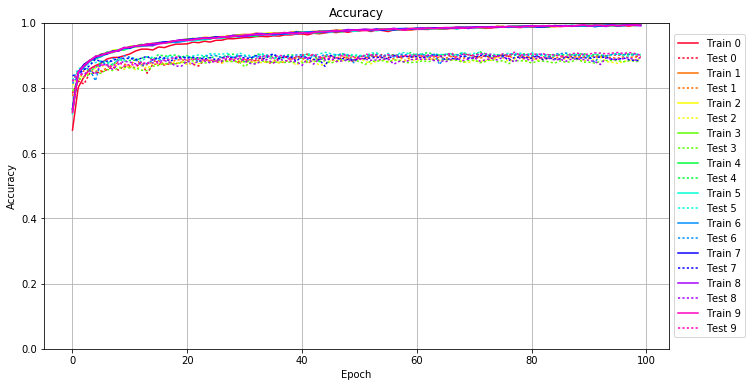

In [17]:
plot_acc(tophistory)

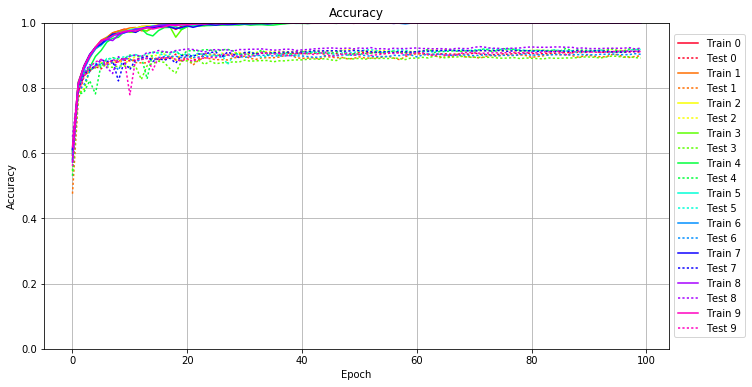

In [18]:
plot_acc(history)

In [19]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

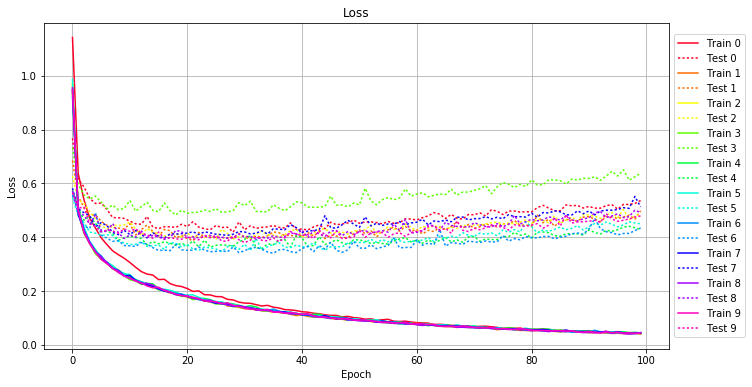

In [20]:
plot_loss(tophistory)

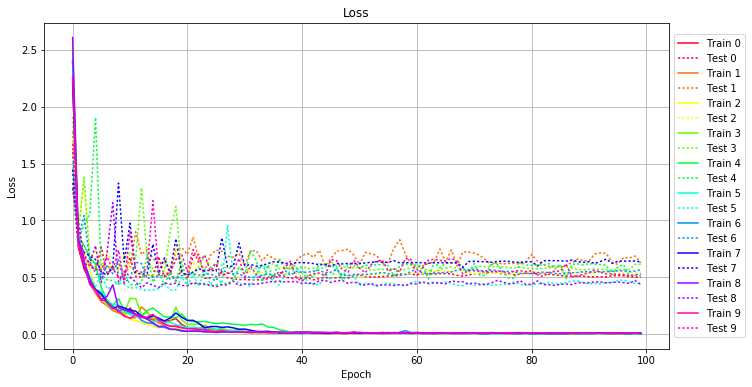

In [21]:
plot_loss(history)

Plotting the confusion matrix


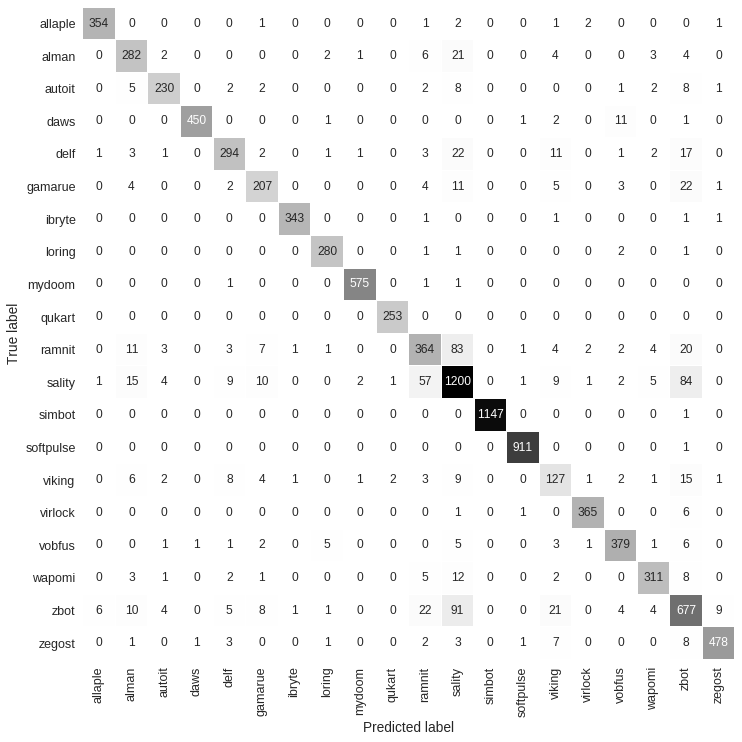

In [35]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


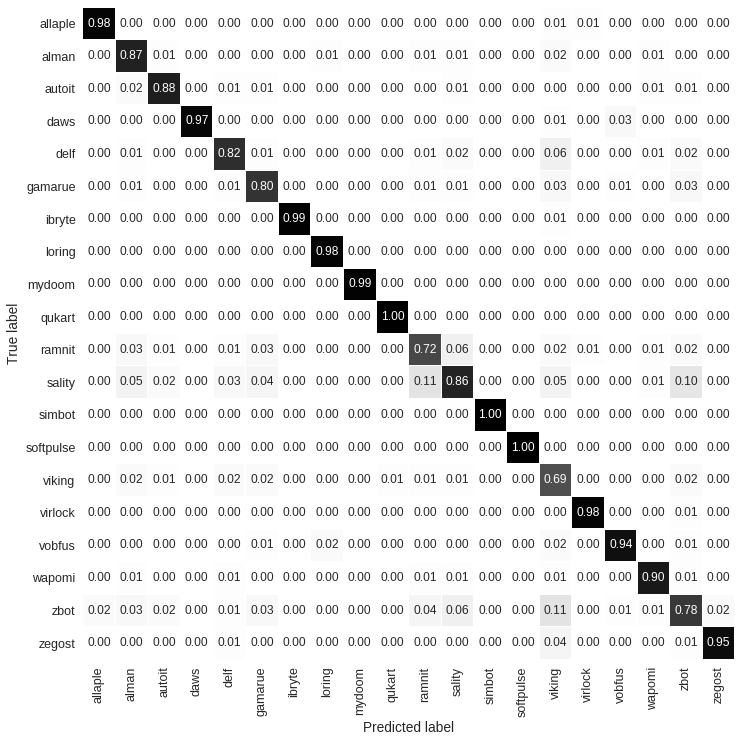

In [36]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
for h in tophistory:
    print(h.history)

{'acc': [0.67043459179947729, 0.80136084284460052, 0.83362598781317765, 0.85776997376576758, 0.86819578582932799, 0.875987708568573, 0.88838893766461813, 0.89310798956910387, 0.8935469711318782, 0.89859525899912207, 0.90408252863846295, 0.91319139601370025, 0.91867866560071054, 0.91878841088674279, 0.91615452161475797, 0.92548287982371313, 0.92350746273889783, 0.92943371378402106, 0.93393327480245825, 0.93426251097453905, 0.93492098337103124, 0.94018876217665437, 0.93854258126391976, 0.94293239683933272, 0.94051799829640448, 0.94578577710202749, 0.94611501316944691, 0.95072431968323901, 0.95050482890185184, 0.95226075510061869, 0.95434591747146624, 0.95434591752379683, 0.95719929762949951, 0.95785777007832251, 0.95687006150974951, 0.95961369627708926, 0.95873573309920979, 0.96246707648745333, 0.96224758560140478, 0.96477172958735735, 0.96532045654082532, 0.96279631255487275, 0.96751536435469709, 0.96586918354662388, 0.96861281836629443, 0.97091747157085972, 0.96949078149184309, 0.97311

In [25]:
for h in history:
    print(h.history)

{'acc': [0.59339332748024587, 0.81738366988586475, 0.86556189645268189, 0.90057067608393737, 0.92438542581211591, 0.94348112389746208, 0.95346795445057886, 0.96872256370465726, 0.97355136084284455, 0.98002633889376645, 0.97552677787532927, 0.98222124670763833, 0.98814749780509215, 0.98880597025391515, 0.98825724319578578, 0.99078138728639975, 0.99045215111431895, 0.98858647942019728, 0.97925812115891131, 0.98880597025391515, 0.9935250220014088, 0.99396400351185255, 0.99506145752344977, 0.99143985957823055, 0.99571992986761126, 0.9964881476024664, 0.99637840210711148, 0.99758560140474095, 0.99725636533732154, 0.99835381913959609, 0.99813432835820892, 0.99780509218612823, 0.99890254609306406, 0.99879280070237053, 0.99835381913959609, 0.99868305531167689, 0.99857330992098337, 0.99758560140474095, 0.9993415276558385, 0.99879280070237053, 0.99868305541633828, 0.99802458307217667, 0.99923178226514486, 0.99923178226514486, 0.9993415276558385, 0.99945127304653203, 0.9990122914837577, 0.9995610

In [26]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

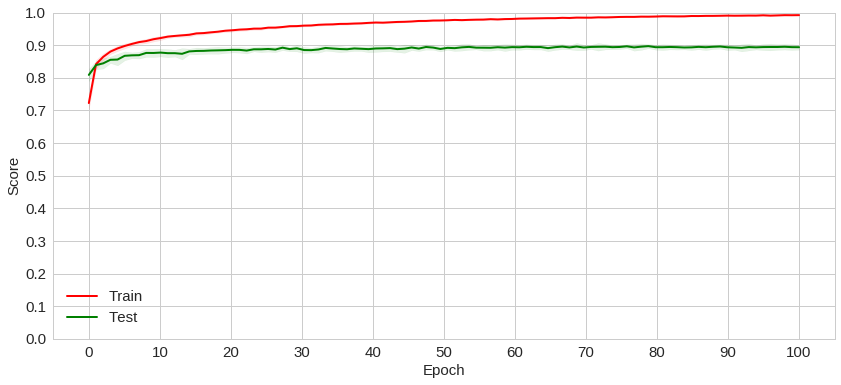

In [27]:
plot_mean_acc(tophistory)

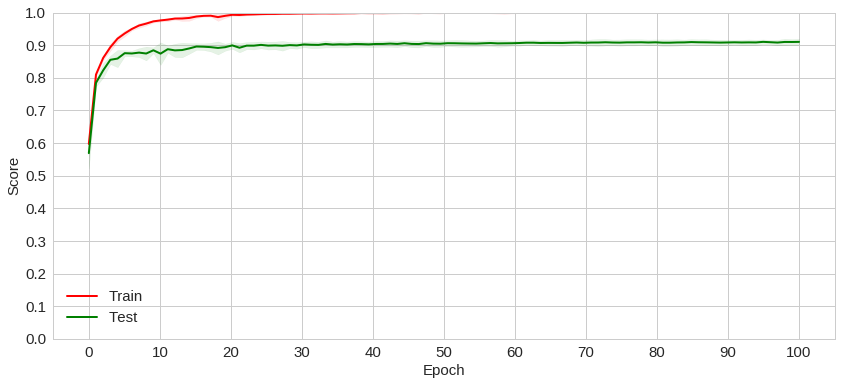

In [28]:
plot_mean_acc(history)

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

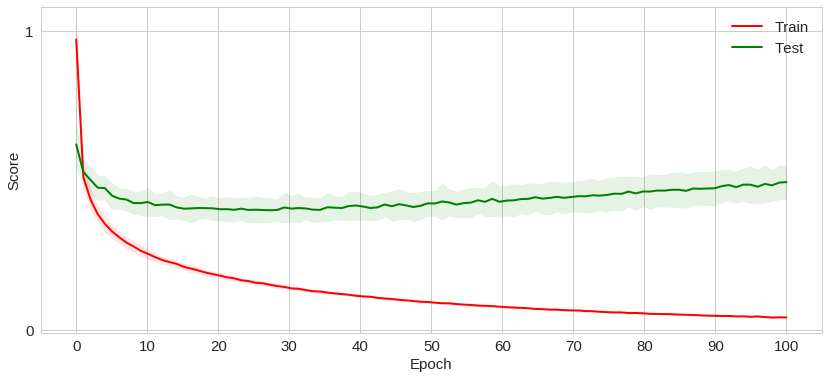

In [30]:
plot_mean_loss(tophistory)

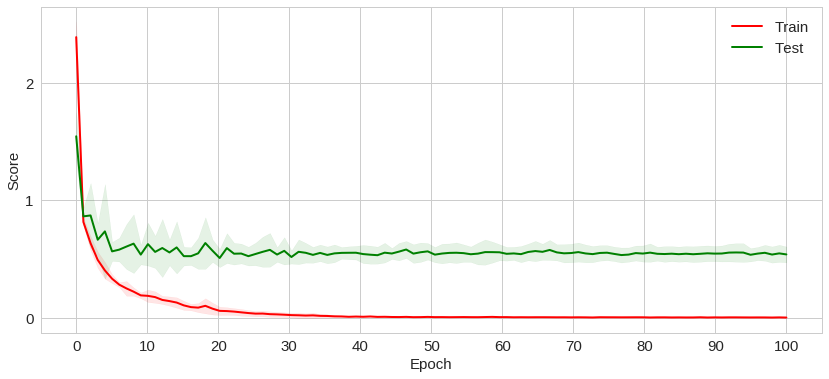

In [31]:
plot_mean_loss(history)

In [37]:
tophistory = [{'acc': [0.67043459179947729, 0.80136084284460052, 0.83362598781317765, 0.85776997376576758, 0.86819578582932799, 0.875987708568573, 0.88838893766461813, 0.89310798956910387, 0.8935469711318782, 0.89859525899912207, 0.90408252863846295, 0.91319139601370025, 0.91867866560071054, 0.91878841088674279, 0.91615452161475797, 0.92548287982371313, 0.92350746273889783, 0.92943371378402106, 0.93393327480245825, 0.93426251097453905, 0.93492098337103124, 0.94018876217665437, 0.93854258126391976, 0.94293239683933272, 0.94051799829640448, 0.94578577710202749, 0.94611501316944691, 0.95072431968323901, 0.95050482890185184, 0.95226075510061869, 0.95434591747146624, 0.95434591752379683, 0.95719929762949951, 0.95785777007832251, 0.95687006150974951, 0.95961369627708926, 0.95873573309920979, 0.96246707648745333, 0.96224758560140478, 0.96477172958735735, 0.96532045654082532, 0.96279631255487275, 0.96751536435469709, 0.96586918354662388, 0.96861281836629443, 0.97091747157085972, 0.96949078149184309, 0.97311237928007022, 0.970478489903424, 0.97388059701492535, 0.97464881474978049, 0.97717295884039446, 0.97278314310798941, 0.97761194035083809, 0.97585601404740996, 0.97267339771729588, 0.97783143107989468, 0.97717295873573307, 0.9772827041264267, 0.97794117657524959, 0.97936786660193564, 0.97947761194029848, 0.97914837587287906, 0.98222124670763833, 0.98035557506584725, 0.98046532045654078, 0.98222124670763833, 0.98178226514486389, 0.98309920993784838, 0.9840869183494293, 0.98375768222967919, 0.98386742767270352, 0.98233099209833186, 0.98386742756804213, 0.9854038630377524, 0.98836698858647942, 0.98595259009588176, 0.98628182621563187, 0.98485513618894582, 0.98694029850746268, 0.98694029861212407, 0.98858647936786659, 0.98606233538191401, 0.98781826168534215, 0.98781826163301145, 0.98979367866549606, 0.98902546093064092, 0.98902546093064092, 0.990891132572432, 0.99012291483757686, 0.98968393327480242, 0.99045215100965756, 0.98924495171202809, 0.99067164179104472, 0.99111062335381916, 0.98913520632133456, 0.99122036874451269, 0.98935469710272173, 0.99231782265144863, 0.99220807736541639], 'loss': [1.1424529798413914, 0.63650535427759991, 0.53931726817502801, 0.47020545939377673, 0.43388810651777499, 0.39762372333193369, 0.37240469220230932, 0.34923020473585725, 0.33477579856567785, 0.32172108724831072, 0.30593688720616463, 0.28824947951026292, 0.27196216685296781, 0.26274199727546549, 0.25915190038501013, 0.24220365718909792, 0.24335243840087811, 0.22743292725575504, 0.21989947147961769, 0.21649858763701463, 0.20900546024775066, 0.19812675653789208, 0.20040211663683638, 0.18603045456078723, 0.18531137817360205, 0.17917018254877079, 0.17863754094745948, 0.16892146645563544, 0.16661809485559406, 0.15845964480063912, 0.15480087951309751, 0.1540825750557763, 0.14897100308205183, 0.14406234996035186, 0.146504484973946, 0.13970938904490568, 0.13668888016449349, 0.13080169407681899, 0.12956412643508183, 0.12702585067485539, 0.12266114386840281, 0.12120752737148484, 0.11710076566533732, 0.11532664746438546, 0.11114782225782145, 0.10935291715940956, 0.10898002948124645, 0.10361681330402867, 0.10564287745371735, 0.10086306246672941, 0.099160445525365723, 0.095133326143104852, 0.09632160971832443, 0.091883686234597264, 0.092892574530693398, 0.094691648941954781, 0.087527448718646206, 0.086593475243480614, 0.087616114408641241, 0.084667326825244887, 0.08223517122003883, 0.081252787968665488, 0.08044388450688704, 0.075162947668487093, 0.076130480290479682, 0.074529798228794075, 0.071677698504385767, 0.072102536435081202, 0.069503639544228696, 0.068518212660362163, 0.067340213651715719, 0.068371899975455577, 0.068925917606483533, 0.066921743223340602, 0.064605117311882704, 0.060326138066489308, 0.063701732965599972, 0.061122901718065968, 0.061950497348859081, 0.058017752870027701, 0.057108976653367415, 0.0570314779952888, 0.059255699986057182, 0.0562003803381384, 0.055827216744828476, 0.05156428371151358, 0.05242626847416372, 0.050915992696940429, 0.049225941634000236, 0.049951175932590117, 0.050553724863112652, 0.048977093305029924, 0.047628650371446431, 0.049520526248127666, 0.045697952305883353, 0.048903140788072029, 0.045236652093932121, 0.045038950434109951, 0.043768503782490663, 0.041527043141692851], 'val_acc': [0.783203125, 0.8212890625, 0.8115234375, 0.8447265625, 0.845703125, 0.8486328125, 0.85546875, 0.8642578125, 0.8544921875, 0.8671875, 0.8642578125, 0.8623046875, 0.87890625, 0.8447265625, 0.8720703125, 0.873046875, 0.8701171875, 0.8740234375, 0.8740234375, 0.87890625, 0.876953125, 0.8720703125, 0.8671875, 0.8857421875, 0.8818359375, 0.8798828125, 0.876953125, 0.8857421875, 0.884765625, 0.8818359375, 0.88671875, 0.87890625, 0.884765625, 0.8935546875, 0.8759765625, 0.8779296875, 0.8916015625, 0.89453125, 0.8916015625, 0.892578125, 0.900390625, 0.9033203125, 0.8974609375, 0.892578125, 0.890625, 0.8876953125, 0.880859375, 0.89453125, 0.8916015625, 0.87890625, 0.8994140625, 0.892578125, 0.900390625, 0.8916015625, 0.9033203125, 0.892578125, 0.9033203125, 0.8935546875, 0.8984375, 0.89453125, 0.90234375, 0.900390625, 0.8974609375, 0.8857421875, 0.8955078125, 0.90234375, 0.896484375, 0.8984375, 0.9033203125, 0.90234375, 0.8955078125, 0.8955078125, 0.8984375, 0.890625, 0.896484375, 0.9013671875, 0.896484375, 0.9072265625, 0.8984375, 0.8916015625, 0.8955078125, 0.896484375, 0.8896484375, 0.89453125, 0.8984375, 0.9013671875, 0.8935546875, 0.8974609375, 0.8984375, 0.8974609375, 0.896484375, 0.8984375, 0.8974609375, 0.8984375, 0.9013671875, 0.900390625, 0.9013671875, 0.9013671875, 0.8974609375, 0.896484375], 'val_loss': [0.76785558764822781, 0.61567576124798506, 0.58697678777389228, 0.54423319920897484, 0.52539277786854655, 0.52703548670979217, 0.50313604297116399, 0.47287503161351196, 0.47204142210830469, 0.46977858917671256, 0.45924588784691878, 0.44990728358970955, 0.44785588773083873, 0.47688357171136886, 0.4372417880804278, 0.43184684780862881, 0.43859257876465563, 0.43862032915785676, 0.43605933153594378, 0.44799999659880996, 0.43960331173730083, 0.4575777033023769, 0.43730140610568924, 0.43128737648657989, 0.42769679173943587, 0.44340137064864393, 0.43580271622340661, 0.43738958650646964, 0.41867026404725038, 0.45664242048223969, 0.42764715538578457, 0.44230094876911608, 0.43293077367343358, 0.43643812262052961, 0.43823139748201356, 0.44331527194663067, 0.43651591690468194, 0.43397730753349606, 0.45316983374141273, 0.42867301411024528, 0.43022516389646626, 0.42659683243800828, 0.43797621034900658, 0.44542125414227485, 0.43133454501730739, 0.45558936091492797, 0.44607981329045288, 0.44915387434957665, 0.45293823635802255, 0.46373283653701947, 0.45166803714346315, 0.45663808684093965, 0.45684328485185688, 0.45416193981691322, 0.44940809382342195, 0.4583260825893376, 0.45149699302783119, 0.45388644145623402, 0.46819721993801977, 0.46714988306484884, 0.46381584631853912, 0.47253611544738305, 0.47928339423060606, 0.49138444793334202, 0.48569139493201874, 0.46932368847888029, 0.484850484026083, 0.47027311494321111, 0.46695293705397489, 0.48440515494485226, 0.4831371705630545, 0.49030218312373108, 0.47847116573552739, 0.50218685931861273, 0.49605910369677986, 0.48400807629536757, 0.4969260419402417, 0.49710435280894671, 0.49315894424194084, 0.49452799574191886, 0.49396295108317645, 0.50997244177926859, 0.51829539784876033, 0.50801577946253929, 0.49790250205649045, 0.49799562497901206, 0.51997385225541848, 0.51659664051135223, 0.5182679035244746, 0.50835122613057138, 0.51422936739527358, 0.50795973234573921, 0.50797908238791933, 0.51735690877194429, 0.52071143469947856, 0.50401978207719367, 0.52171508237927355, 0.52179810962093143, 0.52531250384163286, 0.5362045477177162]},
{'acc': [0.73315777934536697, 0.8463901690754525, 0.86548167664622278, 0.88424402029335902, 0.89466754454176811, 0.90344524926356584, 0.9073952163340937, 0.91112574080194542, 0.9127715604201152, 0.92045205181461687, 0.92440201896362351, 0.92593811718235686, 0.92714505167365313, 0.9320825104235243, 0.93383805154576904, 0.93723941198534833, 0.93998244477385673, 0.94217687074829937, 0.94294492000808361, 0.9464560017555409, 0.9491990345440493, 0.95018652631495115, 0.95183234593312105, 0.95490454255370472, 0.95413649349011742, 0.95600175554092603, 0.95292955892034237, 0.95995172262453365, 0.95973228000877775, 0.96280447662936142, 0.96412113232389729, 0.96357252578450736, 0.96774193557542953, 0.96598639464938174, 0.96620583717357911, 0.96796137828274409, 0.9670836077281616, 0.96598639464938174, 0.97081413219601331, 0.97256967303050257, 0.97136273864384459, 0.97136273864384459, 0.97333772227720705, 0.97300855826201449, 0.974215492740231, 0.97531270581901086, 0.97750713197657069, 0.97597103357472026, 0.97673908291298328, 0.97564186974264488, 0.97630019749835417, 0.97630019749835417, 0.97838490234803599, 0.97750713188501204, 0.97915295150318193, 0.98068904990503236, 0.98134737766074176, 0.98123765635286375, 0.97992100074988642, 0.97772657450076805, 0.98244459073952162, 0.98178626289225368, 0.98299319727891155, 0.98398068914137204, 0.98441957428132543, 0.98376124643405749, 0.98343208251042358, 0.98606539389949532, 0.984858459604396, 0.98310291858678955, 0.98485845951283735, 0.98705288567039717, 0.98485845951283735, 0.98474873830959775, 0.98913759052007899, 0.9885889840722476, 0.98595567259161732, 0.98815009874917714, 0.98990563985834212, 0.98957647575159091, 0.99089313144612678, 0.99012508229098095, 0.98902786921220098, 0.98902786921220098, 0.99056396752249287, 0.9911125740618828, 0.99023480359885885, 0.98858898398068906, 0.99089313153768543, 0.99100285293712198, 0.9927583936800527, 0.99144173798551682, 0.99199034461646529, 0.99056396752249287, 0.9929778362958086, 0.99210006583278476, 0.99210006583278476, 0.99363616423463519, 0.99220978714066277, 0.9927583936800527], 'loss': [0.93969484409638238, 0.50305416273631254, 0.43177112196002948, 0.37783115790919408, 0.34465095744154972, 0.31824062759085708, 0.3036404128513604, 0.28753784520926379, 0.27893409834034694, 0.26015353133496888, 0.25161746071047864, 0.24050000778854952, 0.23180790905735851, 0.22136693527778564, 0.22103341459730935, 0.20845317954370424, 0.20000429798080285, 0.19246736070599399, 0.19110908380380345, 0.18564973252631081, 0.17659244597258997, 0.17172123991739391, 0.16934234046127702, 0.16410559544653283, 0.1584226322070742, 0.15389289212856005, 0.1580066542327731, 0.14394071440680237, 0.14348959734441419, 0.13897649513748436, 0.13403044460189689, 0.13350755851719889, 0.12892031096067505, 0.12733749731711344, 0.12526071352840437, 0.12088294446612231, 0.12079740943996588, 0.1185687544306224, 0.11331328465334543, 0.10825746778675881, 0.11075806176784087, 0.10537178150284361, 0.10258596655842189, 0.10352927276654962, 0.10120145361465871, 0.098126008835230219, 0.094959246576329398, 0.094857747589898317, 0.090328367827151562, 0.0932951743698366, 0.091060943569638939, 0.090143897031741055, 0.086412437922315746, 0.084631654367076481, 0.084872406617784696, 0.082086242624207606, 0.079586097188678151, 0.078545919011494353, 0.080478547783909796, 0.080394650866077846, 0.075340043366713988, 0.073253852740136155, 0.073777407806694492, 0.071624285285805625, 0.068818746211891352, 0.067481981916158951, 0.067686820054083038, 0.064216149967210395, 0.066953934634270726, 0.067449813866029315, 0.063986098049226919, 0.060778273497204362, 0.063490183497105668, 0.061278106881412255, 0.055919573084582667, 0.057631095424572419, 0.062906707757387034, 0.055779083181701522, 0.053339028326740957, 0.052973804755076286, 0.052058340551195528, 0.052685276841442717, 0.053092804806262404, 0.052953060565972918, 0.049685772125798673, 0.047819119348177029, 0.049568697962225697, 0.052047717769417502, 0.048321918912014469, 0.047055229227454455, 0.044815299648686094, 0.044993654632479417, 0.045150342690256674, 0.043371919847473857, 0.042220965368701409, 0.042456907414542444, 0.041815656909687637, 0.040661196764137549, 0.041974415025324945, 0.040132106084598114], 'val_acc': [0.77495107293828824, 0.82191780938560943, 0.85322896118499991, 0.85225048760378663, 0.85127201495571847, 0.85225048853693175, 0.86105674983470637, 0.87279843280926606, 0.87671232713411928, 0.87279843280926606, 0.86790606490319955, 0.88747553652746569, 0.87279843280926606, 0.8708414856468395, 0.88062622145897251, 0.88356164220261246, 0.87181995922805278, 0.87377690639047945, 0.88649706294625241, 0.88551858936503913, 0.88454011578382574, 0.88943248368989236, 0.88454011578382574, 0.88356164220261246, 0.88454011578382574, 0.88551858843189402, 0.88258316862139918, 0.89041095727110564, 0.88845401010867897, 0.87573385355290601, 0.88649706294625241, 0.88649706294625241, 0.8816046950401859, 0.88845401010867897, 0.89432485159595887, 0.8864970620131073, 0.87671232713411928, 0.87964774787775923, 0.88845401010867897, 0.88943248368989236, 0.89334637614845525, 0.87475537997169273, 0.88747553652746569, 0.88845401010867897, 0.8982387459208121, 0.89334637708160047, 0.89041095727110564, 0.89823874498766698, 0.8923679044335322, 0.89334637801474559, 0.89041095727110564, 0.88845400917553385, 0.8972602714064537, 0.8972602714064537, 0.89236790350038708, 0.88649706294625241, 0.88943248368989236, 0.89530332331088192, 0.88356164220261246, 0.89530332517717215, 0.89041095633796052, 0.89628179782524031, 0.89236790350038708, 0.89530332424402703, 0.89334637708160047, 0.89041095540481541, 0.89628179782524031, 0.8913894299191738, 0.8913894299191738, 0.89236790350038708, 0.89432485159595887, 0.89041095633796052, 0.8972602714064537, 0.89041095633796052, 0.89628179782524031, 0.89530332331088192, 0.89823874498766698, 0.88943248182360202, 0.8972602714064537, 0.89628179782524031, 0.89236790350038708, 0.88747553559432057, 0.89530332424402703, 0.89432485066281375, 0.89236790350038708, 0.89432485066281375, 0.89530332424402703, 0.89530332424402703, 0.89432484972966864, 0.89334637708160047, 0.89628179782524031, 0.89628179782524031, 0.89334637708160047, 0.89530332331088192, 0.89236790256724197, 0.8913894299191738, 0.89530332424402703, 0.89334637614845525, 0.89432485066281375, 0.89334637708160047], 'val_loss': [0.68509206470328066, 0.55085630593147061, 0.50988946059707796, 0.4791005524440346, 0.48406113564618181, 0.45895703791216047, 0.444007923035589, 0.43611118479207189, 0.43396958285567228, 0.43001542514857133, 0.45042243261626558, 0.40793629203159398, 0.4279534464242728, 0.44542555223581781, 0.42048214369684955, 0.40400910648150978, 0.42850584335399178, 0.42434109160457895, 0.39809368626959984, 0.40634127698999095, 0.39603108240550278, 0.38619543793984851, 0.41757017090085552, 0.39920047785696772, 0.40036603077469712, 0.40040114151729445, 0.39800466698026665, 0.39795643232631589, 0.39655986393450116, 0.41390937053891896, 0.39968298356241955, 0.39307335662198073, 0.40436637202307851, 0.39897370270117133, 0.40458713340825436, 0.41943292053409081, 0.4163989973848653, 0.40576466660214855, 0.40660633547131314, 0.40325129189990538, 0.40534327124722064, 0.41755222475589954, 0.40408942892196553, 0.42055976918808308, 0.39446957139530697, 0.40827118676995772, 0.40405060922059027, 0.39702819246200044, 0.39974936294969016, 0.41251424979224871, 0.42765011660074187, 0.41267460636007908, 0.42372712421328024, 0.40081999653224959, 0.42437446687676728, 0.42712726337739965, 0.43783680349542831, 0.42197310564508245, 0.43993034746130855, 0.42248986614606054, 0.42769884697533872, 0.41192927013579989, 0.42563706756449382, 0.42054235633761566, 0.43785726429876115, 0.42711668652854812, 0.43935147863780849, 0.45736538525733417, 0.43387799776673697, 0.44727275556675228, 0.43279160536073741, 0.4387159553020607, 0.4495189898353083, 0.44287563789403922, 0.43878707417709878, 0.45079325825061572, 0.44735752831040976, 0.46223138286842913, 0.44437006182388733, 0.44526164199404955, 0.44152884252972041, 0.48223391523750003, 0.45350845180847821, 0.46683686714918526, 0.44023447599851595, 0.45821201606651096, 0.46589446041400184, 0.46373887418529319, 0.45938702319484315, 0.47462632552106321, 0.47623665082140437, 0.4667581868812497, 0.45772764376459862, 0.47629269313626577, 0.47474469236248229, 0.46946248803348117, 0.47486147331399592, 0.48179762909741353, 0.46666832141042652, 0.49808718327523727]},
{'acc': [0.72060114079894289, 0.84422992561511068, 0.86924089528636594, 0.88218516909066602, 0.8889863976473974, 0.90258885491778318, 0.90675734981940259, 0.91531373425082396, 0.91695919278526894, 0.91970162362370278, 0.92705133830627473, 0.92935498025449759, 0.93045195266310188, 0.93473014480035099, 0.93659499791067069, 0.93791136463361124, 0.93802106192154866, 0.94175076808988023, 0.9436156210955845, 0.94668714364090734, 0.95030715225976303, 0.9480035104161556, 0.95096533577815645, 0.95469504173725728, 0.95326897762176388, 0.95535322509872755, 0.95776656428258011, 0.95645019750733185, 0.96028960070206226, 0.96039929798999968, 0.96215445370776653, 0.96171566476524795, 0.96467749017955651, 0.96577446253585308, 0.96840719619096505, 0.96895568242142105, 0.96928477407600233, 0.96741992101799035, 0.96895568242142105, 0.9704914436156209, 0.97125932431733619, 0.97191750767880647, 0.9707108381391879, 0.97213690220237359, 0.9716981133121626, 0.97246599385695476, 0.97498903032874473, 0.9772926722769677, 0.97740236951259729, 0.97586660826608973, 0.9772926722769677, 0.97970601156543569, 0.97751206669591928, 0.97608600263273371, 0.978938130732951, 0.97827994739763457, 0.97959631417288284, 0.9776217639838567, 0.98135146994295741, 0.98266783677051339, 0.98025449758666083, 0.98376480917911768, 0.98168056170215412, 0.98343571747222869, 0.98365511194348809, 0.98277753400614309, 0.98486178148310666, 0.98321632294866168, 0.98617814831066253, 0.98584905665608136, 0.9821193505923651, 0.98475208424747696, 0.98628784559859994, 0.98628784565090766, 0.98562966223712967, 0.98650724001755152, 0.98727512066695922, 0.98716542348363723, 0.98760421237384821, 0.98672663448881093, 0.9884817902588855, 0.98913997367266349, 0.98881088196577449, 0.98760421237384821, 0.9880430013163668, 0.98815269860430421, 0.99034664326458977, 0.99012724879333036, 0.98990785437437878, 0.99133391843756435, 0.99089512949504577, 0.99188240456340504, 0.99089512944273805, 0.99286967973637963, 0.99210179903466433, 0.99089512944273805, 0.99221149627029404, 0.99308907420763903, 0.99297937697200933, 0.99243089074155333], 'loss': [0.97329154355633729, 0.50726331729227747, 0.42734760831928714, 0.37690414185584664, 0.35241160774869112, 0.32129540503312748, 0.30295333574873778, 0.28630238113669043, 0.27193648071600818, 0.26350888037116654, 0.24589795701960923, 0.24012993068522975, 0.23320112896886191, 0.22164488177110669, 0.21274415891700901, 0.2099090879092409, 0.20287072829846595, 0.1945072335990807, 0.19072632050242222, 0.18392264888756313, 0.17871065998794008, 0.17703190497553836, 0.16891027733964739, 0.16276748771008925, 0.16049290955812065, 0.1584260090106723, 0.15287043198701214, 0.14904856177708098, 0.14775250353550062, 0.14414865279365077, 0.13833701910190332, 0.13722101523458774, 0.13200507363032332, 0.1286764943505547, 0.12471889033946305, 0.12187987300532593, 0.12001621443001834, 0.12301796204939701, 0.11834529261282527, 0.11348879713272515, 0.11111833212693671, 0.11063708523194379, 0.10914310082930544, 0.10652841111712939, 0.10381197732247611, 0.10476749672825371, 0.10030754413676397, 0.094587570673386842, 0.093016057990788895, 0.097047430896717191, 0.091345702715221341, 0.089070071876964432, 0.089902004173917166, 0.090015273108038793, 0.083156437780209522, 0.085461191813403864, 0.084412166385365028, 0.082586664132718299, 0.079607060031181578, 0.077609642104340945, 0.079250450769521891, 0.073128948561085483, 0.076849077792675566, 0.073592094520614465, 0.070168047103770947, 0.070260126277732454, 0.067579544227392124, 0.067923838930623787, 0.066368681262400503, 0.06590797667468834, 0.070583300606992069, 0.06557345467964093, 0.063040684079878048, 0.062150855540915401, 0.060863266399472676, 0.061440426071663605, 0.058340851961258683, 0.058209949454595879, 0.059222577199398711, 0.058828488197226685, 0.056175252294373021, 0.055430890963678037, 0.055226227980451972, 0.055103521831676903, 0.054764246124489796, 0.054878330514482258, 0.051560725541086559, 0.050090306355548876, 0.049367522430974385, 0.047943587069607663, 0.048532567084646372, 0.046717406158589284, 0.04729979100321248, 0.045741583470348311, 0.046059938128048677, 0.048233425708102677, 0.044843091354421376, 0.043037112189286006, 0.043255246257039213, 0.044704432246578059], 'val_acc': [0.80784314379972566, 0.83823529809129005, 0.83137255462945681, 0.85098039870168651, 0.86078431769913322, 0.86666667227651562, 0.86862745752521586, 0.87058824090396658, 0.86666667064030967, 0.85686274650050143, 0.8686274565902411, 0.85490196475795666, 0.86862745752521586, 0.85882353338540773, 0.87450980953141755, 0.87254902521769206, 0.87254902615266683, 0.87941177031573126, 0.87549020168828029, 0.87941177031573126, 0.87156863306082932, 0.87745098600200577, 0.87352941573834886, 0.88627451541377045, 0.87941177031573126, 0.88431373110004496, 0.87549020168828029, 0.8833333398781571, 0.880392162472594, 0.88529412325690771, 0.87745098693698065, 0.87941177031573126, 0.87843137815886851, 0.87745098693698065, 0.87941177031573126, 0.88137255462945674, 0.87745098600200577, 0.88333333894318222, 0.88235294678631948, 0.86960784874710384, 0.88235294678631948, 0.88333333894318222, 0.88333333894318222, 0.86960784874710384, 0.87156863306082932, 0.88431373110004496, 0.88333333894318222, 0.88235294678631948, 0.89117647713305903, 0.88627451541377045, 0.88921569188435867, 0.88235294772129436, 0.87352941737455481, 0.88235294678631948, 0.88627451634874532, 0.87941177125070613, 0.88431373110004496, 0.88529412325690771, 0.88235294772129436, 0.88627451541377045, 0.88333333894318222, 0.88725490757063319, 0.88725490757063319, 0.88921569281933355, 0.88333333894318222, 0.88823529972749593, 0.88627451541377045, 0.88627451634874532, 0.88039216340756887, 0.87745098693698065, 0.88431373110004496, 0.880392162472594, 0.88431373203501984, 0.88431373203501984, 0.89313726144678451, 0.89215686835494701, 0.88137255462945674, 0.88921569281933355, 0.89509804576051, 0.88137255462945674, 0.89215686835494701, 0.88431373203501984, 0.88725490757063319, 0.89019608404122141, 0.89019608497619629, 0.88823530066247081, 0.88921569281933355, 0.89019608404122141, 0.89117647713305903, 0.880392162472594, 0.89019608404122141, 0.88431373203501984, 0.89411765360364726, 0.880392162472594, 0.87843137815886851, 0.87549020262325516, 0.880392162472594, 0.88431373203501984, 0.88627451634874532, 0.88823529972749593], 'val_loss': [0.62710695604191102, 0.5386811749096595, 0.52612623338971065, 0.49473897274583578, 0.46826882256085384, 0.44412033452707178, 0.42976625576323152, 0.44414402558376975, 0.44307465982787747, 0.44550997290541144, 0.45575490239825028, 0.43077333463246331, 0.40528935590101517, 0.43262920464735988, 0.41818386009145603, 0.41366801835852218, 0.40443931339381667, 0.40706210721868508, 0.41417548549635447, 0.40086368183495807, 0.41440324154591152, 0.4010576617538783, 0.40231275987473553, 0.39888850603544829, 0.40606805323394857, 0.39207265245746453, 0.42876297102090627, 0.41398172311521336, 0.3933314238054057, 0.40147589253827781, 0.40587142377489194, 0.39465754714557061, 0.4103931560637612, 0.42406065313090735, 0.40875581102445724, 0.40735634399621345, 0.40180002772751466, 0.40875157443989141, 0.4241809431956533, 0.42870379069308734, 0.40286078112446427, 0.40163775537067148, 0.41497544325504671, 0.42840375657508367, 0.43127717021304895, 0.41509647031597718, 0.41735841676720653, 0.41881253061480544, 0.41153536872783053, 0.42291198201379371, 0.42376857962557479, 0.42763411625774633, 0.44414071098755242, 0.4125002770777107, 0.41917207536992945, 0.43965281254369948, 0.4286772763167106, 0.43052034040298953, 0.4489794858373809, 0.43631388915776315, 0.42311803332807302, 0.44053921856798745, 0.4326727234144403, 0.4439406894365675, 0.43475569216865478, 0.42919739601904228, 0.43783742496378575, 0.43311623634344515, 0.44487966697973508, 0.43929275608799584, 0.44562256218013513, 0.4452568940682492, 0.44938156323692324, 0.45326346427158853, 0.45575231651112996, 0.44820257896022736, 0.45294572435294883, 0.44907911168872183, 0.45572512278284943, 0.46504835852692317, 0.45036451944678463, 0.46731415870381171, 0.46215950511571408, 0.45385193150459419, 0.47883212524423419, 0.45038208199044927, 0.46456428781192005, 0.47462092200436623, 0.4602738349391467, 0.48390646196933756, 0.4820930786581063, 0.47759930157186747, 0.46974591778956998, 0.48146222055069055, 0.49198186724248161, 0.47181567069602154, 0.50306012941653211, 0.46448472126595497, 0.47884640283593899, 0.4854056966555243]},
{'acc': [0.72839912280701757, 0.84539473684210531, 0.87116228070175439, 0.88464912280701757, 0.89561403508771931, 0.90241228070175439, 0.90416666666666667, 0.91304824561403508, 0.91688596491228069, 0.9201754385964912, 0.92664473684210524, 0.92785087719298243, 0.93366228070175439, 0.92905701754385961, 0.93377192982456136, 0.93793859649122802, 0.93793859649122802, 0.93826754385964917, 0.94199561403508769, 0.94660087719298247, 0.94605263157894737, 0.95219298245614037, 0.94890350877192986, 0.95241228070175443, 0.95296052631578942, 0.95690789473684212, 0.95504385964912286, 0.95690789473684212, 0.96107456140350878, 0.96173245614035086, 0.96107456140350878, 0.96118421052631575, 0.96052631578947367, 0.96666666666666667, 0.96513157894736845, 0.96557017543859647, 0.96622807017543855, 0.96853070175438594, 0.96699561403508771, 0.97061403508771926, 0.97192982456140353, 0.96754385964912282, 0.97072368421052635, 0.97401315789473686, 0.97335526315789478, 0.97258771929824561, 0.97620614035087716, 0.97510964912280707, 0.97631578947368425, 0.97620614035087716, 0.9765350877192982, 0.97730263157894737, 0.97730263157894737, 0.97927631578947372, 0.98124999999999996, 0.98059210526315788, 0.98157894736842111, 0.98026315789473684, 0.98201754385964912, 0.9804824561403509, 0.98234649122807016, 0.98278508771929829, 0.98508771929824557, 0.98234649122807016, 0.98355263157894735, 0.98366228070175443, 0.98464912280701755, 0.98464912280701755, 0.98519736842105265, 0.9860745614035088, 0.98552631578947369, 0.98629385964912286, 0.98596491228070171, 0.98640350877192984, 0.98760964912280702, 0.98706140350877192, 0.98739035087719296, 0.98991228070175441, 0.98804824561403504, 0.98859649122807014, 0.9888157894736842, 0.98804824561403504, 0.98969298245614035, 0.98760964912280702, 0.99035087719298243, 0.98969298245614035, 0.99013157894736847, 0.99144736842105263, 0.98991228070175441, 0.98936403508771931, 0.99024122807017545, 0.99177631578947367, 0.99199561403508774, 0.99067982456140347, 0.99111842105263159, 0.9916666666666667, 0.99144736842105263, 0.9922149122807018, 0.99155701754385961, 0.9944078947368421], 'loss': [0.96642810127191381, 0.49419567365395395, 0.41387537268170138, 0.37664948691401567, 0.33828194444639642, 0.31778720460439985, 0.30158168098382782, 0.28261837561925252, 0.27134395628644709, 0.25642935518632853, 0.24180635459590377, 0.23699330896661994, 0.22462957987659857, 0.22622433001534981, 0.21631207382469847, 0.20399858329379766, 0.20129441916942598, 0.20092398168747885, 0.18773402007002579, 0.17972977503872753, 0.17972673133277056, 0.16729072567663694, 0.17100003879321249, 0.16353654474542853, 0.1611328609157027, 0.15131695516276777, 0.15230363800860289, 0.14747602631125534, 0.14207580109829443, 0.14132953780262095, 0.13729115936316941, 0.13821536762672559, 0.13298459779797939, 0.1258810597292164, 0.12499715510690422, 0.12481593768063344, 0.12074362063094189, 0.11685762959614135, 0.1174341270798131, 0.11315935962555701, 0.11213435760715551, 0.11381580472776764, 0.10742727502396232, 0.10249347890678205, 0.10315736266866064, 0.10092994306693998, 0.097672451640430244, 0.095772292595683484, 0.093785069647588232, 0.091950473032499619, 0.090736164322547747, 0.088966818362997288, 0.089744793375333157, 0.086145180646787611, 0.082746598111432895, 0.081943133342684354, 0.080771750473139572, 0.07962421934332764, 0.077205548330880044, 0.079325856817396068, 0.075687132004583088, 0.075141489505767822, 0.070854628778863366, 0.074153924105983038, 0.071703770573724776, 0.069700084195325251, 0.06963922948690883, 0.068902887417036193, 0.065404181509164341, 0.064286755463271811, 0.065011642285083465, 0.062994770195923352, 0.062256326173481188, 0.061899268398420852, 0.060339414792364106, 0.060394215992276082, 0.058900098424208791, 0.056267167176855239, 0.058192657195685206, 0.054555247864571582, 0.054811427977524307, 0.054345971685752531, 0.051771137438583789, 0.05655403179034852, 0.051980454079283957, 0.053381762941155514, 0.050910207125962829, 0.048837937983243089, 0.049619641449106369, 0.051118315641948006, 0.048104821537670338, 0.048489416357979438, 0.045400053877056694, 0.047941921952000838, 0.045367613183171077, 0.046454296973452235, 0.045063539319916773, 0.043329589879303645, 0.044619965559819286, 0.040731510386001646], 'val_acc': [0.79035432883134982, 0.82283464660794714, 0.83464566976066645, 0.841535433540194, 0.84842519731972166, 0.84448818944570592, 0.85629921353708105, 0.85334645716224133, 0.86023622141109679, 0.86318897684728069, 0.86122047291027282, 0.86122047244094491, 0.85433070913074527, 0.8523622051937374, 0.8661417332221204, 0.86909448912763221, 0.87500000046932791, 0.87401575178611934, 0.87401574803149606, 0.8769685053449916, 0.88090551228035152, 0.88287401621735939, 0.87992126031184759, 0.87598425337648766, 0.87893700928199947, 0.88385826818586333, 0.8828740166866873, 0.88090551181102361, 0.88090551228035152, 0.8799212607811755, 0.86515748078428856, 0.87795275684416763, 0.87500000140798373, 0.8828740166866873, 0.87893700834334365, 0.87795275684416763, 0.8799212607811755, 0.87795275684416763, 0.87893700834334365, 0.87795275731349554, 0.8769685053449916, 0.8799212607811755, 0.88188976471818337, 0.88090551274967943, 0.88287401715601521, 0.87598425337648766, 0.88188976518751128, 0.88779527699853489, 0.88090551228035152, 0.88484252109302308, 0.88090551274967943, 0.8720472445638161, 0.88188976518751128, 0.88188976753415083, 0.88385826912451915, 0.87893700881267156, 0.88582677540816657, 0.88385826865519124, 0.8769685053449916, 0.87795275731349554, 0.87893700881267156, 0.8828740166866873, 0.87992126125050341, 0.88484252062369517, 0.88582677259219911, 0.88582677306152702, 0.88484252062369517, 0.88484252343966263, 0.87795275731349554, 0.88385826912451915, 0.88582677306152702, 0.87696850487566369, 0.88090551274967943, 0.88779527699853489, 0.87992126125050341, 0.88385826912451915, 0.87401574943947979, 0.88385826912451915, 0.8828740166866873, 0.88287401715601521, 0.87598425337648766, 0.88188976518751128, 0.88188976518751128, 0.8799212607811755, 0.87598425243783185, 0.88287401715601521, 0.87795275684416763, 0.88090551321900734, 0.88779527699853489, 0.87893700928199947, 0.87893700881267156, 0.87598425290715975, 0.88090551274967943, 0.88385826912451915, 0.88385826912451915, 0.88385826912451915, 0.8799212607811755, 0.8828740166866873, 0.88188976471818337, 0.87992126125050341], 'val_loss': [0.73294345909861602, 0.59587983562845703, 0.5572858878409519, 0.54205130946508051, 0.55283002203145237, 0.53032248711278096, 0.50501325301089006, 0.51933906972958288, 0.50150253860404581, 0.50690940236966087, 0.53600026567065062, 0.49646730751521506, 0.51364534967817277, 0.52968870517046107, 0.49949889620912707, 0.49437428144078088, 0.52751356004150662, 0.4982612237204086, 0.48242991762744503, 0.50009565236776565, 0.48886260594054326, 0.49181746279840965, 0.49302211192145018, 0.50091168907077754, 0.49543187913336373, 0.50614749555229432, 0.49235221923970135, 0.49416359573970253, 0.49855757652672822, 0.52823672441909586, 0.51690123958547973, 0.53415378936686497, 0.49582211214920241, 0.49467819387413559, 0.4944078979877834, 0.52050149788189493, 0.50755616345815913, 0.49794126997974986, 0.51330893935876765, 0.53135632029844548, 0.52769698058706471, 0.51182404993545161, 0.51117141226865259, 0.51129331572333536, 0.51434084827902604, 0.55260120079885644, 0.5188525314435366, 0.51997471149160279, 0.51274018690378931, 0.52708070083732361, 0.52028925633604506, 0.58161850021548789, 0.53500708390867491, 0.52024272645698733, 0.53952552398120646, 0.54742863970857902, 0.53903164947355331, 0.54579934837169652, 0.57954100750186888, 0.5520992433224261, 0.560458906338409, 0.56517611761536835, 0.54992388129816339, 0.55564489161907826, 0.56064750632557714, 0.55828123317500233, 0.57857493589588871, 0.55613443855232669, 0.56779561922059918, 0.56751897540059182, 0.57404919193947901, 0.57994403455987187, 0.59204191032262043, 0.56122211992524673, 0.58738567022859078, 0.60318210104948566, 0.59673844131149356, 0.58404718235174657, 0.5966845722374331, 0.58790572167989619, 0.6132396600630351, 0.59423809505987024, 0.59488235117146715, 0.61358702686804578, 0.61245366119630384, 0.6096775330737062, 0.59774992101015989, 0.61576840493967744, 0.61236519607400697, 0.61887965218966923, 0.61851425611679656, 0.62435229305191031, 0.61117589214585966, 0.62709565608974671, 0.64502101915743837, 0.62711206872607028, 0.65037092668651675, 0.61194083137840294, 0.6242964913179212, 0.63762543548078099]},
{'acc': [0.73421052631578942, 0.84495614035087718, 0.86787280701754388, 0.8816885964912281, 0.88870614035087714, 0.89594298245614035, 0.90986842105263155, 0.90800438596491229, 0.91633771929824559, 0.91578947368421049, 0.92313596491228067, 0.92697368421052628, 0.92785087719298243, 0.93048245614035086, 0.92872807017543857, 0.93958333333333333, 0.93848684210526312, 0.9396929824561403, 0.94122807017543864, 0.94572368421052633, 0.94835526315789476, 0.949780701754386, 0.94879385964912277, 0.94714912280701757, 0.94989035087719298, 0.95471491228070171, 0.95285087719298245, 0.95449561403508776, 0.95690789473684212, 0.9575657894736842, 0.96063596491228065, 0.95833333333333337, 0.95833333333333337, 0.96239035087719293, 0.96480263157894741, 0.96546052631578949, 0.96732456140350875, 0.96491228070175439, 0.96787280701754386, 0.97105263157894739, 0.96907894736842104, 0.97225877192982457, 0.96907894736842104, 0.96853070175438594, 0.97116228070175437, 0.97302631578947374, 0.97324561403508769, 0.97182017543859645, 0.97598684210526321, 0.97587719298245612, 0.97675438596491226, 0.9770833333333333, 0.97587719298245612, 0.97872807017543861, 0.97730263157894737, 0.97960526315789476, 0.97916666666666663, 0.97807017543859653, 0.98179824561403506, 0.98059210526315788, 0.9826754385964912, 0.98146929824561402, 0.98114035087719298, 0.98201754385964912, 0.98114035087719298, 0.98234649122807016, 0.98453947368421058, 0.98432017543859651, 0.98629385964912286, 0.98530701754385963, 0.98497807017543859, 0.98574561403508776, 0.98475877192982453, 0.98640350877192984, 0.987719298245614, 0.98782894736842108, 0.98541666666666672, 0.98651315789473681, 0.98925438596491233, 0.98815789473684212, 0.987719298245614, 0.98859649122807014, 0.9866228070175439, 0.98739035087719296, 0.99089912280701753, 0.98870614035087723, 0.99089912280701753, 0.99013157894736847, 0.99046052631578951, 0.98958333333333337, 0.98936403508771931, 0.98980263157894732, 0.99111842105263159, 0.99089912280701753, 0.99035087719298243, 0.98991228070175441, 0.99122807017543857, 0.99243421052631575, 0.99089912280701753, 0.99276315789473679], 'loss': [0.93534948323902334, 0.49284310069000514, 0.42432315098611934, 0.37975192885649833, 0.34820225636164348, 0.32783907965609904, 0.30375413706428128, 0.29292985624388646, 0.27421477729814092, 0.2648825828443494, 0.25124875764574922, 0.24245461879069344, 0.23296587597905544, 0.22790786367759369, 0.22683753705861276, 0.20816234909651571, 0.20340318742551303, 0.19975466733438926, 0.194997445324011, 0.1858936732536868, 0.18092108933549178, 0.17408275745416943, 0.17295607223845363, 0.17221011728571173, 0.16773512624857717, 0.15929055506722969, 0.15761496871709824, 0.15468994101934266, 0.15162133469916225, 0.14668979234339899, 0.14115702786989379, 0.14476376638600702, 0.14080661161426913, 0.1312302208260486, 0.12779676935128997, 0.12633974120805139, 0.12124547202859008, 0.12294895246363523, 0.11948423984280804, 0.11272540455847456, 0.11533445593035012, 0.10899657848895641, 0.11324074090572826, 0.11344385011154309, 0.10736383900307772, 0.10336035394616294, 0.10289493495957894, 0.10240559806687791, 0.097042939772731374, 0.094693662265413689, 0.093585941483054241, 0.091611634743841069, 0.091744485314477958, 0.088145163158575693, 0.087918431115777865, 0.085859491087888415, 0.084715201797192552, 0.085781543362036083, 0.080376942795619633, 0.079705988589608881, 0.076118753196900354, 0.079388817818018431, 0.076100585426677733, 0.073899486909310017, 0.07383296818456106, 0.07463311875859896, 0.071470869724687774, 0.070239660954266259, 0.066450699366498417, 0.067376377995599784, 0.069402633385177243, 0.065191963602576342, 0.065498379395719161, 0.061596953261055444, 0.061324598770915416, 0.060330558228388169, 0.06259898207428162, 0.061097777661001475, 0.058148600043434848, 0.057673500628586401, 0.058007587270255671, 0.057715042758929101, 0.0580618946698674, 0.058141185277909561, 0.052574625094993076, 0.05376588300589407, 0.050724753338778225, 0.050353265566784038, 0.050149623435317425, 0.050549640098031152, 0.051063196864305882, 0.049926030299250496, 0.048375921617997322, 0.046626945663439598, 0.04817111791487326, 0.048469090932293943, 0.048281667103762166, 0.04500171735948115, 0.046498544200470573, 0.043520061619449081], 'val_acc': [0.81988189257974697, 0.85236220847903277, 0.8592519713199045, 0.85334645669291342, 0.86122047244094491, 0.87795275590551181, 0.87795275872147926, 0.86909448725032057, 0.88976377858890321, 0.88188976659549501, 0.88385826771653542, 0.88484252250100681, 0.89074803149606296, 0.89566929133858264, 0.8868110226833914, 0.90255905793407776, 0.89665354612305403, 0.89960629921259838, 0.90059055399706989, 0.89468503937007871, 0.89862204630543863, 0.88976377952755903, 0.89074803431203042, 0.89566929133858264, 0.89074803431203042, 0.89862204724409445, 0.89271653824903829, 0.90157480314960625, 0.90354330990258169, 0.89271653543307083, 0.87992125890386386, 0.8838582667778796, 0.90354330990258169, 0.90255905511811019, 0.89960629921259838, 0.89468504218604616, 0.89074803055740714, 0.89862205006006191, 0.90255905699542194, 0.89566929133858264, 0.88976377952755903, 0.89960630202856584, 0.90059055399706989, 0.88090551087236779, 0.8956692941545501, 0.89763779527559051, 0.89763779809155797, 0.90452756187108563, 0.89763779809155797, 0.89862205099871784, 0.89763779809155797, 0.89960629921259838, 0.90157480596557382, 0.9064960658080935, 0.89271653824903829, 0.90059055399706989, 0.90059055399706989, 0.89960629921259838, 0.90059055118110232, 0.90846456599047809, 0.89763779809155797, 0.90452756187108563, 0.90846456692913391, 0.90157480596557382, 0.90059055399706989, 0.90255905793407776, 0.90354330990258169, 0.90157480314960625, 0.90846456974510137, 0.90157480314960625, 0.89960630202856584, 0.91043307368210924, 0.90452755905511806, 0.89763779809155797, 0.90157480596557382, 0.90059055399706989, 0.90157480596557382, 0.89960630202856584, 0.90354330990258169, 0.90452756187108563, 0.90059055399706989, 0.90157480314960625, 0.89960630202856584, 0.90157480596557382, 0.90059055399706989, 0.90255905793407776, 0.90059055399706989, 0.90157480596557382, 0.90255905793407776, 0.90551181383958956, 0.89862205006006191, 0.90255905793407776, 0.90059055399706989, 0.89763779809155797, 0.90157480596557382, 0.90551181383958956, 0.90059055399706989, 0.90452756187108563, 0.90255905793407776, 0.90255905793407776], 'val_loss': [0.57401885849141376, 0.50847910958026921, 0.46257254207052112, 0.4774219604506062, 0.4516508031561311, 0.42073283259716532, 0.42316177630738361, 0.41283479953683383, 0.38833253707197735, 0.39802664444840508, 0.40348232238861459, 0.3986724286750839, 0.39489209194168978, 0.3718195374574747, 0.38349038060739871, 0.37554486263653364, 0.38253107948566045, 0.37770409093286078, 0.36888846902517736, 0.37745112726807695, 0.36869952282739993, 0.38570610097220798, 0.36394620328906951, 0.38881836859252683, 0.36289805944781661, 0.36958352829385588, 0.37120670464378414, 0.37039133902262406, 0.36619486779022198, 0.38264642575493091, 0.3918101908617303, 0.40667773171190053, 0.36053489406013817, 0.3573270818371212, 0.37486413261024959, 0.37201248721964841, 0.38950135888633552, 0.39105287231640123, 0.36248843095358829, 0.40748307235641168, 0.39718388444785302, 0.36550868554595367, 0.36917284203591982, 0.40161132892180329, 0.37253094602336806, 0.3802515205442053, 0.39030083771059421, 0.37859029053170951, 0.37114091775944735, 0.39028477687358865, 0.389549727079819, 0.38480059969730263, 0.37619079899993418, 0.38045387881714943, 0.3762398655868654, 0.37420028882004014, 0.38525054751299315, 0.39346302609217987, 0.39855358625008674, 0.3821512445205672, 0.38961095544147512, 0.37783037371842709, 0.38917796658826387, 0.37991899302747828, 0.38794291043531998, 0.39883177095357747, 0.3825380135242844, 0.38992487139826043, 0.38114680691994474, 0.40129367594338367, 0.40241916898073005, 0.38454548250489656, 0.39338029357331405, 0.3910034377940616, 0.39103488329444697, 0.40224429866894773, 0.40202547143508843, 0.41747773645819125, 0.40685465297574985, 0.41174758928942234, 0.3973822555455383, 0.41841217742621378, 0.41927311821171775, 0.41621471718613029, 0.40548123799470076, 0.40377804355497443, 0.41224012017391404, 0.41271642034629136, 0.41233057870005979, 0.40805913675436517, 0.42672342130608881, 0.41745477541274262, 0.41124235292577072, 0.42586550527568301, 0.42168485485710089, 0.42776114645614399, 0.43685372288918883, 0.44069805071326551, 0.4347254097698674, 0.42854443563407058]},
{'acc': [0.71978082237504937, 0.84920547947165081, 0.86191780841513854, 0.88120547947165084, 0.88964383557071425, 0.8986301373129022, 0.90323287666660468, 0.91013698625564576, 0.91682191793885948, 0.91923287677764898, 0.92098630150050331, 0.92679452067858548, 0.92931506838210642, 0.93019178095255817, 0.93643835616438353, 0.93786301365290603, 0.93950684931506845, 0.94071232865607901, 0.93917808225710098, 0.94367123307267275, 0.945315068623791, 0.94367123287671228, 0.94575342467713031, 0.94893150697995543, 0.95178082191780822, 0.95254794515975538, 0.95243835629502382, 0.95627397260273972, 0.95813698638628608, 0.95780821913235803, 0.96076712348363169, 0.96153424657534248, 0.9632876714288372, 0.96098630138945906, 0.96493150697995533, 0.96536986307901884, 0.96438356177447593, 0.96460273979134759, 0.96471232876712332, 0.96690410971968144, 0.97030136992833382, 0.97106849315068489, 0.96931506849315063, 0.97052054794520548, 0.97041095896942975, 0.97019178082191782, 0.97479452061326533, 0.97315068506214719, 0.97643835611865948, 0.97347945205479447, 0.97600000006532017, 0.97841095890410956, 0.97852054801052568, 0.97490410965436125, 0.9780821917808219, 0.97819178088723802, 0.97830136992833383, 0.9786301370516215, 0.98016438356164381, 0.98071232876712333, 0.98202739726027399, 0.98345205479452058, 0.98202739732559408, 0.98115068488578272, 0.98378082191780825, 0.98246575342465758, 0.98531506855847084, 0.97983561643835615, 0.98520547934101055, 0.98520547945205483, 0.98235616444888185, 0.98498630136986298, 0.98553424664066258, 0.98761643835616442, 0.98509589029991462, 0.98641095896942976, 0.9866301370516215, 0.98772602728621606, 0.98805479465118828, 0.98542465753424657, 0.989041095890411, 0.98926027397260274, 0.99123287671232874, 0.98860273979134761, 0.98958904109589041, 0.98991780821917807, 0.990027397260274, 0.99134246588406494, 0.98947945205479448, 0.99046575348997767, 0.99090410958904107, 0.99123287671232874, 0.99145205479452059, 0.99221917808219173, 0.99068493157216952, 0.99189041095890407, 0.99079452054794526, 0.99287671232876717, 0.99199999999999999, 0.99243835622970367], 'loss': [0.98681788906985768, 0.49563698931916117, 0.43804113475263934, 0.38503645682988102, 0.35437553967515084, 0.32411988931486052, 0.30743543277048085, 0.29374223244353515, 0.27591256297777778, 0.26405562294182711, 0.26116659701360417, 0.24067528832775273, 0.23414211117078179, 0.22721883128930445, 0.21721814494590236, 0.21001994911611896, 0.20631880317567147, 0.2024556003727325, 0.19614865726232528, 0.18641818471967359, 0.18444350858257241, 0.18557443470701779, 0.17637481876268779, 0.16837333706633686, 0.16484430747652706, 0.16026298751569773, 0.15908162800089953, 0.15254135018913714, 0.14947221306905353, 0.14499418407596953, 0.13989653146430236, 0.13752492390838389, 0.13196157161013722, 0.13277563406669932, 0.13041148279382758, 0.1266740063036958, 0.1236450241395872, 0.1231675255086324, 0.12191475334926827, 0.11653235139912121, 0.11258946340622968, 0.1105551451134355, 0.10849548000587175, 0.10769407614534848, 0.10523540787664178, 0.10500337724408058, 0.10171850781653026, 0.099833884560898561, 0.095079992758084653, 0.09683997822216113, 0.094690336364589331, 0.088645932468649463, 0.089824160071268477, 0.093299750360724049, 0.087807164128512555, 0.084670850717858098, 0.084426906607738911, 0.08187892639881944, 0.080963791388354883, 0.078855311706458056, 0.077477864904150567, 0.074934248756872462, 0.075221093967352826, 0.074178361295020742, 0.072977945792348412, 0.072022082672951973, 0.06742471567878168, 0.074325996244606909, 0.069326343238353724, 0.067014976897060055, 0.070106613779721189, 0.064551477818048167, 0.06315289756369917, 0.06005561436039128, 0.063603800499275942, 0.060498599233692642, 0.059197662901388455, 0.058751680165121001, 0.057425016847375318, 0.061958602225535536, 0.055148244550987463, 0.053943816975779726, 0.051123044326697308, 0.053892894530949524, 0.054024154784336482, 0.052189555027713518, 0.051879175161355977, 0.048748018076975048, 0.049070070891347649, 0.048946511097150307, 0.0464657807376695, 0.047830440569005601, 0.045814389736378844, 0.045489122378499537, 0.048166470717077386, 0.044813913857283658, 0.044937391151304115, 0.041998545646259232, 0.04485768471841943, 0.04449957556593908], 'val_acc': [0.82393669952388804, 0.85855588832783536, 0.86350148674524385, 0.8763600426894621, 0.87734916231398763, 0.88229475766567755, 0.88031651829871416, 0.87240356083086057, 0.88625123639960435, 0.88526211671612265, 0.89317507724969492, 0.88921859545004944, 0.88031651829871416, 0.89515331661665831, 0.89317507730865098, 0.88526211978184133, 0.89218595450049454, 0.89910979228486643, 0.89020771819924982, 0.89416419693317661, 0.89317507724969492, 0.89812067566710341, 0.90108803477650468, 0.89713155604257777, 0.90504451038575673, 0.9040553937679936, 0.9030662740845119, 0.90603363006923843, 0.89020771819924982, 0.90801187250192039, 0.90009891509302287, 0.89910979540954117, 0.88921859851576812, 0.90702275281843869, 0.89218595762516928, 0.89119683794168758, 0.88822947883228642, 0.89218595762516928, 0.89020771825820588, 0.89614243635909607, 0.89812067572605947, 0.9050445134514753, 0.89812067566710341, 0.90405539382694977, 0.90900099224435826, 0.9050445134514753, 0.90108803477650468, 0.90207715445998637, 0.9020771544010302, 0.9010880347175485, 0.9000989150340668, 0.89713155604257777, 0.90702275281843869, 0.90702275281843869, 0.89515331661665831, 0.90603363313495699, 0.89416419699213268, 0.90603363313495699, 0.90900099218540209, 0.90108803477650468, 0.90306627414346807, 0.90405539382694977, 0.89614243630014001, 0.9040553937679936, 0.9020771544010302, 0.90306627414346807, 0.90504451351043147, 0.89713155598362171, 0.90900099218540209, 0.9020771544010302, 0.90603363313495699, 0.90900099218540209, 0.89812067566710341, 0.90504451351043147, 0.9000989150340668, 0.9030662740845119, 0.90603363319391317, 0.90405539382694977, 0.90702275281843869, 0.89910979540954117, 0.90702275287739487, 0.9030662740845119, 0.89910979535058511, 0.89119683788273152, 0.89812067572605947, 0.9020771544010302, 0.90603363313495699, 0.9010880347175485, 0.9040553937679936, 0.89812067566710341, 0.89416419693317661, 0.9030662740845119, 0.90603363319391317, 0.89218595756621322, 0.9030662740845119, 0.9040553937679936, 0.89910979540954117, 0.89713155604257777, 0.9030662740845119, 0.9010880347175485], 'val_loss': [0.54810466983311368, 0.47851336711389403, 0.45431160085772843, 0.41851211033814928, 0.41497266665469529, 0.40644558299835826, 0.40886440215232522, 0.40652912648203099, 0.38433559001980738, 0.3786662659376609, 0.37299431256837517, 0.37329772078504919, 0.38266415465033576, 0.36574607369564582, 0.36776230047280972, 0.37109683643525393, 0.35430047753369243, 0.37986245702834232, 0.37790403761058072, 0.36318030572173016, 0.37261169891860652, 0.35559812614705294, 0.35113855607187677, 0.36315532729907551, 0.36003444589947142, 0.35596939874329336, 0.34648993310164367, 0.36429577610804587, 0.36890902761858174, 0.35471205126172212, 0.3733835491622613, 0.34912597608147328, 0.39518244745731207, 0.35199968381929941, 0.36442923630874707, 0.37296460407270665, 0.3795942882969805, 0.36237835262251028, 0.36161302753427532, 0.37055565768050935, 0.36333508537156445, 0.36658966629361756, 0.37918924368560059, 0.36168163375879253, 0.3524955264773979, 0.36423241420265895, 0.3639295301263098, 0.36448813500421712, 0.37834409330380825, 0.38308793661270624, 0.38023172735762123, 0.38067243158667369, 0.39216540487103785, 0.38137386649075306, 0.39050482276900905, 0.38251839684065464, 0.39467691785657816, 0.38679372655245281, 0.38007603753786767, 0.38552232836175671, 0.38289417014072114, 0.38971115265560452, 0.39821924632536659, 0.38255835991602322, 0.40264137585246801, 0.39598491614004278, 0.40371474115200068, 0.39923099566052522, 0.41682600933044772, 0.40652510505023964, 0.4030391566390622, 0.41507956370931032, 0.4101603831156968, 0.41597983837560071, 0.40498695506706628, 0.42690196497749189, 0.41786540927177646, 0.42821408357222018, 0.41905630298666685, 0.45666449194227743, 0.43965698200859793, 0.41553240822137127, 0.42637824166197397, 0.42177604051805956, 0.42880496747142355, 0.43775358014214411, 0.42745908686909218, 0.43256181864295962, 0.44314830400543626, 0.42633332096917403, 0.43876022912939538, 0.45081905653271137, 0.44452986073276357, 0.45694665296296433, 0.44749044705022206, 0.43844725748728935, 0.445504286902215, 0.45675521818174986, 0.45291260893030305, 0.44944769971286752]},
{'acc': [0.73375698484229768, 0.84178810126420711, 0.86786457767253566, 0.88298455135733744, 0.89142105841122043, 0.89624191961192323, 0.90445929663171121, 0.91103319822272533, 0.91377232389381113, 0.92100361568506939, 0.92374274133656342, 0.92801577737692664, 0.92834447245745688, 0.93064533802769955, 0.93415141886709763, 0.93831488991327039, 0.94061575545739062, 0.93995836529633003, 0.93919141010842611, 0.94149227568519933, 0.94543661665156287, 0.94872356746992692, 0.95277747344354213, 0.95014791279929978, 0.95102443301404727, 0.9549687739804108, 0.95529746905441049, 0.95650268435621888, 0.95869398488655688, 0.95683137943021856, 0.96077572039005155, 0.95957050510783493, 0.96230963076585951, 0.96296702093998132, 0.96384354114819815, 0.96187137066501638, 0.96395310618157215, 0.96767831708771823, 0.9681165772146838, 0.96482962638978909, 0.96932179249036976, 0.97052700779217804, 0.97217048318829902, 0.97260874328914215, 0.97392352361126333, 0.97480004383254137, 0.9724991782622987, 0.97523830393338451, 0.97699134436940993, 0.97611482414813189, 0.9763339542148799, 0.97808699463131366, 0.97545743400013252, 0.97732003944340962, 0.97819655965815711, 0.9789635148525917, 0.98126438041630382, 0.98192177057736441, 0.98203133561726896, 0.9813739454366166, 0.98148351046346005, 0.97984003506733919, 0.98389394105401551, 0.98356524598001582, 0.98257916073189433, 0.98192177057083374, 0.98378437602717217, 0.98236003068473809, 0.98400350608738962, 0.98444176618823276, 0.98608524159088418, 0.98520872138919791, 0.98674263175847532, 0.98509915634929335, 0.98652350169825787, 0.98641393667794508, 0.98619480662425818, 0.9884956721879703, 0.98641393667794508, 0.98981045252315258, 0.98948175742303057, 0.98729045689269257, 0.98794784704722249, 0.98959132244987402, 0.98981045251009148, 0.9906869727183083, 0.99079653774515175, 0.9909061027719952, 0.99046784267115207, 0.99090610278505631, 0.99211131806727293, 0.98696176180563167, 0.99002958255724771, 0.99134436289243011, 0.99309740331539442, 0.99123479785252544, 0.9906869727183083, 0.99222088309411638, 0.99222088309411638, 0.99211131808033415], 'loss': [0.9213147396859509, 0.50733176798813706, 0.42818203407479649, 0.3820440013900806, 0.34689868326527767, 0.33089210840936584, 0.30219356542128883, 0.28537047025576678, 0.27658168548193401, 0.25793136282898166, 0.24663873368996028, 0.24069482182619201, 0.23302012839348146, 0.22163031601828762, 0.21701512831700284, 0.20603675427984874, 0.20034901262916582, 0.19526469055328519, 0.18982349748472088, 0.18939289878398732, 0.17927194433495969, 0.17464131101846722, 0.167325599100904, 0.16374528375234351, 0.15976361089557575, 0.15482000927583167, 0.15368320574302122, 0.1496303925296622, 0.14377671336669237, 0.14479756052429787, 0.13632367488306613, 0.13899965545584395, 0.1332526417646871, 0.12937611944820818, 0.12760800891782886, 0.13247894349685435, 0.12533808524145987, 0.11800258139980392, 0.11578340728664054, 0.11743638784973308, 0.11136528489276745, 0.10931907241225856, 0.10429710621844641, 0.1031179995167565, 0.10101384288727604, 0.097135551391373309, 0.10187944745696151, 0.09689122204635861, 0.09159898105202649, 0.092920666152165043, 0.091895171373485018, 0.089466982638769302, 0.090919618566338983, 0.087481437369134551, 0.085245076539179607, 0.083714247064978625, 0.079715321031701619, 0.078102862699747325, 0.077017635053163086, 0.078079444464527525, 0.077654257828968301, 0.0776711340225891, 0.071445314835467635, 0.074965428045464202, 0.071260809256746535, 0.073088658277863303, 0.069277667395678311, 0.069277603834315638, 0.068162494083641778, 0.064813482897055949, 0.063362416122820939, 0.064391511080494138, 0.061631041423336912, 0.060921634971798345, 0.060749676117333312, 0.058620613751196454, 0.059700082384692342, 0.055035803983767791, 0.059186161288909328, 0.05389425608294679, 0.053096225617245904, 0.055310817980075359, 0.053106090300853705, 0.051228115027761215, 0.050653157935119528, 0.049142840609298917, 0.049118406510639125, 0.04728447571658051, 0.049175502054235744, 0.049179490717293023, 0.045176786426187436, 0.054061251844616097, 0.047420908660521066, 0.045509665181599719, 0.043735406152847704, 0.044637980470598117, 0.043535394010606389, 0.042307619894825642, 0.04123853951393807, 0.042693300074523731], 'val_acc': [0.81268582513003917, 0.83746283206760119, 0.8612487587276606, 0.85728443761765072, 0.82160554762756155, 0.88206144455521263, 0.86917740094768048, 0.8899900867752325, 0.88404360511021762, 0.89890980927275477, 0.89395440788524239, 0.88899900649773, 0.86719524039267548, 0.87512388261269536, 0.88503468538772012, 0.8899900867752325, 0.88899900649773, 0.89296332760773989, 0.88899900649773, 0.8899900867752325, 0.89395440788524239, 0.89494548816274488, 0.87908820372270524, 0.89593656844024738, 0.89990088955025727, 0.89890980927275477, 0.89296332760773989, 0.89692764871774977, 0.89395440788524239, 0.89990088955025727, 0.89692764871774977, 0.89395440788524239, 0.89692764871774977, 0.89593656844024738, 0.89990088955025727, 0.90386521066026715, 0.89494548816274488, 0.89990088955025727, 0.89494548816274488, 0.90089196982775976, 0.90188305010526215, 0.88602576566522251, 0.89990088955025727, 0.89395440788524239, 0.90287413038276465, 0.89791872899525227, 0.90188305010526215, 0.90386521066026715, 0.90089196982775976, 0.87710604364028422, 0.89692764871774977, 0.89791872899525227, 0.89692764871774977, 0.90287413085534862, 0.89791872899525227, 0.90089196982775976, 0.89494548816274488, 0.90386521066026715, 0.90188305010526215, 0.89791872946783624, 0.89990088955025727, 0.90287413038276465, 0.89395440788524239, 0.90386521066026715, 0.87115956150268536, 0.90386521066026715, 0.90089196982775976, 0.90188305010526215, 0.90287413038276465, 0.89197224780282136, 0.89890980927275477, 0.90287413038276465, 0.90485629093776965, 0.89395440788524239, 0.89990089002284113, 0.89494548816274488, 0.90386521066026715, 0.90188305010526215, 0.90089196982775976, 0.90188305010526215, 0.89791872899525227, 0.89990088955025727, 0.90485629093776965, 0.89593656844024738, 0.90386521066026715, 0.90485629093776965, 0.90683845149277464, 0.89990088955025727, 0.89890980927275477, 0.90287413038276465, 0.89692764871774977, 0.87809712344520274, 0.89990088955025727, 0.89791872899525227, 0.90287413038276465, 0.90287413038276465, 0.90287413038276465, 0.90287413038276465, 0.90287413038276465, 0.90188305010526215], 'val_loss': [0.55664186612347544, 0.49223141604065307, 0.44128084149695307, 0.43201112707318118, 0.49141211269425211, 0.40782174239501845, 0.39618234177617534, 0.38433079842415274, 0.38719373499112514, 0.36911231011329487, 0.36779873781607691, 0.36566181303850193, 0.38011748219283648, 0.37430680243019659, 0.36109780934819263, 0.35048322882263289, 0.35176842744444653, 0.34974596970248506, 0.37368619663325187, 0.3530879135864784, 0.35128368173861585, 0.3513300759769511, 0.36321618665578315, 0.35193667051311289, 0.34578608432221636, 0.34724122813069314, 0.34988564007608192, 0.34537144773801265, 0.36359130466270112, 0.34259447069308835, 0.34964812126165723, 0.35895697610836746, 0.362316398834302, 0.35484225372345407, 0.34499480591637405, 0.34002692452738037, 0.35304139642417798, 0.35458576627379346, 0.34595613929995023, 0.34257273030180274, 0.35767530676414055, 0.36553191576751615, 0.34604271292978134, 0.36838359000323739, 0.35539478905396527, 0.38129756956410155, 0.35097295595069922, 0.3436119624095571, 0.35273158291333545, 0.38451845398702544, 0.35974097720968534, 0.35859541161234121, 0.37168597091740224, 0.35733990956199835, 0.36337545287898743, 0.36921582499249472, 0.39600576058295955, 0.36004918253025486, 0.3617494816345424, 0.36175228736367504, 0.38983017644860873, 0.36997034914440374, 0.37819184182559962, 0.37215633323354735, 0.42873089636260769, 0.36636714229560519, 0.37962082530094016, 0.37768255268855616, 0.37329312943363896, 0.38511476287153251, 0.38279176142910237, 0.38030888323007661, 0.38579490912368736, 0.38221284140967943, 0.38249590739054318, 0.40606583849965605, 0.38516975398577163, 0.39464820033999398, 0.39023670665822863, 0.40206678142361885, 0.39798419774893362, 0.39708897490868927, 0.40244181868458401, 0.4030287550989069, 0.39344002187346194, 0.39990210090039879, 0.40346921919760531, 0.41304093440759826, 0.4154363655866764, 0.41119563201654452, 0.43065929788245155, 0.47013530115096447, 0.43107480227940775, 0.42030218232247291, 0.41664788837969524, 0.40865447565287888, 0.41363159251959841, 0.41395610637849289, 0.42439997786045475, 0.43419388250884444]},
{'acc': [0.73575810718494583, 0.84881682750115162, 0.87215162138475022, 0.88420245393549113, 0.89263803707101075, 0.90271691509133156, 0.90359333901944439, 0.91323400531078414, 0.91345311130587203, 0.92407975454898805, 0.9215600350569676, 0.92890008759017995, 0.9306529358643173, 0.93437773877335262, 0.93481595092024539, 0.93755477651183172, 0.94073181404135497, 0.94182734443470639, 0.94434706397896584, 0.94763365453215254, 0.9485100791393718, 0.95070113956040192, 0.95070113929920719, 0.95300175290061762, 0.95365907093812041, 0.95639789658194563, 0.95661700247255566, 0.95574057838772597, 0.96023225241016652, 0.95782208588957052, 0.9594653812445223, 0.96165644166555242, 0.96395705505800711, 0.9635188430678312, 0.96472392622365122, 0.966367221578603, 0.96592900958842709, 0.96581945656476365, 0.96680543377773476, 0.971187554619795, 0.96954425942156008, 0.97009202443539944, 0.97031113069168207, 0.97304995617879053, 0.97074934252514111, 0.97359772129710775, 0.97600788781770376, 0.97326906217387854, 0.97414548641542509, 0.97808939526730942, 0.97633654673197723, 0.97688431185029456, 0.97765118301593867, 0.98049956173566644, 0.97677475882663112, 0.97896581945661698, 0.97754163014899209, 0.97995179651287123, 0.97907537248028043, 0.98049956178790532, 0.98247151616160855, 0.98192375109553021, 0.98203330422367163, 0.98422436459246276, 0.98433391745940935, 0.98422436459246276, 0.98367659931742868, 0.9845530236634531, 0.98444347048307279, 0.98203330411919365, 0.98586765994741454, 0.98608676599474143, 0.98597721297107799, 0.98663453121753664, 0.98630587204206832, 0.98619631901840488, 0.98794916724030335, 0.98762050827379089, 0.98827782631129368, 0.98773006134969321, 0.98827782646801055, 0.98674408413672221, 0.98707274305099568, 0.98794916724030335, 0.99123575810692377, 0.98981156864258202, 0.98904469763365466, 0.99090709903593344, 0.99090709887921657, 0.99112620508326033, 0.989592462699733, 0.99123575810692377, 0.99057843996494299, 0.99189307624890444, 0.99211218229623133, 0.99090709887921657, 0.99200262927256788, 0.99211218229623133, 0.99233128834355833, 0.99167397020157755], 'loss': [0.94979641878427279, 0.4846123204118426, 0.42202689969466506, 0.37871641768216041, 0.34629708418816879, 0.32021754300980898, 0.30687472098862051, 0.28376976598468817, 0.27474326464714033, 0.25632775365313765, 0.25747906281486299, 0.23934490616963058, 0.22797151971657376, 0.22357984073949841, 0.21625920778873403, 0.20788416257952516, 0.19949326993967753, 0.1948959747366901, 0.1861000792772283, 0.18428423941971231, 0.1800410868722446, 0.17311352360781404, 0.17139689639981226, 0.16325607050886079, 0.16159933975242294, 0.15434863009897373, 0.1524210796347843, 0.15238826807447947, 0.14217983869922254, 0.14487425124274336, 0.13967743424550155, 0.13583195445231447, 0.13367380208999416, 0.12959010225184439, 0.1306049417537832, 0.12363975918888523, 0.12203252396491616, 0.12216229535684996, 0.11676740509888041, 0.11494296507078969, 0.11119094032608136, 0.11227150098155404, 0.10754991780499634, 0.10356440977581126, 0.10856836910157952, 0.10087827711931767, 0.095955301742220431, 0.098706407885505484, 0.098623528247282863, 0.093012108177756347, 0.092070618956157979, 0.090544388462168196, 0.088141227145920084, 0.084120426167008336, 0.088709907480544109, 0.084467656665549368, 0.083528362616152221, 0.0822019871262267, 0.082757523614753248, 0.078532418681799998, 0.075751608004181348, 0.075933391595623345, 0.074388401378778696, 0.071650880605217446, 0.070738974393824539, 0.069682922106526796, 0.069761494414572342, 0.069313021407745895, 0.068136924863070589, 0.068730677047860303, 0.064661710337783868, 0.064619182195191208, 0.064177159876232084, 0.061994750509781343, 0.060503523713540966, 0.059894257621785768, 0.05832390188779045, 0.059058884450942151, 0.056165612039077085, 0.058135212659444026, 0.055986023401085688, 0.055872050962042744, 0.056240641501365679, 0.054574783355990177, 0.05094039040853536, 0.051967095002518948, 0.054828623899868402, 0.049216680326658213, 0.049737836829305847, 0.049144476681529797, 0.049949244755229646, 0.046539374734099553, 0.047314005903083434, 0.046743439867975002, 0.04525809299843965, 0.047688188199459934, 0.044668338239506396, 0.042827137839783709, 0.043780983767678715, 0.044538870853789013], 'val_acc': [0.83730158919379827, 0.8432539701461792, 0.85515873015873012, 0.86805555933997747, 0.88789682918124724, 0.87996031746031744, 0.88194444633665536, 0.88194444444444442, 0.8928571428571429, 0.88988095238095233, 0.89087301587301593, 0.88591269841269837, 0.89087301587301593, 0.89682539682539686, 0.88492063492063489, 0.89484126984126988, 0.89186507936507942, 0.88095238095238093, 0.89186507936507942, 0.89484126984126988, 0.89186507936507942, 0.8928571428571429, 0.89186507936507942, 0.88789682539682535, 0.8928571428571429, 0.88591270219712026, 0.89186507936507942, 0.89583333333333337, 0.89087301587301593, 0.89781746031746035, 0.89087301965743781, 0.89087301587301593, 0.89880952380952384, 0.88789682539682535, 0.89484126984126988, 0.90376984126984128, 0.88988095238095233, 0.89583333711775526, 0.89583333333333337, 0.88194444444444442, 0.89682539682539686, 0.89186507936507942, 0.88690476190476186, 0.88690476190476186, 0.86607143235585049, 0.89980158730158732, 0.88888888888888884, 0.88988095238095233, 0.88690476568918375, 0.88492063492063489, 0.88888888888888884, 0.88988095238095233, 0.89186507936507942, 0.89384920634920639, 0.8928571428571429, 0.88888888888888884, 0.89980158730158732, 0.89384920634920639, 0.89682539682539686, 0.89484126984126988, 0.89583333333333337, 0.89087301587301593, 0.89980158730158732, 0.90079365079365081, 0.89880952380952384, 0.88591269841269837, 0.89087301587301593, 0.88789682539682535, 0.89980158730158732, 0.88988095238095233, 0.89186507936507942, 0.89980158730158732, 0.89781746031746035, 0.89880952380952384, 0.89880952380952384, 0.89880952380952384, 0.8839285714285714, 0.8928571428571429, 0.89484126984126988, 0.8928571428571429, 0.89087301587301593, 0.89880952380952384, 0.88591269841269837, 0.89186507936507942, 0.88888888888888884, 0.88888888888888884, 0.89384920634920639, 0.8928571428571429, 0.88988095238095233, 0.8928571428571429, 0.89087301587301593, 0.89384920634920639, 0.89384920634920639, 0.89384920634920639, 0.88789682539682535, 0.88690476190476186, 0.89186507936507942, 0.88591269841269837, 0.8839285714285714, 0.88392857332078234], 'val_loss': [0.58178336899321048, 0.50554364602569313, 0.49087321044163895, 0.48011459436060655, 0.43750444774161135, 0.45393026436379713, 0.44315237964970977, 0.41794141955832609, 0.4092918333896835, 0.42543131330822936, 0.40975325487254721, 0.42482225124868345, 0.40898599877162645, 0.39742943854625556, 0.41623131305881084, 0.40275170945466332, 0.39623353787742199, 0.41222817395880285, 0.41138908903240151, 0.41309414477533818, 0.41503468584934516, 0.42012615734434111, 0.40989178166187012, 0.41948232845087269, 0.41621747474640697, 0.41091414497927797, 0.40910026616285672, 0.40678266423342319, 0.41078526907949708, 0.42132436938256779, 0.41933593926660251, 0.41197702412572984, 0.41485622326038696, 0.42384498495050049, 0.4114506577652286, 0.43129066570517827, 0.4297234793787264, 0.42758161205976708, 0.44701888216155883, 0.43534369572709752, 0.4171802830067694, 0.42232988478887518, 0.42455766796613009, 0.42815324311376324, 0.48012674035710495, 0.43506481738447855, 0.43333423571207924, 0.44634305307385697, 0.46267767853293212, 0.44861311110256041, 0.43619165036256569, 0.47570466586520999, 0.44206109950478312, 0.45155730033845415, 0.44381142648582306, 0.44902597444969516, 0.44842499102225469, 0.45812646443075555, 0.44605390324414612, 0.45281105837859775, 0.45573943025605301, 0.46674271319543115, 0.445384600776985, 0.46034030693030331, 0.45760124296574511, 0.46404506834212028, 0.45728611645741724, 0.47404111041145197, 0.47494888180292383, 0.46386770194999011, 0.46859563101609653, 0.46921765172516772, 0.4763196330364331, 0.46774867097463085, 0.47407121541393626, 0.46831017224492766, 0.48385899929424281, 0.47594808807815076, 0.47626215937860628, 0.47481962515325543, 0.48895286964594448, 0.47407841522783839, 0.49153193140256685, 0.48980723836809864, 0.49800099687454635, 0.49420024943261914, 0.48341230765708681, 0.48242807394589116, 0.49785754603283477, 0.48708253891888331, 0.4975087523127571, 0.48289499579312267, 0.49725703320453407, 0.50021673293992663, 0.50031929117967811, 0.50255463072995188, 0.50960925998655127, 0.50708983794765305, 0.55134365449121037, 0.51261335609913816]},
{'acc': [0.72705366924845771, 0.84764512614117526, 0.86538882835279551, 0.88170865323692393, 0.89726177455300438, 0.8994523549001554, 0.90755750276433933, 0.91193866392868894, 0.91281489611716549, 0.92179627632650851, 0.92541073402726504, 0.92847754683708705, 0.92990142403400999, 0.92946330782878828, 0.93001095318977045, 0.93461117198668331, 0.93713033956609182, 0.94118291347207006, 0.94468784230431746, 0.94698795196391139, 0.9453450165990932, 0.94950711954332001, 0.95071193882042837, 0.95323110666097455, 0.95125958381581799, 0.95355969347541203, 0.95476451301365794, 0.95706462241211443, 0.9614457832892126, 0.96024096414267301, 0.95706462215097687, 0.96100766731901477, 0.9663745896839756, 0.96670317662898186, 0.96297918948521355, 0.96571741540225675, 0.96637458926615549, 0.96867469879518076, 0.96987951849010923, 0.967907995618839, 0.96922234392113915, 0.96845564103204862, 0.97042716319824751, 0.97196056996875102, 0.97316538924585949, 0.97228915662650606, 0.97426067907995617, 0.97612267292603472, 0.97897042758101827, 0.97743702122833487, 0.97864184008762323, 0.98028477588331842, 0.97875136925644057, 0.97962760131434834, 0.9792990146565933, 0.97973713036565369, 0.98280394346272693, 0.97842278203723987, 0.98192771084337349, 0.98170865279299013, 0.98269441430696658, 0.98411829134720696, 0.98225629791894853, 0.982475356387152, 0.98389923371464372, 0.98510405286118341, 0.98466593647316536, 0.98641840087623223, 0.98598028519328562, 0.98652793031924391, 0.98674698795180726, 0.98696604600219062, 0.98565169769989047, 0.98773274917853227, 0.98598028519328562, 0.98663745892661558, 0.98904709748083242, 0.98828039430449066, 0.98795180722891562, 0.99003285870755753, 0.99058050383351592, 0.98959474260679081, 0.98838992374750245, 0.991237678402486, 0.98849945235487402, 0.98992332968236585, 0.99112814924672554, 0.98871851040525738, 0.99025191717576089, 0.99266155531215772, 0.99079956188389928, 0.992223439211391, 0.99156626506024093, 0.98795180764673574, 0.99386637458926619, 0.98970427163198249, 0.992223439211391, 0.99299014280555287, 0.99134720700985757, 0.99014238773274921], 'loss': [0.95614965554787845, 0.49585909594058469, 0.42289859752404335, 0.38022243697175845, 0.34502197094057635, 0.32714402817295779, 0.30491187486303856, 0.28390234456788277, 0.27455189640655181, 0.25672948884023894, 0.24734809363397556, 0.23779763165465581, 0.22804535061675904, 0.22836421285506014, 0.22146901404740124, 0.20965839474903664, 0.20392313006804258, 0.19635398764273423, 0.18815189646342759, 0.18257395559177211, 0.18262163883754484, 0.17251417826196058, 0.16923817162119414, 0.16592461936347194, 0.1657066547498515, 0.15669422043571074, 0.1555613020751197, 0.14734097703524252, 0.14393824575242442, 0.14229262960668723, 0.14159786157057033, 0.13659310312809061, 0.12898999972907502, 0.12768510801703359, 0.12668251797866978, 0.12311964071919858, 0.12341247498989105, 0.11843941780817077, 0.11491518256632939, 0.11512914693629754, 0.11334130379319321, 0.11419189746643602, 0.10696706977496404, 0.10474058434709924, 0.10189952504987393, 0.099483355935275353, 0.098512464461425836, 0.095785056212906769, 0.093026927756584221, 0.091513316929013946, 0.088665276334946419, 0.087990392112914734, 0.08942907003100313, 0.084247456187421105, 0.082387161426254324, 0.081720655546130908, 0.079385860851860779, 0.082916530204563521, 0.077288205871054533, 0.077105262389188273, 0.07454307311727601, 0.07162504130556184, 0.075892268973203766, 0.072804930853491157, 0.069149875650661802, 0.068162229510283293, 0.06800726145701759, 0.064912704990407591, 0.065002940340540882, 0.063943256832749013, 0.063593457624528393, 0.062265489968549775, 0.063599862242352145, 0.059914141390697069, 0.059832457315099202, 0.059219700287770467, 0.056427431139209575, 0.058056449638791828, 0.056316076274573607, 0.05544684227690639, 0.052272179912926722, 0.05298362892826964, 0.051777240833081918, 0.048563743456953329, 0.053003067022183374, 0.051021767373381412, 0.049004165457739106, 0.05121149423023174, 0.047900711504287555, 0.045032747899389214, 0.046155522189226493, 0.044398052902302636, 0.045125275589974527, 0.050356546372403714, 0.042173321080788854, 0.047466723155944329, 0.041129401678715191, 0.040052534011473136, 0.041682312923186714, 0.045562128422665535], 'val_acc': [0.82007952333681622, 0.84791252532488781, 0.84194831061315822, 0.85288270425132917, 0.84194831061315822, 0.87276341995709461, 0.86978131260122982, 0.8568588473924823, 0.87276341995709461, 0.88170974202468899, 0.8787276346688242, 0.87375745574238284, 0.87375745574238284, 0.87475149152767118, 0.87673956309824763, 0.88170974202468899, 0.88369781359526556, 0.87773359888353597, 0.86679920524536502, 0.86679920524536502, 0.88270377780997733, 0.87375745574238284, 0.88170974202468899, 0.88270377780997733, 0.87673956309824763, 0.88369781359526556, 0.88170974202468899, 0.88966202830699515, 0.88270377780997733, 0.88966202830699515, 0.88170974202468899, 0.87475149152767118, 0.87276341995709461, 0.88469184938055379, 0.88667992095113035, 0.8757455273129594, 0.88767395673641869, 0.88369781359526556, 0.88170974202468899, 0.88071570623940076, 0.86878727681594148, 0.89165009987757171, 0.87276341995709461, 0.88866799252170692, 0.88568588516584212, 0.89165009987757171, 0.88071570623940076, 0.88270377780997733, 0.88568588516584212, 0.88568588516584212, 0.89264413566286005, 0.88767395673641869, 0.88469184938055379, 0.88568588516584212, 0.88767395673641869, 0.88866799252170692, 0.87276341995709461, 0.88170974202468899, 0.87972167045411254, 0.88667992095113035, 0.88767395673641869, 0.88767395673641869, 0.88866799252170692, 0.88369781359526556, 0.88369781359526556, 0.87972167045411254, 0.88767395673641869, 0.88966202830699515, 0.88369781359526556, 0.88866799252170692, 0.89264413566286005, 0.88170974202468899, 0.88568588516584212, 0.89065606409228348, 0.88568588516584212, 0.89363817144814828, 0.89065606409228348, 0.8787276346688242, 0.89264413566286005, 0.88866799252170692, 0.88369781359526556, 0.89165009987757171, 0.89363817144814828, 0.89065606409228348, 0.88568588516584212, 0.88767395673641869, 0.88170974202468899, 0.88866799252170692, 0.88866799252170692, 0.88667992095113035, 0.88469184938055379, 0.88071570623940076, 0.87176938417180627, 0.89264413566286005, 0.88667992095113035, 0.88767395673641869, 0.88966202830699515, 0.89264413566286005, 0.88469184938055379, 0.89363817144814828], 'val_loss': [0.57169756376245628, 0.49210826070538571, 0.48124136616499952, 0.44729787075732858, 0.48363949534729506, 0.42568935812349112, 0.41987921630086056, 0.45074603757700676, 0.41630477243460434, 0.39508047796208151, 0.4086356771587733, 0.40029159141982168, 0.42275901244134895, 0.39896164940407214, 0.40613925269995604, 0.40068149326691332, 0.39171343385269697, 0.39802564903871557, 0.42513896580081928, 0.42090473181121868, 0.39813691762018633, 0.40173790272636334, 0.39702359464937897, 0.40212619023408674, 0.40685072955980928, 0.39635267509536348, 0.39998711061813902, 0.3959989182439968, 0.39835344248027293, 0.41139804213687364, 0.40094671852860753, 0.40339493602292081, 0.39229555856380943, 0.39887397689837406, 0.39616830187533086, 0.4056747070611797, 0.39905172870929534, 0.40277040245939066, 0.41673765096037646, 0.4098767059295999, 0.42688916100209456, 0.39811311782870967, 0.4246813859781306, 0.41203117169482378, 0.40332212516756555, 0.42296629309007122, 0.42468480886030519, 0.40496663328595311, 0.42137053229051752, 0.40895932193041945, 0.42075917527237428, 0.42550001620101163, 0.41292359562735137, 0.42136466935314942, 0.42398712561636143, 0.41879680304393213, 0.44839058350702232, 0.4246345893012371, 0.46636703127435508, 0.41515798684048499, 0.41817828745451141, 0.42369860845592955, 0.44583633022485153, 0.4419743103944006, 0.42635086376118614, 0.4550420643069048, 0.44374021632498717, 0.4398407570793938, 0.43944672840310883, 0.43605295916446196, 0.4542818467505253, 0.4457488046780485, 0.43984948305476079, 0.43704472087491691, 0.45044511830212947, 0.43878687883009898, 0.44792278112757306, 0.48094697310696877, 0.44901416778810821, 0.45787594000716086, 0.46657852967286845, 0.46085550056985219, 0.4640353942111391, 0.47602421149620039, 0.46850580479015846, 0.4639737195779321, 0.48004825175432009, 0.46403559151932816, 0.46021568305539251, 0.4681199982384045, 0.4720554759497278, 0.49019040899123068, 0.4951511717330826, 0.47327328958700288, 0.4786472581205744, 0.48719878587126114, 0.47240558757331447, 0.47667290705364973, 0.50038008864194816, 0.4908853487957216]},
{'acc': [0.72426631635497962, 0.84833552327742978, 0.86881296563138055, 0.88458169060112668, 0.89531318456313091, 0.90056942640246918, 0.90549715307789624, 0.90943933441823788, 0.91611914158494023, 0.92334647404223325, 0.9238939989673115, 0.92904073618714667, 0.93035479616398253, 0.93396846265370936, 0.93659658365170262, 0.93681559362173394, 0.93725361369233673, 0.94064826995095197, 0.94469995640684934, 0.94557599623475841, 0.94601401677530583, 0.94678055200981981, 0.95028471320123464, 0.95214629872974155, 0.95181778382691073, 0.95367936935541764, 0.95707402561403287, 0.95532194501832557, 0.9572930356101722, 0.95992115611211282, 0.96200175228945994, 0.9636443277435035, 0.96287779237844939, 0.96342531777347229, 0.96276828728900166, 0.96758650897941301, 0.96725799397215007, 0.96999561990294292, 0.9658344283837057, 0.9661629435998329, 0.96977661003734372, 0.96660096364432768, 0.96966710489567987, 0.97295225590819912, 0.9719667103120333, 0.97382829631048495, 0.97579938698065583, 0.97426631635497962, 0.97459483157110693, 0.97678493210687689, 0.9771134473230042, 0.97547087166009638, 0.97853701291144857, 0.97722295236023593, 0.97985107335822919, 0.97952255803766974, 0.98039859854438771, 0.97864651784424816, 0.97722295199472342, 0.98226018407289473, 0.98105562858502171, 0.98105562855891371, 0.98346473937801138, 0.98160315384950436, 0.98313622437074843, 0.9840122645641699, 0.98434077978029721, 0.98324572951241229, 0.98291721419185285, 0.9840122645641699, 0.9840122645641699, 0.98543583015261438, 0.98565484012264559, 0.98488830486202361, 0.98806395094174337, 0.98631187034603596, 0.98795444590451165, 0.98740692082278514, 0.9860928602715725, 0.98795444590451165, 0.98828296112063885, 0.98937801149295601, 0.99025405168637759, 0.98937801138852388, 0.98959702146298734, 0.98773543593448032, 0.98915900131406043, 0.98992553657468241, 0.99134910205869475, 0.99266316260990739, 0.98981603153745068, 0.99091108190976784, 0.99211563742374886, 0.99080157697696825, 0.99123959702146303, 0.99134910216312688, 0.99145860709592637, 0.99167761717038982, 0.99310118265440206, 0.99255365757267566], 'loss': [0.94820065206986381, 0.4991833973729814, 0.41694725433097718, 0.37518925054314572, 0.34394545624039957, 0.31742107499418581, 0.3013913489215686, 0.28410559763419646, 0.26830157369988766, 0.25522814875781091, 0.24725038743938108, 0.2372881806097791, 0.23000811076300007, 0.21871347316147932, 0.21173008647186423, 0.21379082247556117, 0.20131429296885986, 0.19586955779772602, 0.18692585889232091, 0.18293728810285093, 0.17967222589857476, 0.17684088178073634, 0.17163529531296753, 0.16201579748957606, 0.16069037609856429, 0.16031343852460672, 0.15260248294445281, 0.15580022995585785, 0.14668819421850898, 0.14360787349080392, 0.13622313414782325, 0.13227816053025304, 0.13238892554779927, 0.12851734328207298, 0.13155223380250466, 0.12109749328526184, 0.12061658284275667, 0.11649709881213585, 0.12079997793773366, 0.11648094400835309, 0.11246410221109461, 0.11488435432915357, 0.10753862926939627, 0.10206618275537441, 0.10301787320375964, 0.099458602512034214, 0.097218011757599587, 0.097376757779901513, 0.096485742418796303, 0.091813651145653305, 0.091894826578874628, 0.092114967067631726, 0.088203619876766337, 0.087039662129357875, 0.083804289046291502, 0.083907403849780016, 0.080892584444502175, 0.082129405867724478, 0.082937807477831166, 0.076572064093289233, 0.078405137398605329, 0.077503773856596417, 0.074645088718770833, 0.075752027792936868, 0.068460608130476733, 0.068276151838503121, 0.068634146622957706, 0.067752684409021546, 0.069984262201329667, 0.066584797359862669, 0.065072815821220931, 0.064243555215827419, 0.062366095474752692, 0.064414296506451668, 0.059253479086068241, 0.060378533765588785, 0.058263345645594586, 0.056068807474834795, 0.059479423568951577, 0.057620201315331028, 0.054407445512356281, 0.053213224807069637, 0.052805607483293528, 0.052375995688241563, 0.050755318246073648, 0.053007286210045503, 0.050867915497803132, 0.051436821993340855, 0.047605711168826177, 0.046543650661990454, 0.048606014774196044, 0.046977550648005968, 0.043468225590698663, 0.046468126242862062, 0.045041830628535957, 0.045194536336565873, 0.043432983953670561, 0.04393296550096152, 0.042863816486290555, 0.041950816100123051], 'val_acc': [0.82071713147410363, 0.84760956175298807, 0.83366533864541836, 0.85657370517928288, 0.8655378486055777, 0.86952191235059761, 0.87051792828685259, 0.86454183266932272, 0.88147410358565736, 0.8655378486055777, 0.87250996015936255, 0.86852589641434264, 0.87948207171314741, 0.87350597609561753, 0.89143426294820716, 0.87250996015936255, 0.88545816733067728, 0.88745019920318724, 0.89541832669322707, 0.88844621513944222, 0.88545816733067728, 0.88745019920318724, 0.88745019920318724, 0.88545816733067728, 0.88545816733067728, 0.88147410358565736, 0.88844621513944222, 0.89541832669322707, 0.88645418326693226, 0.89641434262948205, 0.88745019920318724, 0.8844621513944223, 0.8894422310756972, 0.89741035856573703, 0.89840637450199201, 0.891434263898082, 0.90039840637450197, 0.89641434262948205, 0.88545816733067728, 0.89641434262948205, 0.89243027888446214, 0.8894422310756972, 0.90438247011952189, 0.89541832669322707, 0.89342629577059196, 0.89840637450199201, 0.89143426294820716, 0.90139442231075695, 0.89940239043824699, 0.89541832669322707, 0.8844621513944223, 0.90338645418326691, 0.90139442231075695, 0.90039840637450197, 0.89442231075697209, 0.90239043824701193, 0.89741035856573703, 0.89741035951561188, 0.89840637450199201, 0.90039840637450197, 0.89940239138812184, 0.8964143435793569, 0.90039840637450197, 0.8964143435793569, 0.89741035951561188, 0.89940239138812184, 0.90737051887816167, 0.89442231075697209, 0.90338645513314175, 0.90139442326063179, 0.89940239138812184, 0.90537848605577687, 0.90338645513314175, 0.90239043919688677, 0.89541832764310192, 0.90438247106939673, 0.89840637545186686, 0.90936254980079678, 0.90039840732437681, 0.90139442326063179, 0.90438247106939673, 0.90239043919688677, 0.90438247011952189, 0.90139442326063179, 0.90139442326063179, 0.89741035951561188, 0.89541832669322707, 0.90537848795552656, 0.90637450199203184, 0.90239043919688677, 0.90338645418326691, 0.90737051792828682, 0.90637450294190669, 0.90438247106939673, 0.90637450294190669, 0.90836653481441665, 0.90537848700565171, 0.9083665338645418, 0.90537848700565171, 0.89940239138812184], 'val_loss': [0.56505199981875631, 0.50813587271493388, 0.51143179514604908, 0.44925129397464286, 0.43956997608246495, 0.41992967984216117, 0.42564148613645053, 0.42321392081110215, 0.41474126126390853, 0.43074883700188887, 0.42140230744106849, 0.4314299965754107, 0.41441581143526385, 0.40888944695206486, 0.39596542689867642, 0.41899433586861479, 0.39554452751039626, 0.39852136605422928, 0.39382964942095972, 0.39229014808723917, 0.40057265670484016, 0.39477872721938068, 0.39006982566658926, 0.40727281606541871, 0.39776936659461398, 0.40676691506936424, 0.38564148180899155, 0.38487165281294, 0.40462058908268955, 0.39050236440878694, 0.37945529306887193, 0.38863163967375675, 0.40270136834880099, 0.38845329105251553, 0.38650782242293497, 0.39754666198975874, 0.38325753512936533, 0.39727815802568994, 0.42073787188246026, 0.41121462626776711, 0.40637567802981672, 0.40971311769976726, 0.39473576148319339, 0.42522804876518122, 0.40998105808763913, 0.39762003052708611, 0.42285892719020735, 0.39481493178775334, 0.39648533164476235, 0.40066808685326422, 0.42527294333141102, 0.39904710653655889, 0.4162125054599492, 0.41942457413813145, 0.41674863353415798, 0.39977317479900221, 0.41246609618757207, 0.41666179485228311, 0.40256807229320929, 0.41703035292158597, 0.42207513534289087, 0.42357676345325102, 0.43915738143156463, 0.44179661704100476, 0.42418394191581937, 0.4338369410578457, 0.41398919774803788, 0.46072700334606131, 0.42562245449685054, 0.42081895349597703, 0.43352264221407477, 0.42732990551828054, 0.4351110028915553, 0.44562442995056445, 0.4409992451419022, 0.43649417065188684, 0.42632209453963099, 0.44604408978447901, 0.4417118036844333, 0.44016836836856083, 0.44547174897043912, 0.45020719273374149, 0.4335328414177218, 0.44459089619318998, 0.47127845104918797, 0.44152648188966953, 0.4824756747144362, 0.45239816534436739, 0.45661997422862205, 0.45762013189729095, 0.45910491524876801, 0.46301967230143976, 0.45488204039260693, 0.48717841603682255, 0.46736003712376112, 0.45893487904294783, 0.46275804824929756, 0.46759393609934513, 0.47507792707060764, 0.47891250924593337]}]

In [38]:
history = [{'acc': [0.59339332748024587, 0.81738366988586475, 0.86556189645268189, 0.90057067608393737, 0.92438542581211591, 0.94348112389746208, 0.95346795445057886, 0.96872256370465726, 0.97355136084284455, 0.98002633889376645, 0.97552677787532927, 0.98222124670763833, 0.98814749780509215, 0.98880597025391515, 0.98825724319578578, 0.99078138728639975, 0.99045215111431895, 0.98858647942019728, 0.97925812115891131, 0.98880597025391515, 0.9935250220014088, 0.99396400351185255, 0.99506145752344977, 0.99143985957823055, 0.99571992986761126, 0.9964881476024664, 0.99637840210711148, 0.99758560140474095, 0.99725636533732154, 0.99835381913959609, 0.99813432835820892, 0.99780509218612823, 0.99890254609306406, 0.99879280070237053, 0.99835381913959609, 0.99868305531167689, 0.99857330992098337, 0.99758560140474095, 0.9993415276558385, 0.99879280070237053, 0.99868305541633828, 0.99802458307217667, 0.99923178226514486, 0.99923178226514486, 0.9993415276558385, 0.99945127304653203, 0.9990122914837577, 0.99956101843722567, 0.9993415276558385, 0.99780509218612823, 0.99923178226514486, 0.99923178226514486, 0.9993415276558385, 0.9993415276558385, 0.99857330992098337, 0.99923178226514486, 0.99879280070237053, 0.99912203687445122, 0.99846356453028973, 0.99846356453028973, 0.9993415276558385, 0.99934152776049978, 0.9993415276558385, 0.99945127304653203, 0.99901229158841909, 0.99846356453028973, 0.99934152776049978, 0.99934152776049978, 0.9993415276558385, 0.99890254609306406, 0.9993415276558385, 0.99956101843722567, 0.99901229158841909, 0.99890254609306406, 0.99890254609306406, 0.99945127304653203, 0.99956101843722567, 0.99923178226514486, 0.99912203687445122, 0.99857330992098337, 0.99956101843722567, 0.99945127304653203, 0.99945127304653203, 0.99912203692678192, 0.99956101843722567, 0.99945127304653203, 0.9996707638279192, 0.99956101843722567, 0.99956101854188695, 0.99934152770816909, 0.9993415276558385, 0.99923178226514486, 0.99945127304653203, 0.99945127304653203, 0.99956101843722567, 0.99945127304653203, 0.99956101843722567, 0.99923178231747556, 0.99945127304653203, 0.99978050921861283], 'loss': [2.4012934425821211, 0.76547942808367264, 0.57251925516589053, 0.47051610357411816, 0.37817421615699387, 0.30016953124614848, 0.29278676426389744, 0.22907195510416306, 0.19641312688615262, 0.16193546008079904, 0.23115512503669175, 0.16548269856279624, 0.14821325965336898, 0.13334614075098883, 0.13218153717815614, 0.12575140777612276, 0.11365680855431506, 0.11977950892884602, 0.13747131066679746, 0.085363027758248763, 0.061461472151191007, 0.048879821736551983, 0.045315216665824221, 0.077315073965658634, 0.038768802309953353, 0.032630538667656014, 0.030341261905422589, 0.022777030245696144, 0.024100744694510606, 0.018814499172708304, 0.019838846525540403, 0.017856397211823131, 0.011645895863954335, 0.018833167252439068, 0.013731496115856992, 0.012758713124010833, 0.017265169075166904, 0.014587583233127281, 0.009920370107012964, 0.013511712272030884, 0.010816416562117041, 0.016677837483617588, 0.0086112995412244847, 0.011906001581630528, 0.007223283352789856, 0.005848956250612599, 0.012646280361962511, 0.0050124465810875811, 0.0061833123660432147, 0.020631816283136581, 0.0084720854921376005, 0.0083353859419452846, 0.0080635727389737691, 0.0087716319046127981, 0.015860742381675768, 0.0089122346228093265, 0.011129105108041116, 0.011120293571364749, 0.013310287962258811, 0.013309612620010305, 0.0086146978583944017, 0.009039177260561122, 0.010173505059193209, 0.0058122975006786436, 0.0099744371448613253, 0.012764534212467347, 0.0090921229089645436, 0.0070480989559845468, 0.0083441285669347363, 0.0089004803952802691, 0.008569197835117788, 0.0049157272374275437, 0.008021027204307505, 0.013957637356151848, 0.010688745452882599, 0.0075874148734744644, 0.007688028465517362, 0.0094796480027152536, 0.0075974668914990219, 0.0092202243629717889, 0.0039148707853677613, 0.007369410654115372, 0.0065525124005174481, 0.0048730547488887842, 0.0071203535462237401, 0.0072743821386118072, 0.0033564278579446224, 0.0058936285838456963, 0.0038097845892793121, 0.0058148402708015938, 0.0076629265952635394, 0.012424888504111831, 0.0069794610560331184, 0.0048593798536489229, 0.0043699460008185314, 0.005864478291052821, 0.0042726615060237746, 0.0046485493159333707, 0.0066745106414057755, 0.0030801923407623552], 'val_acc': [0.5927734375, 0.7861328125, 0.8388671875, 0.8505859375, 0.865234375, 0.8583984375, 0.876953125, 0.8779296875, 0.87890625, 0.884765625, 0.8828125, 0.8857421875, 0.88671875, 0.890625, 0.8896484375, 0.884765625, 0.8935546875, 0.8916015625, 0.9033203125, 0.8828125, 0.900390625, 0.88671875, 0.88671875, 0.904296875, 0.90234375, 0.9033203125, 0.8974609375, 0.90234375, 0.904296875, 0.9052734375, 0.90625, 0.90625, 0.904296875, 0.90625, 0.90625, 0.90625, 0.904296875, 0.9052734375, 0.9072265625, 0.9052734375, 0.9052734375, 0.9052734375, 0.90625, 0.90625, 0.9033203125, 0.9052734375, 0.9052734375, 0.904296875, 0.904296875, 0.904296875, 0.908203125, 0.9091796875, 0.9072265625, 0.908203125, 0.9052734375, 0.9052734375, 0.9111328125, 0.90625, 0.9072265625, 0.9052734375, 0.9052734375, 0.9052734375, 0.9033203125, 0.90234375, 0.904296875, 0.904296875, 0.9033203125, 0.9033203125, 0.904296875, 0.9033203125, 0.9072265625, 0.9033203125, 0.90234375, 0.9013671875, 0.90234375, 0.904296875, 0.90234375, 0.90625, 0.904296875, 0.90625, 0.90625, 0.9033203125, 0.9052734375, 0.90625, 0.90625, 0.9072265625, 0.9091796875, 0.9072265625, 0.9091796875, 0.908203125, 0.91015625, 0.9111328125, 0.9091796875, 0.9091796875, 0.91015625, 0.9091796875, 0.9091796875, 0.91015625, 0.9111328125, 0.9091796875], 'val_loss': [1.3299822919070721, 0.75297294021584094, 0.61409549944801256, 0.61510191496927291, 0.56162737525301054, 0.76479274075245485, 0.5313645938585978, 0.57837685411504935, 0.50297636658069678, 0.50374162098160014, 0.67584289219666971, 0.50712227888288908, 0.50159146139776567, 0.52175496461495641, 0.51687073492939817, 0.68212070879962994, 0.50787041569128633, 0.54321147310474771, 0.46839466904202709, 0.56450557742937235, 0.48413653519673971, 0.69030416102032177, 0.70279234784538858, 0.49122727473513805, 0.49506799502523791, 0.46941591939685168, 0.55219817728720955, 0.49412287171981006, 0.48766811570749269, 0.47956698483449145, 0.4810885814881658, 0.47749434130400914, 0.47758436391268333, 0.47811907063396575, 0.48672476430783718, 0.49960824355184741, 0.55251619747104996, 0.50294257901350647, 0.49120425124829126, 0.49546583794608523, 0.48942275838544447, 0.49525064975114219, 0.47767270299073061, 0.48953336325985219, 0.4981391550754779, 0.49164177779471174, 0.49634974318337299, 0.49851531675699334, 0.4937201932489188, 0.51315731634895201, 0.51820306975355379, 0.50583065096429891, 0.50285793448642835, 0.50260092280871049, 0.50594071014961628, 0.5107959726142326, 0.51289932889346801, 0.51717674823976267, 0.52873600288671696, 0.52642055278226962, 0.52289085890549813, 0.529572076077784, 0.52853553599811676, 0.52836375670744928, 0.53255770671557912, 0.5331184729565166, 0.53035623948596822, 0.51798164815295422, 0.51058135091034274, 0.52008404945104303, 0.5315069563639554, 0.53332921827404789, 0.53747236778974639, 0.54828721631986355, 0.536380735422199, 0.53014612592687627, 0.52731555825175747, 0.52240207819818352, 0.5282844233872197, 0.53906763339932695, 0.53411230491775541, 0.53094227278268136, 0.53305195880705014, 0.52754761102187331, 0.52058948706462616, 0.51649701263204406, 0.50960211924552823, 0.51127992034389536, 0.51117874737656166, 0.50979765856391168, 0.50433144979194822, 0.50469621894046668, 0.50472289784772784, 0.50344875319660787, 0.51299420440011545, 0.51450849329160064, 0.51276710054986552, 0.50444594727161984, 0.50257966779366825, 0.50274385067422145]},
{'acc': [0.60258942315367614, 0.81369321924933269, 0.86504279141471085, 0.89872723295941326, 0.92517006813184932, 0.9461268379365454, 0.95545314918465329, 0.96872942728093248, 0.97443493535598691, 0.97838490253115318, 0.98376124661717468, 0.98507790212859336, 0.97509326312477607, 0.97520298451113285, 0.98474873849271494, 0.98815009885381544, 0.99264867246373323, 0.99242922986105708, 0.99330700021944263, 0.99462365604477654, 0.99352644301831583, 0.99199034461646529, 0.99407504955770576, 0.99539170506912444, 0.99615975431582893, 0.99615975422427039, 0.99594031170007302, 0.99758613122668427, 0.99692780337941633, 0.99857362299758612, 0.99747640991880626, 0.99791529525495659, 0.99791529524187683, 0.99780557384244017, 0.99890278692122014, 0.9982444591785905, 0.99868334439702267, 0.99857362308914477, 0.99857362299758612, 0.99846390168970811, 0.99912222953697605, 0.99901250822909804, 0.99890278701277868, 0.99868334430546413, 0.99835418047338875, 0.99879306561334213, 0.99912222953697605, 0.99890278701277868, 0.99813473785763274, 0.99857362308914477, 0.99846390168970811, 0.99923195084485406, 0.99934167215273206, 0.99879306561334213, 0.99934167215273206, 0.9983541803818301, 0.99901250822909804, 0.99813473787071261, 0.99879306561334213, 0.99934167215273206, 0.99912222953697605, 0.99890278692122014, 0.99934167215273206, 0.99923195084485406, 0.99879306561334213, 0.99890278692122014, 0.99901250822909804, 0.99901250822909804, 0.99890278692122014, 0.99890278692122014, 0.99923195084485406, 0.99912222972009324, 0.99934167215273206, 0.99879306561334213, 0.99934167215273206, 0.99890278692122014, 0.99912222953697605, 0.99901250822909804, 0.99912222953697605, 0.99901250822909804, 0.99868334441010254, 0.99934167215273206, 0.99901250832065669, 0.99923195084485406, 0.99934167215273206, 0.99923195084485406, 0.99901250822909804, 0.99934167215273206, 0.99923195084485406, 0.99912222953697605, 0.99945139346061007, 0.99868334441010254, 0.9993416722442906, 0.99901250822909804, 0.99945139346061007, 0.99934167215273206, 0.99901250832065669, 0.99901250822909804, 0.99912222953697605, 0.99890278701277868], 'loss': [2.5079561995654247, 0.80070820140137544, 0.60332428993089482, 0.4485410964878761, 0.35905819545326878, 0.28502456604819665, 0.25269377116495667, 0.20696107846015846, 0.18783700234316567, 0.17063244244025311, 0.13977229279307177, 0.14668420056036058, 0.24024375611317375, 0.19419685099825723, 0.12341398187431296, 0.099095253802350347, 0.083666257954282092, 0.074667021548810802, 0.06408081989100177, 0.055259891747054965, 0.052773512441265186, 0.060632107394755816, 0.052919677736036133, 0.038101297532021669, 0.038918513739683899, 0.036619046331637324, 0.038589194522455697, 0.024479644597868319, 0.027813482451231587, 0.016627202700722994, 0.02156074459478341, 0.017093980468651012, 0.016219415592995553, 0.020751654238100634, 0.010027460718152617, 0.013881309020472169, 0.012330177797600121, 0.016196137773629628, 0.014925730622509225, 0.013158870055811308, 0.0085557454126374659, 0.011469037234227281, 0.011423357130274167, 0.014149506963950509, 0.012228273779860133, 0.010004079852807863, 0.0087062752474337899, 0.011075542402503384, 0.014505239421534864, 0.013707977753735071, 0.011558291575359866, 0.0084298080623694312, 0.0078188856549247111, 0.010231996109205979, 0.0077876651830054017, 0.016997130969157108, 0.0091984188723172895, 0.012903917089328644, 0.0093425121147759638, 0.0092437599697950401, 0.0080205439493607426, 0.0087833701531139733, 0.00782020779811737, 0.0091856337698707456, 0.010915664906515635, 0.0088893792582587939, 0.0096762533867165573, 0.0084476473654426405, 0.012811478774684784, 0.0089268712837813919, 0.009442886018153589, 0.0097022637704847967, 0.0092555514560313541, 0.013776731874265671, 0.0076200537552571892, 0.010988383914740699, 0.007655775874804289, 0.0083319702493678798, 0.0095214061452321488, 0.0081181797003367379, 0.011687094761330095, 0.0079838172892823453, 0.010480189511661997, 0.0090954066606229091, 0.0088731590422504517, 0.010186723674031738, 0.0098766919242008443, 0.0073577845724709726, 0.0089245605404495495, 0.010713813292280777, 0.0069020945259584705, 0.010567531342597117, 0.0072686848480913308, 0.0095462405452315102, 0.0072207741371082294, 0.0072631746168181528, 0.0091695892918341564, 0.0081572478219107715, 0.007221914176579928, 0.0095525635967375691], 'val_acc': [0.47553815720365938, 0.76027397003659059, 0.83561643579001532, 0.85909980173913469, 0.8649706441595596, 0.87084148471369438, 0.87573385355290601, 0.88258316768825407, 0.88258316768825407, 0.88943248275674724, 0.88943248275674724, 0.87769080071533268, 0.87671232713411928, 0.87671232620097417, 0.8913894299191738, 0.88943248275674724, 0.88747553559432057, 0.89921721856888026, 0.88454011485068063, 0.88356164126946735, 0.88943248275674724, 0.8698630111324811, 0.88551858843189402, 0.89236790350038708, 0.88943248275674724, 0.8864970620131073, 0.8864970620131073, 0.88551858843189402, 0.89236790350038708, 0.89334637708160047, 0.8972602714064537, 0.89041095633796052, 0.88747553559432057, 0.89236790350038708, 0.89236790350038708, 0.89236790350038708, 0.89432485066281375, 0.89921721856888026, 0.90215263931252021, 0.89236790350038708, 0.89041095633796052, 0.8913894299191738, 0.89236790350038708, 0.88845400917553385, 0.89628179782524031, 0.89432485066281375, 0.89236790350038708, 0.89334637708160047, 0.88845400917553385, 0.89041095633796052, 0.89530332424402703, 0.8913894299191738, 0.8913894299191738, 0.89236790350038708, 0.89432485066281375, 0.8972602714064537, 0.8913894299191738, 0.8864970620131073, 0.89530332424402703, 0.90215263931252021, 0.90508806005616016, 0.90313111289373349, 0.90117416573130693, 0.90019569215009354, 0.89236790350038708, 0.89921721856888026, 0.89334637708160047, 0.90313111289373349, 0.89530332424402703, 0.89530332424402703, 0.89432485066281375, 0.8913894299191738, 0.89628179782524031, 0.89921721856888026, 0.8972602714064537, 0.90019569215009354, 0.89921721856888026, 0.89921721856888026, 0.90117416573130693, 0.89921721856888026, 0.89334637708160047, 0.89628179782524031, 0.89823874498766698, 0.90313111289373349, 0.90215263931252021, 0.90117416573130693, 0.90313111289373349, 0.89921721856888026, 0.89432485066281375, 0.8972602714064537, 0.90019569215009354, 0.89628179782524031, 0.89530332424402703, 0.89530332424402703, 0.90215263931252021, 0.90215263931252021, 0.89530332424402703, 0.89334637708160047, 0.89628179782524031, 0.89823874498766698], 'val_loss': [1.7811615367195843, 0.97713072778777366, 0.68625979893886413, 0.60873764342539116, 0.59148941565042545, 0.59746865926350512, 0.60081191765374109, 0.5743572413447493, 0.61533918458633052, 0.5421824446257838, 0.58058849453685513, 0.90007466634319921, 0.69902715651927161, 0.74402486197759787, 0.66513669074976856, 0.6175982512623881, 0.64387899476655719, 0.51970013550828065, 0.73879367850186417, 0.7620519574903819, 0.70127457165661167, 0.85347665370742243, 0.65272975957680424, 0.55233476646402857, 0.69234675428647374, 0.74047978998633668, 0.7297128829169871, 0.68574447307692166, 0.67562051589654049, 0.71061799983966023, 0.60370216079619776, 0.73152344275659265, 0.73539542407116354, 0.64625830654489558, 0.69833966547638315, 0.66410315435222778, 0.64509672317637379, 0.61368721186687669, 0.56730754833392583, 0.64734134050701819, 0.69273731081579415, 0.70928342577783976, 0.67549692669078254, 0.73799715178520375, 0.59997038759229149, 0.66540341927937796, 0.73062355267332768, 0.73556276034191181, 0.74758448488322327, 0.69404405419618609, 0.60931582728161271, 0.71981238352060839, 0.70747499103893585, 0.69152610423360894, 0.62325524782726394, 0.6312054147706182, 0.75514519077638509, 0.83025835402939929, 0.70247261541301642, 0.61060499396488854, 0.59113975802674024, 0.59903474866840656, 0.62237580156061922, 0.63300612537682577, 0.74852455176464094, 0.63435995683395852, 0.74050028357733433, 0.59980182196396936, 0.72383148094710437, 0.72107902691340919, 0.71345200137661924, 0.69115789249143145, 0.65180371724163211, 0.61094325494228552, 0.62908690620054331, 0.61748051732511322, 0.62208548410084952, 0.62356819771211713, 0.61391128103631287, 0.63772528505581083, 0.70185199699888667, 0.64058945096539166, 0.61662429239883509, 0.59553597342839637, 0.59987963929851207, 0.58609958737161671, 0.60944469893548003, 0.62698669442572796, 0.66213465460131637, 0.64564796832937099, 0.64503380672812616, 0.70614076044651874, 0.71495374603104822, 0.71071173554902067, 0.63028566090674232, 0.61389824921046143, 0.67448455729464885, 0.66947799573069144, 0.68734970747933122, 0.62800092441860811]},
{'acc': [0.60805177717367875, 0.81351469953418976, 0.86386573079282014, 0.88975427824449727, 0.9247476965149749, 0.93835015362843754, 0.95008775789311917, 0.96533567364564221, 0.96665204042089048, 0.97301448013971858, 0.97893813096833571, 0.98321632297481554, 0.98771390976640094, 0.98968845985081177, 0.99023694608126778, 0.99385695496166204, 0.99265028531742805, 0.99396665209267632, 0.9942957437472576, 0.99605089951733217, 0.99681878016673975, 0.99561211057481347, 0.99659938569548046, 0.99835454146555502, 0.99714787192593646, 0.99681878016673975, 0.99692847740236945, 0.99824484422992543, 0.99791575257534415, 0.99857393593681443, 0.99857393593681443, 0.99846423870118473, 0.99890302764370342, 0.99857393598912214, 0.99835454157017045, 0.99890302764370342, 0.99901272487933301, 0.99868363327705945, 0.99890302764370342, 0.99890302764370342, 0.99857393593681443, 0.99901272487933301, 0.99868363317244402, 0.99923211935059242, 0.99901272487933301, 0.99879333040807372, 0.99912242211496272, 0.99901272487933301, 0.99934181658622201, 0.99912242221957814, 0.99923211935059242, 0.99945151382185171, 0.99901272493164073, 0.99912242211496272, 0.99901272487933301, 0.99912242211496272, 0.99912242216727043, 0.99923211935059242, 0.99923211935059242, 0.99934181658622201, 0.99890302764370342, 0.99934181658622201, 0.99934181658622201, 0.99901272487933301, 0.99945151382185171, 0.99901272487933301, 0.99934181658622201, 0.99923211935059242, 0.99923211945520785, 0.99901272487933301, 0.99934181658622201, 0.99912242216727043, 0.99934181658622201, 0.99934181658622201, 0.99934181658622201, 0.99879333040807372, 0.99945151382185171, 0.99890302764370342, 0.99890302764370342, 0.99923211935059242, 0.99945151382185171, 0.99934181658622201, 0.99901272487933301, 0.99912242211496272, 0.99912242211496272, 0.99923211935059242, 0.99923211935059242, 0.99945151382185171, 0.99923211935059242, 0.99901272493164073, 0.99912242211496272, 0.99945151382185171, 0.99912242211496272, 0.99923211935059242, 0.99923211945520785, 0.99934181658622201, 0.99923211935059242, 0.99912242211496272, 0.99934181658622201, 0.99945151382185171], 'loss': [2.3084423295653353, 0.7978804027919133, 0.70699456536806482, 0.56942981792783043, 0.38207497535017615, 0.32949242642465626, 0.28391174564710986, 0.21774514944682052, 0.20839842127414585, 0.19106297682073359, 0.1297949174155055, 0.12022772940393078, 0.10157856459272907, 0.080812117912793899, 0.072858897785232385, 0.056480169593764798, 0.060884321123989282, 0.051438462571087716, 0.053094585077569853, 0.036325892821745476, 0.028706184760416063, 0.030845991581818968, 0.027853807846362939, 0.020291787589368535, 0.02409340180015292, 0.029281415123314305, 0.019655550631868992, 0.01744679358751873, 0.017122951996998599, 0.014236009739398198, 0.012747433605616542, 0.011567370943396551, 0.010719494957488297, 0.012505196410257038, 0.015660974944926579, 0.01227765319901206, 0.010066039648412524, 0.010380151601710135, 0.010069059368943001, 0.0099560430086658765, 0.010199527943342558, 0.0098197600385807569, 0.011567829560509713, 0.0089516748958024129, 0.0094805811711649538, 0.0095151959630951268, 0.0090488649995857789, 0.0080626655306451321, 0.0088876211111690341, 0.0095082981858897776, 0.0096360399175685393, 0.0081504865310646473, 0.010109596162423093, 0.0082608361988189046, 0.010040669279343016, 0.0099868561802599481, 0.0083993616834292691, 0.008616425496550173, 0.010068666697763799, 0.0092301236354930226, 0.0081645243879025151, 0.0083389679720268124, 0.0077340681337865463, 0.0082523833130778088, 0.0072060992403675935, 0.008257729613455932, 0.007734570145821947, 0.0080982421707899727, 0.0079895056345462862, 0.0077343819817808461, 0.0075196383031393256, 0.0075916236950682838, 0.0072872116064514672, 0.007146828101736221, 0.0072558350842580948, 0.0089568539712408055, 0.0069241372991219238, 0.0084038702169196827, 0.0088439121509816566, 0.0077983610175548761, 0.0073507883262233309, 0.0077426438551876711, 0.0091154863812386838, 0.0074653736968850045, 0.0078760381668892716, 0.008215457483179648, 0.0074460007035995479, 0.0069228080984003954, 0.0072287585070230451, 0.0074843102926633572, 0.010246113531872591, 0.0068051990266368712, 0.008862125786808419, 0.006997362398528161, 0.0072736076872404326, 0.0075388227460395909, 0.0077981119631667433, 0.0070158405236702883, 0.007284240967838973, 0.0068047447988002132], 'val_acc': [0.54411765079872276, 0.77843137675640628, 0.79803921965991753, 0.86078432027031393, 0.86372549674090215, 0.87843137909384339, 0.87058824183894135, 0.87549020262325516, 0.88725490850560806, 0.87058824183894135, 0.88921569281933355, 0.89411765360364726, 0.89705883007423548, 0.89901961438796096, 0.89901961438796096, 0.90000000654482371, 0.90392157517227467, 0.89411765360364726, 0.88529412419188258, 0.90196079085854919, 0.90000000654482371, 0.88823530066247081, 0.90490196732913741, 0.90196079085854919, 0.90098039870168645, 0.89803922223109822, 0.90686275164286301, 0.90098039870168645, 0.90686275164286301, 0.90882353595658849, 0.90588235948600027, 0.90784314379972575, 0.90882353595658849, 0.91176471242717672, 0.91078432027031397, 0.91078432027031397, 0.91176471242717672, 0.91078432027031397, 0.91078432027031397, 0.91176471242717672, 0.91176471242717672, 0.91274510458403946, 0.9137254967409022, 0.91274510458403946, 0.91274510458403946, 0.91274510458403946, 0.91274510458403946, 0.91568628105462768, 0.91666667321149042, 0.91666667321149042, 0.91078432027031397, 0.91274510458403946, 0.91274510458403946, 0.91274510458403946, 0.91470588889776494, 0.91274510458403946, 0.91176471242717672, 0.90980392811345123, 0.91176471242717672, 0.91176471242717672, 0.90980392811345123, 0.91274510458403946, 0.91470588889776494, 0.91666667321149042, 0.9137254967409022, 0.91666667321149042, 0.91568628105462768, 0.91470588889776494, 0.9137254967409022, 0.9137254967409022, 0.9137254967409022, 0.9137254967409022, 0.91470588889776494, 0.91470588889776494, 0.91568628105462768, 0.9137254967409022, 0.91666667321149042, 0.91274510458403946, 0.9137254967409022, 0.9137254967409022, 0.91470588889776494, 0.91568628105462768, 0.91470588889776494, 0.9137254967409022, 0.91470588889776494, 0.91274510458403946, 0.91176471242717672, 0.91274510458403946, 0.91176471242717672, 0.91274510458403946, 0.91274510458403946, 0.9137254967409022, 0.91470588889776494, 0.91568628105462768, 0.91764706536835317, 0.91568628105462768, 0.91470588889776494, 0.91764706536835317, 0.91764706536835317, 0.91764706536835317], 'val_loss': [1.6245631627008026, 0.93013840767682765, 1.3227761569122474, 0.66574775098877792, 0.73064801928167245, 0.55138820464193239, 0.72764702478752419, 0.60350653963419154, 0.5726885334752938, 0.70865268623821587, 0.60020120557598478, 0.52853741565737511, 0.53440117315416613, 0.51632384596639036, 0.51711832352505316, 0.52302219724435561, 0.51210494137474094, 0.6112220044600476, 0.7605319812233039, 0.52404439416023507, 0.52318661698818147, 0.64240790531815339, 0.50099067671484698, 0.52832004651238951, 0.55406669463994274, 0.5919549980916724, 0.49894906049708415, 0.54718831608439433, 0.51709377032324588, 0.50123817400194193, 0.54003205690709832, 0.55298083021348876, 0.52936253434192049, 0.54044679532471851, 0.52946899439095219, 0.51597065317490731, 0.52023003309863558, 0.52971693075415516, 0.52882246173017744, 0.53330543742266334, 0.53878445780188911, 0.52529262684641731, 0.52510668350216438, 0.52903146812282553, 0.54112475182942121, 0.52735837059558877, 0.52537082504177479, 0.52398332384319102, 0.5192332081436225, 0.51973092461554971, 0.50086251287652617, 0.51277721706086166, 0.52511230288632671, 0.52359293378066663, 0.52295927382896057, 0.52805049851717656, 0.52793371569160963, 0.53383755531163735, 0.52871354136110382, 0.53297994296710172, 0.54568867761822637, 0.5365051990498757, 0.54367174836224874, 0.55137424600845908, 0.5587125111035729, 0.55246044335551281, 0.55283889705714695, 0.54546557410047203, 0.54998207220088069, 0.53682006881209932, 0.53286276545065148, 0.53393655217828473, 0.53002488620744159, 0.53533538505178191, 0.53541599600855494, 0.53891751898262041, 0.52630219485698604, 0.53795728670374954, 0.53473872590870553, 0.54513588339280383, 0.54925059757849393, 0.5418890300885929, 0.54008696182843818, 0.53793945252523279, 0.54664890539367894, 0.55019514497347277, 0.54254020227124466, 0.5413101784554516, 0.54180552883966204, 0.54610734167728492, 0.5343912542215834, 0.53954242241252715, 0.55077804745855174, 0.54485024497975532, 0.54811318958812738, 0.54755144286643964, 0.53661674908430812, 0.54434337109023723, 0.54436312148994626, 0.54568172177295859]},
{'acc': [0.58190789473684212, 0.80120614035087723, 0.85975877192982453, 0.89736842105263159, 0.91940789473684215, 0.93223684210526314, 0.95438596491228067, 0.96184210526315794, 0.97017543859649125, 0.97587719298245612, 0.97028508771929822, 0.97192982456140353, 0.97916666666666663, 0.97456140350877196, 0.98475877192982453, 0.98782894736842108, 0.98859649122807014, 0.98706140350877192, 0.9553728070175439, 0.97850877192982455, 0.98925438596491233, 0.99057017543859649, 0.99078947368421055, 0.99089912280701753, 0.99309210526315794, 0.99528508771929824, 0.99407894736842106, 0.99583333333333335, 0.99539473684210522, 0.99594298245614032, 0.99714912280701751, 0.99769736842105261, 0.99791666666666667, 0.99813596491228074, 0.99791666666666667, 0.99791666666666667, 0.99791666666666667, 0.99824561403508771, 0.99890350877192979, 0.99857456140350875, 0.99846491228070178, 0.99769736842105261, 0.99868421052631584, 0.99857456140350875, 0.99901315789473688, 0.99846491228070178, 0.99857456140350875, 0.99912280701754386, 0.99890350877192979, 0.99912280701754386, 0.99912280701754386, 0.99857456140350875, 0.99890350877192979, 0.99879385964912282, 0.99868421052631584, 0.99923245614035083, 0.99901315789473688, 0.99846491228070178, 0.99901315789473688, 0.9994517543859649, 0.99912280701754386, 0.99901315789473688, 0.99923245614035083, 0.99824561403508771, 0.99879385964912282, 0.99912280701754386, 0.99923245614035083, 0.99901315789473688, 0.9994517543859649, 0.99912280701754386, 0.99923245614035083, 0.99890350877192979, 0.99934210526315792, 0.99934210526315792, 0.99890350877192979, 0.99901315789473688, 0.99901315789473688, 0.9994517543859649, 0.99923245614035083, 0.99890350877192979, 0.9994517543859649, 0.99923245614035083, 0.99912280701754386, 0.99934210526315792, 0.99912280701754386, 0.99934210526315792, 0.9994517543859649, 0.99912280701754386, 0.99923245614035083, 0.99923245614035083, 0.99923245614035083, 0.99923245614035083, 0.99934210526315792, 0.99901315789473688, 0.99934210526315792, 0.99912280701754386, 0.99923245614035083, 0.99956140350877198, 0.99901315789473688, 0.9994517543859649], 'loss': [2.5483476965050946, 0.86971872062013855, 0.60205675373997602, 0.463925660283942, 0.38622178853603834, 0.34227655414949382, 0.26004455740514554, 0.23648940243741923, 0.21520741933531928, 0.18292274763971045, 0.31525395756358643, 0.31229921826406531, 0.17169671754695867, 0.19152873806132559, 0.14162160205213647, 0.11774077298152343, 0.098991482119941923, 0.10856050445714541, 0.23871106246584339, 0.12703622914850712, 0.086783849823762443, 0.08591854054676859, 0.088506649207454505, 0.072621038436824298, 0.051731777924782875, 0.041445859460356206, 0.052782651969117293, 0.036114565693168788, 0.034792723847357064, 0.043593571920013216, 0.025620331757358814, 0.023979804682823128, 0.020917488575561725, 0.019062241582248948, 0.01914728021314531, 0.020697903536717618, 0.016677753344227216, 0.017174644902217807, 0.014200447690918258, 0.013774611394068128, 0.015903925957370616, 0.021222258770527937, 0.013060908551785376, 0.015581002013692469, 0.011404358996936169, 0.012040128238629877, 0.010437309974191808, 0.010378997578498042, 0.0098895688657648865, 0.0091523844950930459, 0.010701844561794004, 0.013663663131413623, 0.010556946041903933, 0.010574214268075465, 0.014934620153763446, 0.0095193863758539551, 0.0090258924182292002, 0.012020127416543434, 0.012205751527768658, 0.0073694002295827919, 0.0086908147216921573, 0.0092103438239479266, 0.0087979608486006208, 0.011362135823430052, 0.012403760956020275, 0.008772337727305856, 0.0085106827566816812, 0.011372596935344566, 0.0076295310447580724, 0.0080664110229056521, 0.0077429312590730232, 0.011102723975394231, 0.0071899478407494982, 0.008374477835094327, 0.011560944968062502, 0.0087191902867951344, 0.0084617223171415141, 0.0077114950059790554, 0.0092730160346642752, 0.010687364278495998, 0.0074255394248961748, 0.0070779398953738177, 0.0075451406745726179, 0.0072136371053363145, 0.0079488515965191221, 0.0071709020904228583, 0.007326431894928152, 0.0091220162964115534, 0.0073847791422035937, 0.0074180623294842806, 0.0091969159940817283, 0.0080382833546313471, 0.0072357383196695558, 0.0098385958281333417, 0.0078159289578028975, 0.0090944503373241777, 0.006972574723247243, 0.0066622918591683466, 0.0079602143641973825, 0.0073921424125856314], 'val_acc': [0.54625984298901298, 0.78248031542995788, 0.79330708755282908, 0.85433070960007318, 0.86122047291027282, 0.87106299306464008, 0.86417322928511253, 0.8631889773166086, 0.86712598519062434, 0.86712598472129643, 0.86417322881578462, 0.86614173275279249, 0.82578740251345895, 0.86811023668980036, 0.87500000046932791, 0.88188976424885546, 0.87795275684416763, 0.85826771700476101, 0.84547244141420985, 0.88188976471818337, 0.8828740166866873, 0.87795275402820017, 0.88484251780772771, 0.87204724503314401, 0.88188976190221591, 0.87401574897015188, 0.87696850487566369, 0.87696850487566369, 0.87992125796520804, 0.87893700881267156, 0.88484252062369517, 0.88188976190221591, 0.88287401387071984, 0.88385826865519124, 0.88385826865519124, 0.87992125796520804, 0.88287401387071984, 0.88287401387071984, 0.88484251780772771, 0.88582677259219911, 0.88582677259219911, 0.88779527371323952, 0.88877952849771091, 0.88779527371323952, 0.88976378046621485, 0.88582677259219911, 0.88385826865519124, 0.8927165335557592, 0.88976378046621485, 0.88877952568174345, 0.89074802961875132, 0.88779527371323952, 0.89074802961875132, 0.88976377765024739, 0.89074802961875132, 0.88976377765024739, 0.89173228158725526, 0.88976377765024739, 0.88681102174473558, 0.89173228158725526, 0.89074802961875132, 0.89370078834023059, 0.89173228440322272, 0.89763779339827887, 0.89566929227723846, 0.89173228440322272, 0.89468504030873452, 0.89468504030873452, 0.8966535442457424, 0.89370078834023059, 0.89370078834023059, 0.89370078834023059, 0.89370078834023059, 0.89370078834023059, 0.89173228440322272, 0.89074803243471878, 0.89173228440322272, 0.89271653637172665, 0.88976378046621485, 0.89173228440322272, 0.89074803243471878, 0.88976378046621485, 0.88877952849771091, 0.89173228440322272, 0.89074803243471878, 0.89074803243471878, 0.89173228440322272, 0.89173228440322272, 0.89271653637172665, 0.89468504030873452, 0.89468504030873452, 0.89370078834023059, 0.89173228440322272, 0.89468504030873452, 0.89763779621424633, 0.8966535442457424, 0.89370078834023059, 0.89566929227723846, 0.89271653637172665, 0.89173228440322272], 'val_loss': [1.9098743530444977, 0.87282981320768305, 1.3804968435383278, 0.65575008233092491, 0.62542878523813639, 0.63464032188717889, 0.57936447148951964, 0.58961965545542594, 0.56410210255687454, 0.58553140254427249, 0.71971741838080028, 0.6632175499648516, 1.2857826441431539, 0.664744598142469, 0.57083198277272407, 0.53632161400269895, 0.55444765870363588, 0.90336107820415446, 1.1227253229599299, 0.55042394466137179, 0.51584812042951456, 0.52598066905611485, 0.59521364729977988, 0.6916172527836445, 0.58614286608266641, 0.62623250800942065, 0.60649139887935621, 0.57733230821833681, 0.58420275080889261, 0.57299635078981204, 0.56441480003353017, 0.57071382948667215, 0.58049848098440759, 0.58877326158280063, 0.59656207501823189, 0.62147020888352111, 0.57630105551239885, 0.58231271377689708, 0.57358331426476927, 0.58102283761617735, 0.59669036295052524, 0.57462604129324868, 0.58085295596163089, 0.57758665971411438, 0.58473463697376382, 0.63921947139731239, 0.59979130711488282, 0.59566983763656967, 0.58361332036882974, 0.58477165477176651, 0.58657561120710988, 0.58345665194299967, 0.56040367472153263, 0.56603958272664145, 0.5701111658538397, 0.56302648834687319, 0.57730194947811908, 0.55906661287827586, 0.56840346130397168, 0.58493185011217619, 0.5820986668352236, 0.57528327241981436, 0.56317445904802643, 0.54216981898250416, 0.5694609066834625, 0.58233759151047215, 0.58924858660362578, 0.57958511809540758, 0.57897542213461528, 0.56911942039486474, 0.56621788224761327, 0.59827906260543962, 0.59126400828673342, 0.59171397709857465, 0.59594852247726982, 0.59065143880494486, 0.58478540227416509, 0.58318662099422303, 0.59137196331917719, 0.57611731550214318, 0.57960725016309733, 0.57565726566218212, 0.57812148035560584, 0.58101533382806358, 0.59237820144318087, 0.59474806230680299, 0.59156106725690838, 0.5828315974559507, 0.56811584269561588, 0.56641182655212607, 0.56990125132789959, 0.57442878354642712, 0.56964132127584199, 0.56657735343380744, 0.56419038319762072, 0.56602210100628703, 0.56840082956800264, 0.56819334069564142, 0.61545233116185694, 0.61489476964656153]},
{'acc': [0.606030701754386, 0.79934210526315785, 0.84375, 0.86206140350877192, 0.89638157894736847, 0.91491228070175434, 0.94057017543859645, 0.95186403508771933, 0.95493421052631577, 0.97127192982456145, 0.97609649122807018, 0.97916666666666663, 0.98124999999999996, 0.96480263157894741, 0.95932017543859649, 0.97598684210526321, 0.98486842105263162, 0.98552631578947369, 0.98717105263157889, 0.97949561403508767, 0.98739035087719296, 0.99046052631578951, 0.98969298245614035, 0.99100877192982462, 0.99122807017543857, 0.99232456140350878, 0.99243421052631575, 0.99298245614035086, 0.99320175438596492, 0.99254385964912284, 0.99462719298245617, 0.99232456140350878, 0.99353070175438596, 0.99375000000000002, 0.99243421052631575, 0.99254385964912284, 0.99462719298245617, 0.99649122807017543, 0.99791666666666667, 0.99824561403508771, 0.99758771929824563, 0.9978070175438597, 0.99802631578947365, 0.99802631578947365, 0.99857456140350875, 0.99835526315789469, 0.9978070175438597, 0.99912280701754386, 0.99879385964912282, 0.99912280701754386, 0.99923245614035083, 0.99879385964912282, 0.9994517543859649, 0.99879385964912282, 0.99868421052631584, 0.99934210526315792, 0.99923245614035083, 0.99890350877192979, 0.99890350877192979, 0.99912280701754386, 0.99879385964912282, 0.99912280701754386, 0.99824561403508771, 0.99890350877192979, 0.99923245614035083, 0.9994517543859649, 0.99879385964912282, 0.99879385964912282, 0.99901315789473688, 0.99901315789473688, 0.99879385964912282, 0.99912280701754386, 0.99934210526315792, 0.99934210526315792, 0.99956140350877198, 0.9994517543859649, 0.99901315789473688, 0.99923245614035083, 0.99901315789473688, 0.99934210526315792, 0.99967105263157896, 0.99934210526315792, 0.9994517543859649, 0.9994517543859649, 0.99923245614035083, 0.9994517543859649, 0.99901315789473688, 0.9994517543859649, 0.99934210526315792, 0.9994517543859649, 0.99934210526315792, 0.99934210526315792, 0.99956140350877198, 0.99934210526315792, 0.99912280701754386, 0.99901315789473688, 0.99934210526315792, 0.99934210526315792, 0.99923245614035083, 0.99967105263157896], 'loss': [2.194529366074947, 0.85370553376381852, 0.78157027928452738, 0.67312536720643967, 0.61407336718157723, 0.41073861885489077, 0.30143388792088155, 0.25082758591886151, 0.31116771091494644, 0.21117582169541141, 0.17360961501274191, 0.16850486589889777, 0.15457119567875277, 0.20806218150414918, 0.23045487078396898, 0.19042659877685078, 0.15258645791756478, 0.15112337883104357, 0.14362693604474006, 0.17678939698819529, 0.12542735014045447, 0.10985381999134756, 0.10978532084754031, 0.11227890848786684, 0.10281784106699521, 0.09207499993213436, 0.098380111399711229, 0.093167318174566485, 0.088505725121419687, 0.083786574626145388, 0.076850398616832599, 0.086964889982584531, 0.080477452538335659, 0.091398341041221687, 0.063230341306086957, 0.060358598472125699, 0.03838153821824674, 0.031582660345654739, 0.016629775520005639, 0.017855378431921597, 0.018457322588329318, 0.019413038755342234, 0.014309133117887797, 0.015320073268294597, 0.014341534538758232, 0.013696899454174726, 0.013909817489043793, 0.0077202487533724164, 0.010218398120425838, 0.0083292783372790405, 0.0055348086654894834, 0.0086526076824061174, 0.0082066971923044907, 0.0080925165600012668, 0.0095677869224904538, 0.0060051413205975115, 0.0066894985022627864, 0.0073511484833720161, 0.0087955968311513987, 0.0050993150787370838, 0.0080151395253395957, 0.0070195421378389652, 0.011817274611594417, 0.0087894630360033105, 0.0038547178085999597, 0.0051953639021233185, 0.0098389384229544945, 0.008149017345644289, 0.0098785964020511562, 0.0063694904096784034, 0.0072252901522197616, 0.0073264825453454828, 0.0043208307973640206, 0.0051934972714853325, 0.0040414877532033676, 0.0058935475751416546, 0.007726549310405461, 0.0061783034376914434, 0.0072529610754460457, 0.0057984791610291913, 0.0034985472543140579, 0.0042094411225039761, 0.0046309012770060481, 0.0024641053664820724, 0.0071971644339020972, 0.0040786333435741985, 0.0068403195117481804, 0.0053056773322168738, 0.0037225953786298961, 0.0071017930152919963, 0.0038426087285379734, 0.0061837186749663054, 0.0066939966182281638, 0.0046887705165365905, 0.0097514416825377568, 0.0062468323211967861, 0.0056225101450221252, 0.0019278413303637583, 0.0061850778900981443, 0.0033788925983173068], 'val_acc': [0.53051181149295001, 0.77952756280974145, 0.78641732658926899, 0.82185039276213157, 0.7814960658080935, 0.87303149887895959, 0.88681102643801468, 0.8927165387183662, 0.88877953084435046, 0.8897637828128544, 0.90059055399706989, 0.89862205006006191, 0.89468504218604616, 0.82775590645046682, 0.90944882124427739, 0.90748031683794161, 0.91043307274345342, 0.90748031730726952, 0.91141732565061317, 0.89960630155923793, 0.91338582583299777, 0.91437008108679707, 0.91338582911829314, 0.91732283652298097, 0.91633858502380494, 0.91240157761911711, 0.91633858502380494, 0.91830708896081281, 0.91338582911829314, 0.90059055352774187, 0.90649606533876559, 0.89862205006006191, 0.90551181383958956, 0.91633858549313285, 0.90157480549624591, 0.9094488217136053, 0.89862204724409445, 0.90846456692913391, 0.90452755905511806, 0.90059055118110232, 0.91240157480314965, 0.90452755905511806, 0.91043307368210924, 0.90748031777659743, 0.90748031777659743, 0.9064960658080935, 0.9094488217136053, 0.91338582958762105, 0.90059055399706989, 0.90452756187108563, 0.90354330990258169, 0.90551181383958956, 0.9064960658080935, 0.9094488217136053, 0.90748031777659743, 0.91043307368210924, 0.91240157761911711, 0.90944882124427739, 0.90846456927577346, 0.90846456927577346, 0.91141732518128526, 0.91141732518128526, 0.91830708896081281, 0.90846456927577346, 0.91141732565061317, 0.91141732565061317, 0.91338582958762105, 0.91240157761911711, 0.91240157761911711, 0.91437008155612498, 0.91338582958762105, 0.91732283746163679, 0.91929134139864466, 0.91240157761911711, 0.91338582958762105, 0.92027559289782068, 0.91929134139864466, 0.91830708943014072, 0.91338582958762105, 0.91437008108679707, 0.91437008108679707, 0.91437008108679707, 0.91535433305530101, 0.91437008108679707, 0.91535433305530101, 0.91338582911829314, 0.92125984486632462, 0.91338582911829314, 0.91633858502380494, 0.91535433305530101, 0.91535433305530101, 0.91437008108679707, 0.91535433352462892, 0.91437008108679707, 0.92027559289782068, 0.91338582958762105, 0.91240157761911711, 0.91929134139864466, 0.91732283746163679, 0.91929134139864466], 'val_loss': [1.5065870807308146, 0.83240576977218228, 0.96025847583481172, 1.0577152089479811, 1.9051568176905354, 0.53001001967469186, 0.47679416725492679, 0.47182752905820502, 0.43813596000733573, 0.53658788845100713, 0.437629527638769, 0.43229882608582154, 0.44924739334048469, 0.70204554509378847, 0.4567876175232965, 0.53576476458555422, 0.43928160496683072, 0.54176277138969287, 0.46104327169536635, 0.64082196296016702, 0.44240577438457568, 0.44458934135082379, 0.44292075688470389, 0.44686630215013662, 0.4279624121864033, 0.43500977740579516, 0.4401360763627376, 0.44897890389268102, 0.47458210391016298, 0.5905153097073349, 0.52812348065797443, 0.73348211188178225, 0.64747410035826447, 0.4583841666140856, 0.60673754322104245, 0.4860702307223404, 0.66626026505171498, 0.56874170336544294, 0.60561444623837857, 0.59870942538960714, 0.46469724744819124, 0.51618939175908263, 0.50289661660689322, 0.62224454298719378, 0.60331869542576499, 0.60708505989839079, 0.5791486610844262, 0.48422992429042044, 0.62023582526893817, 0.60233402898309463, 0.58417160152626946, 0.60934718904384744, 0.59681167653839717, 0.61373603414885591, 0.60950261044378895, 0.60264235741436378, 0.51187258302225802, 0.60033587232121177, 0.61750401768692009, 0.60894619269480088, 0.60725969247015577, 0.59939823675976667, 0.48449539563781996, 0.63588877510062058, 0.58281446020044125, 0.62332362532275354, 0.62668084567230553, 0.62615030741246991, 0.58091920374548445, 0.54045507213374988, 0.62213085563605885, 0.51451637919391335, 0.51766990249051037, 0.62528308405196331, 0.61549930457216206, 0.54644158389221664, 0.49296482342068937, 0.49229820671452196, 0.63470326575525826, 0.60736627137960986, 0.60633626445621669, 0.61091730738082228, 0.60609299818842854, 0.62027307013349353, 0.5720204404155026, 0.61543983684653603, 0.48873549658867521, 0.61375425926316673, 0.61792821971149225, 0.6081864305266409, 0.62113918252711531, 0.61472676624128608, 0.61265644343236958, 0.60634071309679827, 0.52216828174577257, 0.59384516040073343, 0.61225013921921345, 0.51314276116654656, 0.51985810392072851, 0.51454954207228309]},
{'acc': [0.59934246590366103, 0.81479452087454596, 0.86301369878037337, 0.89775342478817455, 0.9214246577302071, 0.92975342467713029, 0.94893150704527551, 0.96098630155929143, 0.96010958917173617, 0.9722739727987002, 0.97808219197678237, 0.98169863020230641, 0.98268493139580504, 0.98443835622970377, 0.99068493157216952, 0.98904109595573109, 0.98936986307901875, 0.99013698625564572, 0.99046575348997767, 0.9925479452054794, 0.9940821918461421, 0.99232876718860785, 0.99528767123287676, 0.99495890410958909, 0.99463013698630132, 0.99583561643835616, 0.99583561650367636, 0.99638356170915576, 0.99715068499682702, 0.99682191780821916, 0.99736986301369868, 0.99824657534246575, 0.99802739732559409, 0.99758904116121061, 0.99879452054794515, 0.99835616438356167, 0.99868493150684934, 0.99780821917808216, 0.99868493157216942, 0.99758904109589042, 0.99846575342465749, 0.99835616444888176, 0.99890410958904108, 0.99857534246575341, 0.99868493150684934, 0.99912328773655301, 0.99802739726027401, 0.99912328767123293, 0.99890410958904108, 0.99879452054794515, 0.99934246575342467, 0.99890410958904108, 0.999013698630137, 0.99890410958904108, 0.99879452054794515, 0.999013698630137, 0.99890410958904108, 0.99879452054794515, 0.99890410958904108, 0.99802739726027401, 0.99868493150684934, 0.99890410958904108, 0.99890410958904108, 0.99879452054794515, 0.99923287671232874, 0.99846575342465749, 0.99912328767123293, 0.999013698630137, 0.99934246575342467, 0.99890410958904108, 0.99934246575342467, 0.99890410958904108, 0.99934246575342467, 0.99923287671232874, 0.99923287671232874, 0.99945205479452059, 0.999013698630137, 0.99934246575342467, 0.99923287671232874, 0.99945205479452059, 0.99923287671232874, 0.99956164383561641, 0.99912328767123293, 0.99923287671232874, 0.99923287671232874, 0.99934246575342467, 0.99912328767123293, 0.99791780827796628, 0.99934246575342467, 0.99912328767123293, 0.99934246575342467, 0.99923287671232874, 0.99945205479452059, 0.99846575342465749, 0.99934246581874486, 0.99923287671232874, 0.99923287671232874, 0.99912328767123293, 0.99945205479452059, 0.99945205479452059], 'loss': [2.3893684185302422, 0.79275738003482554, 0.61820041393907099, 0.46500751351983582, 0.38840021945842323, 0.37818007214755228, 0.28696149976286167, 0.26368323725870213, 0.25352694579019941, 0.20374087728866158, 0.17481096556415296, 0.16203153720579735, 0.15504251107777633, 0.13306309193944277, 0.10883071064949036, 0.11529047552526814, 0.10172896979279714, 0.10410411192619637, 0.083683874701800415, 0.073625777561472705, 0.060219396725092848, 0.057038566126398842, 0.057466280083542001, 0.050386541292938875, 0.056794905866253867, 0.042182981459653539, 0.035720994408816507, 0.033500697265749106, 0.032113111242039562, 0.030090361417972878, 0.020226682563656815, 0.016664051256308408, 0.018814610673548424, 0.018651833568533806, 0.014651633336833895, 0.019454459350811294, 0.014619489357557964, 0.015251311702424124, 0.012934384194751309, 0.023985057389644317, 0.011597193874724923, 0.016993727300265063, 0.011441564484512152, 0.012484672420849538, 0.010591966688224715, 0.0098579730920187406, 0.016092751096729956, 0.011801666863721937, 0.010216228999644007, 0.011174897899238827, 0.0084223123493361966, 0.010810981079833965, 0.010131743415807411, 0.011494446697504553, 0.010701917248127395, 0.0088745629409812902, 0.0084229729778758471, 0.010491284934012857, 0.0095412827488290126, 0.014620184151073025, 0.010611974362283946, 0.0095101164458064394, 0.010340082090194911, 0.0080325006537445599, 0.0083583967332307198, 0.01139958705640819, 0.0080860758003306714, 0.0079235734294538628, 0.0063458696229204744, 0.0082348164320502383, 0.0058722994063712961, 0.0072820778838677764, 0.0054827008082033836, 0.0061644610965445844, 0.0063070745505902862, 0.0054781754337735987, 0.0097270074510462066, 0.0075370744085577254, 0.006670318767836649, 0.0073007577817427788, 0.0074334092157404899, 0.0052339967129981678, 0.0073553213625125692, 0.0070111302606353206, 0.0082560831216253235, 0.0057914845819253321, 0.007219452627759095, 0.014493760568944559, 0.0062790152099851063, 0.0082710153596501235, 0.0056646212079141242, 0.0059207624428688661, 0.005844572650727956, 0.0092705629242788232, 0.0065102388712335122, 0.005792049558731179, 0.0077786211420156773, 0.0063583637088479809, 0.0055285504210217254, 0.0053274933374550656], 'val_acc': [0.61226508749462849, 0.78437191224357616, 0.84866469161093061, 0.86745796565603905, 0.87537092306493647, 0.86943620496404628, 0.89020771831716206, 0.88921859863368036, 0.89119683805959982, 0.89515331667561437, 0.89713155616049012, 0.90207715445998637, 0.89713155604257777, 0.90405539382694977, 0.90801187256087657, 0.90702275287739487, 0.89910979546849734, 0.90306627420242414, 0.91295747097828506, 0.90009891509302287, 0.90504451351043147, 0.89910979546849734, 0.90702275287739487, 0.89910979540954117, 0.90603363319391317, 0.89713155604257777, 0.90306627414346807, 0.87141444427205361, 0.89713155604257777, 0.90504451351043147, 0.90108803477650468, 0.91196835129480336, 0.90108803477650468, 0.89317507730865098, 0.89812067572605947, 0.90702275287739487, 0.90207715445998637, 0.90504451351043147, 0.90108803477650468, 0.90306627414346807, 0.90405539388590583, 0.90900099230331433, 0.90999011198679602, 0.90504451356938753, 0.90900099224435826, 0.90603363319391317, 0.90108803477650468, 0.90702275287739487, 0.90801187256087657, 0.90801187256087657, 0.91295747097828506, 0.91592483002873015, 0.91691394971221185, 0.91394659066176676, 0.90801187256087657, 0.91196835129480336, 0.91493571034524845, 0.91592483002873015, 0.91691394971221185, 0.90603363319391317, 0.90999011192783996, 0.90999011192783996, 0.91097923161132166, 0.90999011192783996, 0.91394659066176676, 0.91295747097828506, 0.91592483002873015, 0.91394659066176676, 0.91691394971221185, 0.91295747097828506, 0.91691394971221185, 0.91691394971221185, 0.91889218907917525, 0.91988130876265695, 0.91790306939569355, 0.91889218907917525, 0.91790306939569355, 0.91790306939569355, 0.91691394971221185, 0.91493571034524845, 0.91196835129480336, 0.91493571034524845, 0.91295747097828506, 0.91196835129480336, 0.91691394971221185, 0.91394659066176676, 0.91295747097828506, 0.91394659066176676, 0.90801187256087657, 0.90999011192783996, 0.91295747097828506, 0.91196835129480336, 0.91691394971221185, 0.90999011192783996, 0.90900099224435826, 0.90999011192783996, 0.91097923161132166, 0.91592483002873015, 0.91691394971221185, 0.91790306939569355], 'val_loss': [1.2787850526862516, 0.86212732865448405, 0.61101703102581584, 0.51048007687787744, 0.42156520046654844, 0.53026115822096376, 0.39754451274444397, 0.42604752741643515, 0.45549329543996575, 0.43923741547735345, 0.40482123011150178, 0.41002905302479287, 0.39391450976637865, 0.38300466828202989, 0.38921273728366479, 0.40146739206817572, 0.44178694035880023, 0.38801272402671338, 0.3907796858471812, 0.50572194067833154, 0.42535421976213494, 0.52451447358458103, 0.42091133054410329, 0.57475289570869603, 0.43603729263627872, 0.49754488302494237, 0.44618528862677248, 0.95575950340193749, 0.51745312967573498, 0.44173422666740053, 0.44189680685794935, 0.41823808459033518, 0.52804085829352332, 0.61139271949000129, 0.52534810588722747, 0.45999024042552916, 0.42984901424488153, 0.52243668517018604, 0.55301799116362327, 0.56891219449412855, 0.58121309501662921, 0.44305308517812486, 0.44435162756649149, 0.43169577752802391, 0.53329472470099082, 0.47534115667801263, 0.59756920740913888, 0.47541505415623586, 0.51160978142880953, 0.51340136696982019, 0.42936414328869432, 0.4452532713745263, 0.43908581066483765, 0.4198261667364811, 0.43789835855777953, 0.44953400975328839, 0.43986043881447145, 0.43356441575402815, 0.42335453891474245, 0.45368401623852866, 0.46508589446563992, 0.45707041778257179, 0.45093514158881687, 0.45950635304022996, 0.4477906526457523, 0.46031261829274284, 0.44917832592654922, 0.42992460498557278, 0.42569939006928542, 0.44802950262474345, 0.42837319298412213, 0.44703814574109912, 0.43694008482532837, 0.42862412366251146, 0.43409506933498548, 0.43595604391991505, 0.44547803355117205, 0.45711638832734952, 0.4369594866318815, 0.43165187491403395, 0.43597890186664401, 0.44341663027821987, 0.44495465192192118, 0.45573756407624966, 0.44498556509807902, 0.44415373310898582, 0.45461900880841011, 0.46671130318819537, 0.46900768840277746, 0.45325045386199403, 0.44375018556830292, 0.44478798868012215, 0.4425560063514955, 0.45417809366510742, 0.45346867994606666, 0.47246763711945133, 0.47726340646690929, 0.45607945981707115, 0.44636024840403349, 0.44666611017870261]},
{'acc': [0.58036594730067703, 0.8063985976460234, 0.85581242471975816, 0.89295496881968139, 0.91925057523598264, 0.93524706914206257, 0.945874876752406, 0.95858441988583576, 0.96976005261080467, 0.96800701217477914, 0.97534786896022785, 0.97797742961100087, 0.98268872576526844, 0.98740002191953591, 0.98750958695944058, 0.99189218801358603, 0.99353566341623756, 0.99528870385879364, 0.99550783389941933, 0.9963843541141667, 0.99758956940944454, 0.9966034841678536, 0.99616522406047991, 0.997918264503036, 0.99715130930860141, 0.99857565465103537, 0.99824695957703569, 0.99824695957050513, 0.99835652460387914, 0.99868521967787882, 0.99868521967787882, 0.99868521969747059, 0.99835652459734847, 0.99857565465756593, 0.99857565465103537, 0.99912347978525251, 0.99890434973156572, 0.99868521967787882, 0.99890434973809628, 0.99879478470472227, 0.99890434973156572, 0.99901391475840906, 0.99923304481209596, 0.99846608962419192, 0.99912347978525251, 0.99901391477800083, 0.99890434973156572, 0.99890434973156572, 0.99901391475840906, 0.99901391475840906, 0.99923304481209596, 0.99912347978525251, 0.99934260983893941, 0.99901391475840906, 0.99901391475840906, 0.99912347978525251, 0.99934260983893941, 0.99802782957559344, 0.99627478908732336, 0.99835652459734847, 0.99857565465103537, 0.99890434973156572, 0.99901391475840906, 0.99890434973156572, 0.99879478470472227, 0.99901391476493973, 0.99901391475840906, 0.99923304481209596, 0.99868521967787882, 0.99923304481209596, 0.99912347978525251, 0.99912347978525251, 0.99923304481209596, 0.99934260983893941, 0.99868521967787882, 0.99879478470472227, 0.99934260983893941, 0.99912347978525251, 0.99868521967787882, 0.99890434973809628, 0.99945217486578286, 0.99923304481209596, 0.99923304481209596, 0.99890434973156572, 0.99945217486578286, 0.99934260983893941, 0.99923304481209596, 0.99923304481209596, 0.99934260983893941, 0.99923304481209596, 0.99934260983893941, 0.99934260983893941, 0.99912347978525251, 0.99934260983893941, 0.99945217486578286, 0.99934260983893941, 0.99945217486578286, 0.99923304481209596, 0.99934260983893941, 0.99945217486578286], 'loss': [2.4062572204232073, 0.86198930741923785, 0.63779626209241902, 0.49677459461816731, 0.38752367212540662, 0.34729971030386825, 0.28033623252469292, 0.24606781939994182, 0.20099193527127221, 0.22402049443364416, 0.19001469233135437, 0.17627659715467989, 0.1210012942457873, 0.099515584829414722, 0.093379945069032286, 0.063408866184697793, 0.059564603644249613, 0.042365280873571463, 0.042600880225464641, 0.026283258507884343, 0.026514292004376067, 0.026753250895621312, 0.028736598437754644, 0.019308542093755748, 0.021540475234763181, 0.015584025067302559, 0.01872338712218689, 0.01813287347965567, 0.017805467322068759, 0.017219797591564001, 0.016787285154367625, 0.014508299043840238, 0.017589619411302521, 0.016260895623383759, 0.016138829282193418, 0.012555642675829213, 0.013249241327065895, 0.012108381406256221, 0.012864428016746816, 0.01374275626238569, 0.012379919149574835, 0.012840385974533925, 0.012313025086936312, 0.016027272477688051, 0.012196664616049856, 0.012424564918222962, 0.011828943530436479, 0.012631975489216407, 0.0099977000255880126, 0.011423245228078431, 0.010264074953719468, 0.011949246589078482, 0.0095483197217635339, 0.012175014058142896, 0.010913215737474157, 0.010019853353476693, 0.0098423351905852236, 0.016887694643978757, 0.031320096173220527, 0.013200517658379847, 0.016279376541922821, 0.011355985130719212, 0.011293256490030006, 0.011992844461233903, 0.013538513952679259, 0.011561558472297305, 0.011660177474462905, 0.01116262164656279, 0.011346204306551122, 0.009532043872434167, 0.011102146184408581, 0.010973949280094613, 0.0091618112245762558, 0.0092874214209939035, 0.01193293306001918, 0.011783145898199001, 0.009009515585522352, 0.012642094372382192, 0.01435114838402517, 0.011287118198042522, 0.0088372521823700881, 0.011707877819804417, 0.010311340165717976, 0.012558407384085507, 0.0085844387122201039, 0.0089618838850869607, 0.010342107922206309, 0.010472330264468126, 0.010260355161235662, 0.010071389802327404, 0.0083767742291291844, 0.0085746485667905856, 0.011497398287995016, 0.0083744409134664747, 0.0082635399273440612, 0.0080613627370463865, 0.0080986129341815288, 0.0089700494212183821, 0.01026299213490061, 0.0083825899719765628], 'val_acc': [0.57284439649761487, 0.7888998969931551, 0.80971258282070713, 0.85034687419830868, 0.8691773994708557, 0.87413280085836809, 0.8691773994708557, 0.87809712196837808, 0.8543111948357347, 0.89098116510332637, 0.88800792427081887, 0.87809712149579411, 0.88999008482582387, 0.88999008529840773, 0.88701684446590034, 0.89296332565833125, 0.89593656649083875, 0.89593656649083875, 0.89692764629575727, 0.89296332565833125, 0.89593656649083875, 0.89296332565833125, 0.89494548621333625, 0.89692764676834125, 0.89692764676834125, 0.89791872704584375, 0.89395440593583375, 0.90089196787835113, 0.89593656649083875, 0.89593656649083875, 0.89395440593583375, 0.89494548621333625, 0.89890980732334613, 0.89990088760084863, 0.89990088760084863, 0.89791872704584375, 0.89791872704584375, 0.89791872704584375, 0.89890980732334613, 0.89791872704584375, 0.89791872704584375, 0.89593656649083875, 0.89395440593583375, 0.89395440593583375, 0.89890980732334613, 0.89890980732334613, 0.89791872704584375, 0.90089196787835113, 0.90089196787835113, 0.89990088760084863, 0.90188304815585363, 0.89890980732334613, 0.89692764676834125, 0.89593656649083875, 0.89593656649083875, 0.89593656649083875, 0.89990088760084863, 0.89890980732334613, 0.90188304815585363, 0.90089196787835113, 0.89494548621333625, 0.90089196787835113, 0.90287412843335613, 0.90287412843335613, 0.90386520871085851, 0.90089196787835113, 0.89990088760084863, 0.89990088760084863, 0.90089196787835113, 0.89990088760084863, 0.89890980732334613, 0.89990088760084863, 0.90188304815585363, 0.89990088760084863, 0.89890980732334613, 0.89990088712826477, 0.89990088712826477, 0.89990088712826477, 0.90188304768326966, 0.90386520871085851, 0.89990088760084863, 0.90089196787835113, 0.90188304815585363, 0.89990088760084863, 0.90287412843335613, 0.90188304815585363, 0.90089196787835113, 0.90188304815585363, 0.90188304815585363, 0.90188304815585363, 0.90188304815585363, 0.90089196787835113, 0.90287412796077215, 0.90287412796077215, 0.90386520823827465, 0.90188304768326966, 0.90188304768326966, 0.90188304768326966, 0.90485628851577715, 0.90287412796077215], 'val_loss': [1.602993516917862, 0.83525844284576045, 1.0422152441781387, 0.64439472265179731, 0.53264478693011963, 0.50278443300393216, 0.59894778562859219, 0.53265779276034164, 0.65948299668928678, 0.45341054543786347, 0.49187029925303311, 0.63168120536421557, 0.62203130002453833, 0.4900576417718352, 0.50336329551248438, 0.5119636308390747, 0.51697966499218106, 0.4843957241937496, 0.49888522561862919, 0.51444591091054137, 0.53000293401272081, 0.53044419775590512, 0.51953211740260197, 0.52387306021920588, 0.53115141229614948, 0.50376536412237483, 0.57057877874461749, 0.53822436825002151, 0.53121314375089967, 0.53401487891754273, 0.49499466500339184, 0.50558556576916625, 0.49522483544468021, 0.51934717490388094, 0.53026546938499441, 0.5213052966762094, 0.52088909372581194, 0.55920099277492119, 0.51843897201782196, 0.55280331788972026, 0.5448539447226507, 0.54504564923937626, 0.55365088881626612, 0.56318052906693694, 0.53884980001482685, 0.54463160645107789, 0.57069383144509156, 0.51795938873989023, 0.51663640499351748, 0.52428273746400089, 0.52697220498782382, 0.52306347927063024, 0.53004213837582281, 0.53426050337950348, 0.5438796575655962, 0.53077933965924651, 0.51495408555265465, 0.53222831709759688, 0.52197497164183526, 0.55440391333498784, 0.56850183901870521, 0.53734206306263277, 0.53242597922798018, 0.53763632046387766, 0.53962626201781949, 0.54239681332640499, 0.54751067304967527, 0.56230108977894666, 0.56638513223134368, 0.5602491239035432, 0.57446258375908632, 0.55879129873419453, 0.55718462707350391, 0.56710566709992938, 0.55621917272975152, 0.5529773670473932, 0.55123677407294747, 0.54982621057706504, 0.53426835010814333, 0.53554679565911611, 0.53010883856721613, 0.54092741650137499, 0.54565609861119713, 0.54039519132554592, 0.53443449595595516, 0.5312219956341333, 0.54053924010812548, 0.53971287481807484, 0.5418295085430751, 0.54968990672897367, 0.54985062553285069, 0.54427542672857154, 0.55002307129582062, 0.54913824928933208, 0.55223577286114933, 0.55724493965549937, 0.55597424488072911, 0.54980595287319656, 0.55534482884796621, 0.56546163087645207]},
{'acc': [0.6118536373693414, 0.81266432984892889, 0.86755039449536309, 0.90293602119089744, 0.92451796685259768, 0.93382997391623013, 0.95124890441752441, 0.96538124447010987, 0.96505258560807528, 0.96987291844031143, 0.97524101659982065, 0.97009202448763832, 0.98028045574057843, 0.98608676599474143, 0.98356704645048199, 0.9869631901840491, 0.99046888720247439, 0.98619631901840488, 0.98170464510044231, 0.98488168273444343, 0.99035933376089924, 0.98564855416128239, 0.99014022787028921, 0.99408413656545669, 0.99386503072708554, 0.99233128818684146, 0.99496056085924223, 0.99397458354179324, 0.99452234881682733, 0.99649430308605269, 0.99627519719544255, 0.99627519703872569, 0.99693251533742333, 0.99748028045574055, 0.99605609109587678, 0.99769938634635058, 0.99846625766871167, 0.99857581069237511, 0.99890446976336544, 0.99835670464504822, 0.99857581069237511, 0.99769938650306744, 0.99846625766871167, 0.99923312883435578, 0.99912357581069233, 0.99890446976336544, 0.998794916739702, 0.99912357581069233, 0.99890446976336544, 0.99879491658298514, 0.99923312883435578, 0.99868536371603855, 0.99890446976336544, 0.99890446976336544, 0.99923312883435578, 0.99901402278702889, 0.997589833479404, 0.99934268185801933, 0.99901402278702889, 0.99890446976336544, 0.99868536371603855, 0.99945223488168278, 0.99934268185801933, 0.99912357581069233, 0.99934268185801933, 0.99934268170130247, 0.99934268185801933, 0.99923312883435578, 0.99945223488168278, 0.99934268185801933, 0.99890446976336544, 0.99934268185801933, 0.99956178790534622, 0.99923312883435578, 0.99923312883435578, 0.99912357591517031, 0.99934268185801933, 0.99945223488168278, 0.99945223488168278, 0.99923312883435578, 0.99956178790534622, 0.99923312883435578, 0.99923312883435578, 0.99956178790534622, 0.99956178790534622, 0.99956178790534622, 0.99934268185801933, 0.998794916739702, 0.99912357581069233, 0.99934268185801933, 0.99923312883435578, 0.99923312883435578, 0.998794916739702, 0.99945223488168278, 0.99923312883435578, 0.99923312867763892, 0.99934268185801933, 0.99945223488168278, 0.99901402294374575, 0.99956178774862936], 'loss': [2.2205397343029589, 0.82213543560502822, 0.5952664050587847, 0.46282487318873095, 0.39391590878171528, 0.35599453422085015, 0.28246057962086196, 0.22449128579194874, 0.24768267877523989, 0.23172391467873826, 0.21158254109355673, 0.20209224254389169, 0.16080242500531894, 0.14036501904559387, 0.16264255883908396, 0.14073945934770793, 0.11699698788361211, 0.14206166360870096, 0.18643403460421026, 0.15032692286728716, 0.1204165864726047, 0.12195146068160101, 0.095246118151376277, 0.056395511888130835, 0.06680294611767966, 0.067428528936049267, 0.05982036560065359, 0.06429618463494817, 0.055936215365408389, 0.043048057685574348, 0.045185903909205606, 0.034793053786323379, 0.025519345377267424, 0.023264045829539441, 0.025451345687959013, 0.018583136227056971, 0.01198994452141937, 0.012789079948433729, 0.012368026633333092, 0.013984604083217099, 0.012913791352383446, 0.015807394851362341, 0.0099664095941829796, 0.0090661878844700249, 0.0074518177677500965, 0.0094589369043407475, 0.010289703093193256, 0.0094462025306194918, 0.0089981438780626279, 0.010109798809697918, 0.0087908789387754743, 0.011980856666349586, 0.0088276778593476563, 0.0079238641076402102, 0.0062656293145244603, 0.0084653954035100523, 0.014868680445126794, 0.0086237767984311924, 0.0090841624960686929, 0.0071457072441106191, 0.012429024485282896, 0.0060674782122479625, 0.0060822199872963452, 0.006329215821723546, 0.0076817140592495593, 0.0089794886455602622, 0.0059097522057961803, 0.0065773007752558286, 0.0064898671487045919, 0.0067580107654184492, 0.0098927750855792029, 0.0061586439054692778, 0.00511555888936557, 0.0075578060539134868, 0.0093060317973701796, 0.0074603890437562603, 0.0073445960953041969, 0.0057239307401676098, 0.0056923603829597165, 0.0089959375240728189, 0.005380823314687813, 0.0065854131677236952, 0.0073043544880093273, 0.0054212233113283314, 0.0048486929939648401, 0.0053967132757411331, 0.005443615935889573, 0.0086821584346460125, 0.0062111740061865529, 0.0072849897089413071, 0.0059388657587688123, 0.0068578887608784431, 0.011026958803447106, 0.0075620572891611382, 0.0065481063250617975, 0.0075404930027347878, 0.0070861351949493964, 0.0055153907063346941, 0.0088821009112037171, 0.0055891257084499614], 'val_acc': [0.60813492063492058, 0.79761904951125862, 0.84226190665411571, 0.85515873394315201, 0.86904762283204096, 0.88591270219712026, 0.88095238473680282, 0.88392857521299328, 0.82142857521299328, 0.87996032124473933, 0.85615079743521549, 0.88690476568918375, 0.8918650831495013, 0.89682540060981875, 0.88095238473680282, 0.88988095616537433, 0.88492063870505677, 0.89087301965743781, 0.87599206727648538, 0.89880952759394572, 0.89980159108600921, 0.89682540060981875, 0.90376984505426317, 0.90376984505426317, 0.90873016251458061, 0.9097222260066441, 0.89384920634920639, 0.90972222222222221, 0.90376984505426317, 0.8928571428571429, 0.90873015873015872, 0.90873015873015872, 0.90376984126984128, 0.90873015873015872, 0.90575396825396826, 0.90773809523809523, 0.90873015873015872, 0.90972222222222221, 0.90972222222222221, 0.90972222222222221, 0.90972222222222221, 0.9107142857142857, 0.91369047619047616, 0.91269841269841268, 0.91369047619047616, 0.91369047619047616, 0.91369047619047616, 0.91269841269841268, 0.91269841269841268, 0.91468253968253965, 0.91468253968253965, 0.91269841269841268, 0.9107142857142857, 0.90972222222222221, 0.9107142857142857, 0.9107142857142857, 0.90773809523809523, 0.91170634920634919, 0.9107142857142857, 0.90972222222222221, 0.9107142857142857, 0.91369047619047616, 0.91269841269841268, 0.91369047619047616, 0.91468253968253965, 0.91468253968253965, 0.91567460317460314, 0.91369047619047616, 0.91468253968253965, 0.91369047619047616, 0.91269841269841268, 0.91468253968253965, 0.91369047619047616, 0.91369047619047616, 0.91468253968253965, 0.91369047619047616, 0.91170634920634919, 0.91468253968253965, 0.91369047619047616, 0.91369047619047616, 0.91369047619047616, 0.91170634920634919, 0.91369047619047616, 0.91170634920634919, 0.91170634920634919, 0.91269841269841268, 0.91269841269841268, 0.91170634920634919, 0.91468253968253965, 0.91170634920634919, 0.91170634920634919, 0.91369047619047616, 0.91269841269841268, 0.91269841269841268, 0.9107142857142857, 0.9107142857142857, 0.90972222222222221, 0.91170634920634919, 0.91170634920634919, 0.91369047619047616], 'val_loss': [1.4473169380059792, 0.80281307736396912, 0.7223052350131588, 0.68558715382546542, 0.65671072518896489, 0.54643889254195588, 0.51934949436505873, 0.5879880549508103, 1.3274935338283993, 0.63593500930010272, 0.97613370834687163, 0.54204003208331641, 0.52561990704594386, 0.53337500464367049, 0.79157758831223912, 0.53385522708597977, 0.66965923862095689, 0.54312191812445354, 0.83963423519070068, 0.54179771801933563, 0.51852228001983358, 0.54710865287259891, 0.57615173521492302, 0.55521482837733827, 0.56308187977115198, 0.55461190097932034, 0.84718948085182566, 0.59139584952185575, 0.59863981519135578, 0.80078109651633045, 0.60097951510813019, 0.61278758412328671, 0.59819047403739423, 0.6029503975975482, 0.62069101638443835, 0.63723839976776775, 0.63320372763250599, 0.62637621602819615, 0.61702519062190919, 0.62978619054543772, 0.62947189675642656, 0.62634933090140255, 0.62080585670605248, 0.60977510409620228, 0.61426783863758572, 0.59587658280130229, 0.62227057395636898, 0.61760807432079989, 0.62227289628982174, 0.62096128836503972, 0.62230574942591443, 0.62657201196282308, 0.63121882920203798, 0.63808188707676772, 0.63291718778817174, 0.63221718025254503, 0.64677217595349901, 0.62621145550465807, 0.62786253767424371, 0.63003267879488822, 0.62927997386543122, 0.62834441857315448, 0.62409803552168708, 0.62815652518613552, 0.62843896875179661, 0.62747963675226659, 0.62841594581533133, 0.62704639564213316, 0.58765722978413193, 0.63908431331375526, 0.64062975919694598, 0.63814885778819663, 0.63757900212288998, 0.63278454156158936, 0.63910941852442371, 0.64289666555868319, 0.63968511001566808, 0.63380924552031848, 0.63181530873095781, 0.63561738085402231, 0.63752579528192566, 0.59923192759973942, 0.64542623424379608, 0.64696073836505152, 0.64605479423848988, 0.64581394991901542, 0.64201928660126184, 0.65171091149346061, 0.63795161415466628, 0.63168670543809491, 0.63732958470791345, 0.62240519025420771, 0.63979246341446083, 0.66040446395605357, 0.62224677831779573, 0.64088330488344325, 0.64288870678224375, 0.64321586960570476, 0.64300535437296424, 0.63538037152720217]},
{'acc': [0.57207009892865834, 0.81095290283253263, 0.86144578330226951, 0.89759036175914819, 0.92343921167826992, 0.94304490707006794, 0.94895947428679284, 0.94501642935377872, 0.96177437020810519, 0.97053669222343919, 0.97305586022066781, 0.98061336295889345, 0.98138006613523521, 0.98510405257393208, 0.98806133639773297, 0.99211391018619932, 0.992223439211391, 0.99463307776560783, 0.99496166484118287, 0.99671412924424974, 0.99780941949616653, 0.99660460021905806, 0.99726177437020813, 0.99748083270784271, 0.99813800698956157, 0.99879518072289153, 0.99813800657174157, 0.99802847754654989, 0.99813800685899279, 0.99780941949616653, 0.99813800698956157, 0.99857612267250817, 0.99868565169769985, 0.99901423877327489, 0.99846659364731649, 0.9984665940651366, 0.99813800657174157, 0.99824753559693313, 0.99912376779846657, 0.99912376779846657, 0.99857612267250817, 0.99879518072289153, 0.99835706462212481, 0.99857612267250817, 0.99890470974808321, 0.99901423877327489, 0.99802847754654989, 0.99868565169769985, 0.99879518072289153, 0.99835706462212481, 0.99890470974808321, 0.99923329682365825, 0.99901423877327489, 0.99879518072289153, 0.99923329682365825, 0.99934282584884992, 0.99879518072289153, 0.99890470974808321, 0.99934282626667004, 0.99857612267250817, 0.99923329682365825, 0.99912376779846657, 0.99890471003533454, 0.99912376779846657, 0.99912376779846657, 0.99912376779846657, 0.99890470974808321, 0.99923329682365825, 0.99934282584884992, 0.99912376779846657, 0.99890470974808321, 0.99934282584884992, 0.99923329682365825, 0.99879518072289153, 0.99912376779846657, 0.99868565169769985, 0.99912376779846657, 0.99912376779846657, 0.99901423877327489, 0.99923329682365825, 0.99934282584884992, 0.99879518072289153, 0.99934282584884992, 0.99923329682365825, 0.99923329682365825, 0.99934282584884992, 0.99923329696728391, 0.99923329682365825, 0.99923329682365825, 0.99923329682365825, 0.99901423877327489, 0.99901423877327489, 0.99923329682365825, 0.99912376779846657, 0.99934282584884992, 0.99901423877327489, 0.99901423877327489, 0.99901423877327489, 0.99901423877327489, 0.99934282584884992], 'loss': [2.6083312584562606, 0.8180780885645228, 0.64418376890487505, 0.46898408441397343, 0.38597009735587917, 0.30452676088368646, 0.33280429738244249, 0.43423182383620335, 0.23189901729957951, 0.21232718899274838, 0.20142580053370204, 0.17675316174476849, 0.16101027620713526, 0.13152089729652153, 0.098922360713745647, 0.068423211336674464, 0.071850668220920538, 0.043594103184123684, 0.041130625851542119, 0.032307206459296509, 0.023910367560877922, 0.027328734345497464, 0.024764256491881732, 0.023751436951616117, 0.020834561316592278, 0.016710169593164001, 0.020275506548999695, 0.020811911662969113, 0.018292665318356417, 0.020600541405020708, 0.016270271342488461, 0.014800191732676372, 0.016028049143249533, 0.013562037458241411, 0.017802417745481185, 0.013759042560719647, 0.020257469430476068, 0.015417468114189909, 0.013902961335514457, 0.012848769287236529, 0.013687338518858087, 0.014216116147660543, 0.017281634193464606, 0.014233686290819071, 0.012566598141815835, 0.012980471705327521, 0.018295826397118079, 0.011728843328260448, 0.014165201909056695, 0.014410028234124184, 0.012747219060588453, 0.011193251284910418, 0.011386297674296752, 0.011643907497815485, 0.0092394425971321307, 0.0098413264110499762, 0.01059240521506079, 0.011732869616506656, 0.0092940743916707785, 0.01194439975897754, 0.0099719693385567493, 0.0096911411488638851, 0.010363365393866421, 0.0096315753703573783, 0.010238124359488846, 0.0093384920260619047, 0.0094126126320159473, 0.0093747327597413985, 0.0088420039567655723, 0.0095979041591294813, 0.0093005922350747894, 0.0090695873639869695, 0.0095440986731496653, 0.013939914414363323, 0.0091335969803159143, 0.0098062431997734834, 0.010116704648997133, 0.01033610981470331, 0.0098419569608952286, 0.008972707180013556, 0.0089251047277747603, 0.012134395563502685, 0.0093830375753900068, 0.0089508869952618104, 0.0091980622301994115, 0.0088332648598155473, 0.0087804261714868811, 0.0092529770632284389, 0.0089898442440979418, 0.0091518996238783984, 0.0097073317094331629, 0.0091388642673430661, 0.0090079322254702429, 0.0086941545453536658, 0.0090491787863279174, 0.01056442712468701, 0.010359617339055435, 0.0092497277634599837, 0.0095673226641092204, 0.0086817107566296726], 'val_acc': [0.65009940381552545, 0.80318091249845136, 0.84493041796902302, 0.87077534838651804, 0.86182902631892366, 0.88866799003324259, 0.86182902631892366, 0.84393638218373479, 0.89562624301872484, 0.88568588516584212, 0.89662027631554875, 0.90159045773045443, 0.89562624301872484, 0.90854870822747236, 0.90755467244218402, 0.91451292317619859, 0.91053677979804881, 0.90854870822747236, 0.91451292317619859, 0.91650099450977851, 0.9194831018656433, 0.91749503029506674, 0.91451292293920194, 0.90954274401276058, 0.91550695872449017, 0.91749503029506674, 0.91650099450977851, 0.91650099450977851, 0.91252485136862538, 0.91749503029506674, 0.91749503029506674, 0.91848906608035508, 0.91848906608035508, 0.9194831018656433, 0.91749503029506674, 0.91550695872449017, 0.91650099450977851, 0.91848906608035508, 0.91848906608035508, 0.91451292293920194, 0.91650099450977851, 0.91749503029506674, 0.9194831018656433, 0.92047713765093153, 0.92147117343621987, 0.9224652092215081, 0.92147117343621987, 0.92047713765093153, 0.9224652092215081, 0.9194831018656433, 0.9224652092215081, 0.92047713765093153, 0.92345924500679633, 0.9194831018656433, 0.92047713765093153, 0.91848906608035508, 0.92147117343621987, 0.92047713765093153, 0.92047713765093153, 0.92147117343621987, 0.9224652092215081, 0.92047713765093153, 0.92047713765093153, 0.9194831018656433, 0.92047713765093153, 0.9194831018656433, 0.91848906608035508, 0.92147117343621987, 0.92047713765093153, 0.92047713765093153, 0.92445328079208466, 0.92644135236266123, 0.92445328079208466, 0.92147117343621987, 0.92147117343621987, 0.9194831018656433, 0.92147117343621987, 0.92147117343621987, 0.9224652092215081, 0.92445328079208466, 0.92544731657737289, 0.92445328079208466, 0.92445328079208466, 0.92445328079208466, 0.92544731657737289, 0.92544731657737289, 0.92445328079208466, 0.92445328079208466, 0.92147117343621987, 0.9224652092215081, 0.92047713765093153, 0.92047713765093153, 0.92047713765093153, 0.92147117343621987, 0.92147117343621987, 0.92147117343621987, 0.92147117343621987, 0.92345924500679633, 0.9194831018656433, 0.92147117343621987], 'val_loss': [1.2825080446350883, 0.97878444538438769, 0.67198682373489582, 0.63167579765348258, 0.77762823084565569, 0.45620194135074527, 0.71455038062280141, 1.1551732888397119, 0.45980230386870696, 0.55398463266096254, 0.50528366034239469, 0.45836399536289157, 0.4077179282931444, 0.45206408887392441, 0.4300739204040756, 0.41051423604735293, 0.45172787346901688, 0.43903943116496136, 0.44835672454439124, 0.42893594266602836, 0.42519143984292468, 0.45206184981383429, 0.44574727500716194, 0.43736332216983748, 0.42998225894392328, 0.41731121825405154, 0.43379372313283532, 0.43228510043618062, 0.46623757373751973, 0.42689762308822843, 0.44203774865832879, 0.43912016596771486, 0.43960877842011548, 0.44777199783572252, 0.45723902897625307, 0.4632857354575336, 0.46658699785637048, 0.45891428811571799, 0.4617387172901134, 0.46247372503155343, 0.44454368098141234, 0.45328562087041779, 0.44080834005469599, 0.47043160653364019, 0.47232594317622068, 0.4550325703110043, 0.46893522927058362, 0.47337669119268422, 0.44560308882852478, 0.45943590948908375, 0.44280878174365818, 0.42995479828710764, 0.44655590463201084, 0.42851976930713997, 0.43471971209385829, 0.43243778597361399, 0.42761832153680135, 0.43703140571070503, 0.42837254218133414, 0.44476762745420867, 0.44182611439104197, 0.45878097634368725, 0.44456856980373982, 0.45096834478699638, 0.44950785203116783, 0.44274975945487138, 0.46776806679858052, 0.46152588907341918, 0.4607173369956542, 0.44199743651951362, 0.45088874699070425, 0.43459446618527464, 0.43691959829171739, 0.45161209034111588, 0.47220057380810337, 0.45780904198063199, 0.44197232798918773, 0.44761563486179035, 0.47022879045484944, 0.4357483263832565, 0.43949480879256614, 0.46817808194944549, 0.43637067155510562, 0.43513315689656168, 0.42964096733632023, 0.43872876421941126, 0.44120864070359217, 0.43543466221617888, 0.45408947732599342, 0.45062225106103759, 0.45240545878565086, 0.45973396320003312, 0.45878129592645595, 0.45131493960197949, 0.45465613549842843, 0.45881314876974905, 0.45380042416712912, 0.44637516552265194, 0.47245186278482826, 0.43737502425407276]},
{'acc': [0.61936049066089094, 0.81263688155762004, 0.86651335977119048, 0.90045992146966958, 0.92444152451898254, 0.94513797629469587, 0.95050372319737386, 0.95915462113867922, 0.96780551926274072, 0.97349978101603363, 0.97568988183899197, 0.97382829610162069, 0.98028909340272385, 0.98434077978029721, 0.98039859833552345, 0.98434077967586509, 0.98674989059939489, 0.99266316271433952, 0.99080157708140038, 0.99408672809391962, 0.9936487078405607, 0.99452474824284653, 0.99638633377135344, 0.99572930354796318, 0.99759088918090233, 0.99693385895751208, 0.9970433639947438, 0.9974813841436706, 0.99780989925536578, 0.99791940429259751, 0.99846692947875604, 0.99770039421813406, 0.99813841436706086, 0.99835742444152431, 0.99879544459045111, 0.99879544459045111, 0.99813841436706086, 0.99857643451598777, 0.99868593955321949, 0.99813841436706086, 0.99813841436706086, 0.99813841447149299, 0.99835742444152431, 0.99879544459045111, 0.99846692947875604, 0.99813841436706086, 0.99857643451598777, 0.99901445466491456, 0.99857643451598777, 0.99879544459045111, 0.99824791940429258, 0.99890494962768284, 0.99901445476934669, 0.99890494962768284, 0.99868593955321949, 0.99890494962768284, 0.99901445466491456, 0.99901445466491456, 0.99879544459045111, 0.99890494962768284, 0.99890494973211497, 0.99890494962768284, 0.99890494962768284, 0.99901445466491456, 0.99901445466491456, 0.99923346473937802, 0.99890494973211497, 0.99912395980657842, 0.99912395970214629, 0.99923346473937802, 0.99912395970214629, 0.99879544459045111, 0.99923346473937802, 0.99923346484381015, 0.99879544459045111, 0.99912395970214629, 0.99912395970214629, 0.99912395970214629, 0.99901445466491456, 0.99912395970214629, 0.99923346473937802, 0.99879544459045111, 0.99879544459045111, 0.99901445466491456, 0.99912395970214629, 0.99912395970214629, 0.99912395970214629, 0.99857643451598777, 0.99923346473937802, 0.99923346473937802, 0.99934296977660975, 0.99934296977660975, 0.99934296977660975, 0.99912395970214629, 0.99923346473937802, 0.99923346473937802, 0.99879544459045111, 0.99923346473937802, 0.99890494962768284, 0.99934296977660975], 'loss': [2.2628125948076754, 0.79160542776330856, 0.61120292415130151, 0.43482349488592126, 0.38664643867230969, 0.30686462747909704, 0.28375481462666613, 0.22887991375950309, 0.2084205053873977, 0.15806931536603902, 0.1396745066148275, 0.17141885939941456, 0.14769013975822398, 0.15031969114204691, 0.17458134300050587, 0.12119098024649208, 0.091133085122324639, 0.06906296428337047, 0.071305021728489723, 0.057936798880693426, 0.04690869237397044, 0.046459511495176971, 0.041751941878542767, 0.03897579056033363, 0.026177511380681872, 0.025573624004261095, 0.030687792646848368, 0.023765652056618632, 0.019709319962401547, 0.019901729763236242, 0.018905504291736003, 0.0213906372804725, 0.018758073054199798, 0.018917931472732508, 0.015307520165797967, 0.016708405825676193, 0.015756853272284998, 0.016094420939860143, 0.013865037723838063, 0.018622464936504411, 0.01913132998984033, 0.019710600431812695, 0.013073389379465093, 0.014083140633614393, 0.016826731447567751, 0.013985719993356427, 0.012306266758365348, 0.011935835765398129, 0.01151711066558213, 0.012968628882839247, 0.016815863434874758, 0.012185168802673736, 0.012635375472296402, 0.012665561488825474, 0.012341388095354035, 0.011935106965505562, 0.010275526612964828, 0.010326671649024104, 0.010243421106546647, 0.01227384726085508, 0.013256434300825477, 0.011458115268257364, 0.010880253732060027, 0.011676156230830145, 0.01001128999068044, 0.0096365040341998762, 0.012030890166793758, 0.0096973525192462114, 0.0096481401826456134, 0.0093630772998084914, 0.012654142437592081, 0.010001644074624757, 0.0091780670066443654, 0.0091352184247829264, 0.01263585571019194, 0.01232005586405866, 0.010721589063524564, 0.010700339066593668, 0.010820881022555257, 0.010587291572870383, 0.0096587241694126788, 0.013250201066988151, 0.012054326121063648, 0.010779850370554759, 0.0097724730253955523, 0.0087795013772340863, 0.0098030589556319866, 0.012576991701567976, 0.0088225928238552052, 0.0087596899709973097, 0.0084949069372098861, 0.008972625331468231, 0.008705908563398021, 0.0088534641429513488, 0.0089677609836248638, 0.010545569105361457, 0.009596428696987673, 0.01042037635951742, 0.010884383496277865, 0.0088405228594260511], 'val_acc': [0.55976095522542402, 0.78685259011637165, 0.83366534054516794, 0.86354581530825547, 0.8794820736128971, 0.88745020015306209, 0.87151394517298242, 0.88745020110293693, 0.87948207266302225, 0.89243027888446214, 0.77888446262633182, 0.88844621513944222, 0.88745019920318724, 0.89143426294820716, 0.85458167330677293, 0.89342629577059196, 0.89143426294820716, 0.89342629482071712, 0.88745019920318724, 0.88247011952191234, 0.8894422310756972, 0.88047808764940239, 0.89243027888446214, 0.89043824701195218, 0.89342629482071712, 0.89243027888446214, 0.90338645418326691, 0.90139442231075695, 0.89840637450199201, 0.89641434262948205, 0.90338645418326691, 0.89641434262948205, 0.90039840637450197, 0.9083665338645418, 0.90537848605577687, 0.90338645418326691, 0.90637450199203184, 0.90039840637450197, 0.89741035856573703, 0.90637450199203184, 0.90537848605577687, 0.90537848605577687, 0.90239043824701193, 0.90537848605577687, 0.90936254980079678, 0.89541832669322707, 0.89940239043824699, 0.90338645418326691, 0.90637450199203184, 0.90039840637450197, 0.90239043824701193, 0.90637450199203184, 0.89940239043824699, 0.90139442231075695, 0.90338645418326691, 0.90737051792828682, 0.90537848605577687, 0.9083665338645418, 0.90039840637450197, 0.90438247011952189, 0.9083665338645418, 0.90737051792828682, 0.90239043824701193, 0.89840637450199201, 0.90239043824701193, 0.90039840637450197, 0.90039840637450197, 0.90039840637450197, 0.9083665338645418, 0.9083665338645418, 0.90737051792828682, 0.90637450199203184, 0.90637450199203184, 0.90737051792828682, 0.90737051792828682, 0.90737051792828682, 0.9083665338645418, 0.9083665338645418, 0.90737051792828682, 0.9083665338645418, 0.9083665338645418, 0.90737051792828682, 0.91035856573705176, 0.91035856573705176, 0.91135458167330674, 0.91235059760956172, 0.90139442231075695, 0.90936254980079678, 0.91135458167330674, 0.91135458167330674, 0.91035856573705176, 0.90936254980079678, 0.90936254980079678, 0.91035856573705176, 0.91135458167330674, 0.91235059760956172, 0.9133466135458167, 0.91235059760956172, 0.91235059760956172, 0.91135458167330674], 'val_loss': [1.6748920147830391, 0.80414807259205323, 0.71458398394909983, 0.59024721220046639, 0.57104135458673022, 0.56521801505074554, 0.68033382144433807, 0.56577625761988515, 0.73940238239525624, 0.44571829399147789, 0.89961481180442759, 0.56032449438002896, 0.54438687827896359, 0.58135169341490489, 1.1732511923349727, 0.52093865221692803, 0.53456920622411996, 0.53877746903435397, 0.65620519368597618, 0.70282830372689276, 0.55089363093255783, 0.74441372627226365, 0.62408188550289634, 0.69499700620957827, 0.5569752851993669, 0.62226915268080896, 0.51688585764683492, 0.53704915352927962, 0.55724563562871043, 0.66576984049244492, 0.50395078982914843, 0.60093113171850165, 0.52606803775862165, 0.48983218192267353, 0.49694764098845678, 0.50951060503288736, 0.49805390676888184, 0.58780596877201985, 0.64284423914964339, 0.4940356747066974, 0.46807256505695455, 0.50838964052845437, 0.53355373344199775, 0.53734552881850184, 0.51226573432933109, 0.65666993285731767, 0.6464194828254276, 0.56637228109413618, 0.54435844394934119, 0.64820700284239485, 0.58056927713677076, 0.53976381370310522, 0.61069020239190008, 0.64437745532148005, 0.64787396782642992, 0.55507009671775476, 0.57409735877882917, 0.547125167066006, 0.66685962936657983, 0.65526884131273744, 0.51880794304478228, 0.58423919920467571, 0.6500928109290034, 0.65940641234885111, 0.64868060305668918, 0.64251322443627745, 0.666698843214243, 0.64270275757088935, 0.52868055978363104, 0.56205450421627878, 0.5571554682743205, 0.55377385759586095, 0.54954989767768814, 0.55230950490021136, 0.55304710021199255, 0.55089349707259139, 0.53509411541174001, 0.55760497724834446, 0.55862423898778579, 0.549346839579261, 0.55823959599246631, 0.52245136491691813, 0.50700018166795613, 0.54210195972641173, 0.55432022170638973, 0.55575436737764172, 0.61682909129111396, 0.5042076797044972, 0.51117833840926974, 0.52818876636400136, 0.53946467028495448, 0.56510210802836114, 0.54360464303829348, 0.52934329103717537, 0.53099766747186639, 0.52625998132465013, 0.52472833934681185, 0.51467230794778551, 0.5226491996193896, 0.52941895974370967]}]

In [39]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9092
[1] Test accuracy: 0.8982
[2] Test accuracy: 0.9176
[3] Test accuracy: 0.8917
[4] Test accuracy: 0.9193
[5] Test accuracy: 0.9179
[6] Test accuracy: 0.9029
[7] Test accuracy: 0.9137
[8] Test accuracy: 0.9215
[9] Test accuracy: 0.9114


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

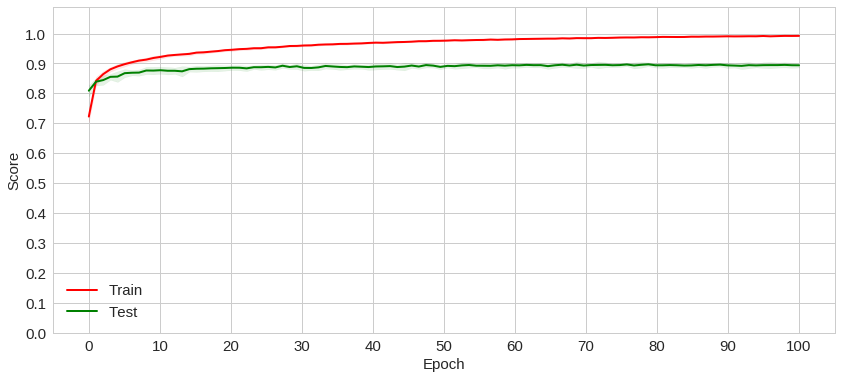

In [41]:
plot_mean_acc(tophistory)

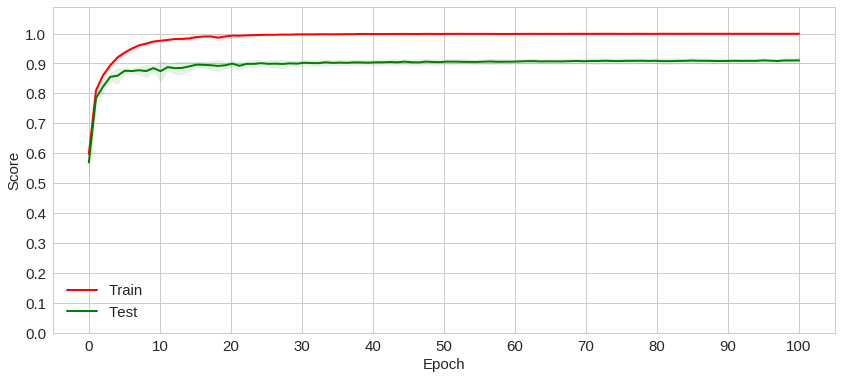

In [42]:
plot_mean_acc(history)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

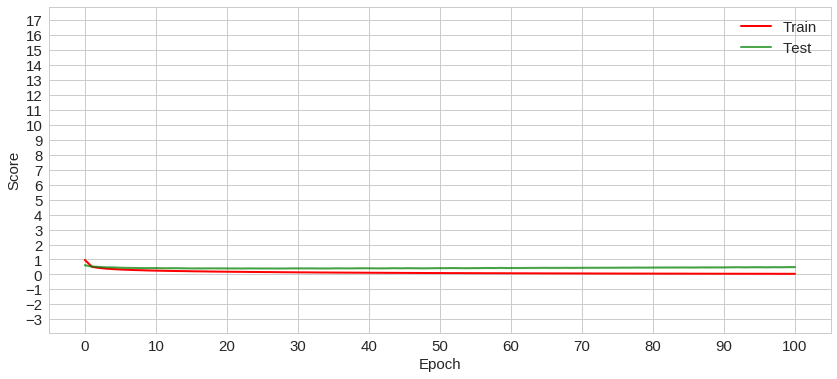

In [47]:
plot_mean_loss(tophistory)

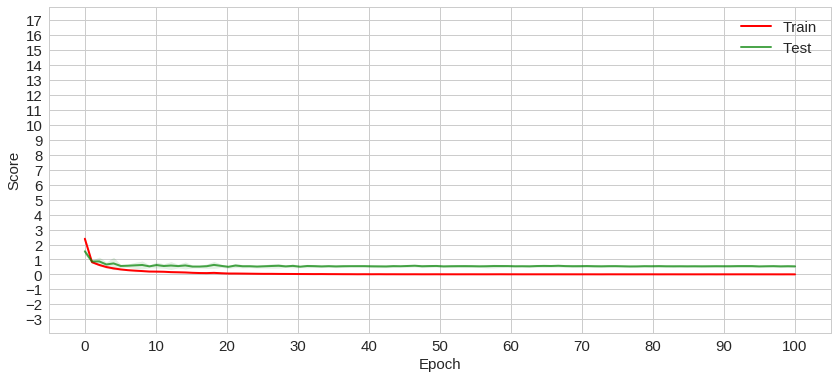

In [48]:
plot_mean_loss(history)